In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
from keras.layers import IntegerLookup
from keras.layers import Normalization
from keras.layers import StringLookup
from keras.utils import get_custom_objects
from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
#np.random.seed(42) # NumPy
#random.seed(42) # Python
#tf.random.set_seed(42) # Tensorflow

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
NumPy version: 1.24.2
SciPy version:  1.7.3


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version:  2.11.0
Keras version:  2.11.0
Pandas version:  1.5.3
SciKit-Learn version: 1.2.2
Imbalanced-Learn version: 0.10.1
Finished Installing Packages


## Get Data

In [3]:
def Get_Data():
    print ('Get_Data()')
    data = pd.read_csv(
        '../../Big_Files/CRSS_Imputed_All_05_19_23.csv',
        low_memory=False
    )
    print ('data.shape: ', data.shape)
    
    print ('End Get_Data()')
    print ()
    return data

def Test_Get_Data():
    data = Get_Data()
    display (data.head())
    
Test_Get_Data()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()



CASENUM  INT_HWY  MONTH  PEDS  PERMVIT  REL_ROAD  SCH_BUS  URBANICITY  \
0  201701219525        0      0     0        1         1        0           1   
1  201800450781        0      0     0        0         0        0           2   
2  201901811861        0      2     0        0         2        0           1   
3  201701360851        0      1     0        1         1        0           1   
4  201901343065        0      0     0        1         1        0           1   

   VE_TOTAL  DAY_WEEK  ...  RELJCT2  REST_USE  AIR_BAG  TYP_INT  VSPD_LIM  \
0         2         1  ...        1         1        1        1         2   
1         1         1  ...        1         1        1        1         7   
2         2         1  ...        1         1        1        1         7   
3         2         0  ...        1         1        1        1         2   
4         2         0  ...        1         1        1        1         2   

   VPROFILE  ALC_RES  ALC_STATUS  VEH_ALCH  VTRAFWAY  
0         1        0           1         1         0  
1         1        0           1         1         0  
2         1        0           1         1         0  
3         1        0           1         1         0  
4         1        0           1         1         0  

[5 rows x 82 columns]

# Remove_Pedestrian_Crashes

In [4]:
def Remove_Pedestrian_Crashes(data):
    print ('Remove_Pedestrian_Crashes()')
    display(data.PEDS.value_counts())
    n = len(data[data.PEDS>0])
    print ('Removing %d crashes that involve a pedestrian.' % n)
    data = data[data.PEDS==0]
    return data

def Test_Remove_Pedestrian_Crashes():
    data = Get_Data()
    print (len(data))
    data = Remove_Pedestrian_Crashes(data)
    print (len(data))

Test_Remove_Pedestrian_Crashes()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

619027
Remove_Pedestrian_Crashes()


0    591304
1     26801
2       922
Name: PEDS, dtype: int64

Removing 27723 crashes that involve a pedestrian.
591304


## Engineer Features

In [5]:
def Feature_Engineering_Cross_Two(data):
    print ('Feature_Engineering_Cross_Two')
    Pairs = [
        ['AGE', 'SEX', 'AGE_x_SEX'],
        ['AGE', 'SCH_BUS', 'AGE_x_SCH_BUS']
    ]
    for P in Pairs:
        data[P[2]] = data[P[0]].map(str) + '_x_' + data[P[1]].map(str)
    
    print ()
    return data
        

## Thin Features

In [6]:
def Thin_Features(data):
    print ('Thin_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
        'LGT_COND',
        'MONTH',
#        'PEDS',
        'PERMVIT',
        'PERNOTMVIT',
        'PJ',
        'PSU',
        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
        'RELJCT2',
        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
        'VE_FORMS',
        'VE_TOTAL',
        'WEATHER',
        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
        'BODY_TYP',
        'BUS_USE',
        'EMER_USE',
        'MAKE',
#        'MOD_YEAR',
        'MODEL',
        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
        'LOCATION',
        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
        'VEH_AGE',
        'AGE_x_SEX',
        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Thin_Features():
    data = Get_Data()
    data = Thin_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Thin_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_Features()
data.shape:  (619027, 38)
End Thin_Features()



2    395203
3    111949
0     47951
1     42134
4     21790
Name: AGE, dtype: int64

1    221301
5    153085
3     92952
2     59376
0     46961
4     45352
Name: BODY_TYP, dtype: int64

1    616201
2      2699
0       127
Name: BUS_USE, dtype: int64

1    465260
0    153767
Name: DAY_WEEK, dtype: int64

1    617091
0      1186
2       750
Name: EMER_USE, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

0    555566
1     63461
Name: INT_HWY, dtype: int64

3    445496
1    108465
0     50350
2     14716
Name: LGT_COND, dtype: int64

8    135069
0    121558
1     86857
6     81273
2     76578
4     71217
7     24997
3     12328
5      9150
Name: MAKE, dtype: int64

1    145569
4    136958
3    122451
2    112129
0    101920
Name: MODEL, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

3    348269
1    147867
5     62203
6     51666
2      6974
0      1565
4       483
Name: NUMOCCS, dtype: int64

2    348822
1    200622
0     69583
Name: PERMVIT, dtype: int64

0    589234
1     29793
Name: PERNOTMVIT, dtype: int64

2    456292
1    162609
0       126
Name: PER_TYP, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

0    603745
1     15282
Name: PVH_INVL, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

0    437984
8    161319
1     19460
9       264
Name: RELJCT1, dtype: int64

1    251423
0    168063
3    146673
2     52868
Name: RELJCT2, dtype: int64

1    549305
0     60920
2      8802
Name: REL_ROAD, dtype: int64

0    615928
1      3099
Name: SCH_BUS, dtype: int64

1    345482
0    273545
Name: SEX, dtype: int64

1    343683
2    204623
0     66083
3      4638
Name: TYP_INT, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    555113
0     48321
2     15593
Name: VALIGN, dtype: int64

0.0    199282
1.0    155216
2.0    132304
3.0     90266
4.0     41959
Name: VEH_AGE, dtype: int64

2    423804
1    107796
3     65694
4     21733
Name: VE_FORMS, dtype: int64

2    431474
1     95724
3     68682
4     23147
Name: VE_TOTAL, dtype: int64

1    528304
2     58774
0     31949
Name: VPROFILE, dtype: int64

2    170164
7    134614
5    102842
1     81817
4     60440
0     58578
3     10572
Name: VSPD_LIM, dtype: int64

1    400366
2    144639
3     62181
0     11841
Name: VTRAFCON, dtype: int64

0    336731
3    122470
1     87216
4     43374
2     29236
Name: VTRAFWAY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

0    606925
1     11193
2       750
3       159
Name: WRK_ZONE, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

## Really Thin Features

In [7]:
def Really_Thin_Features(data):
    print ('Really_Thin_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
#        'LOCATION',
#        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Really_Thin_Features():
    data = Get_Data()
    data = Really_Thin_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Really_Thin_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Really_Thin_Features()
data.shape:  (619027, 21)
End Thin_Features()



2    395203
3    111949
0     47951
1     42134
4     21790
Name: AGE, dtype: int64

1    465260
0    153767
Name: DAY_WEEK, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

0    555566
1     63461
Name: INT_HWY, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

0    437984
8    161319
1     19460
9       264
Name: RELJCT1, dtype: int64

1    549305
0     60920
2      8802
Name: REL_ROAD, dtype: int64

1    345482
0    273545
Name: SEX, dtype: int64

1    343683
2    204623
0     66083
3      4638
Name: TYP_INT, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    555113
0     48321
2     15593
Name: VALIGN, dtype: int64

1    528304
2     58774
0     31949
Name: VPROFILE, dtype: int64

2    170164
7    134614
5    102842
1     81817
4     60440
0     58578
3     10572
Name: VSPD_LIM, dtype: int64

1    400366
2    144639
3     62181
0     11841
Name: VTRAFCON, dtype: int64

0    336731
3    122470
1     87216
4     43374
2     29236
Name: VTRAFWAY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

In [8]:
def Thin_to_Minimal_Features(data):
    print ('Thin_to_Minimal_Features()')

    Accident = [
        'DAY_WEEK',
        'HOUR',
#        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
#        'REL_ROAD',
#        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
#        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
#        'VALIGN',
#        'VNUM_LAN',
#        'VPROFILE',
#        'VSPD_LIM',
#        'VSURCOND',
#        'VTRAFCON',
#        'VTRAFWAY',
    ]
    
    Person = [
#        'AGE',
#        'LOCATION',
#        'PER_TYP',
#        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
#        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Thin_to_Minimal_Features():
    data = Get_Data()
    data = Thin_to_Minimal_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Thin_to_Minimal_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_to_Minimal_Features()
data.shape:  (619027, 10)
End Thin_Features()



1    465260
0    153767
Name: DAY_WEEK, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

## Get Dummies

In [9]:
def Get_Dummies(data, target):
    print ('Get_Dummies')
    data = data.astype('category')
    Target = data.pop(target)
    data_Dummies = pd.get_dummies(data, prefix = data.columns)
    data_Dummies = data_Dummies.join(Target)
#    for feature in data_Dummies:
#        print (feature)
    print ()

    return data_Dummies

def Test_Get_Dummies():
    print ('Test_Get_Dummies')
    A = pd.DataFrame({
        'A': ['a', 'b', 'a'], 
        'B': ['b', 'a', 'c'], 
        'C': [1, 2, 3]})
    C = Get_Dummies(A, 'C')
    display(C)
    print ()

Test_Get_Dummies()

Test_Get_Dummies
Get_Dummies



A_a  A_b  B_a  B_b  B_c  C
0    1    0    0    1    0  1
1    0    1    1    0    0  2
2    1    0    0    0    1  3

## Test-Train Split
- We're using sklearn's train_test_split rather than Pandas's sample because the former has a 'stratify' option that will put the same proportion of HOSPITAL==1 into each set.

In [10]:
def Split_Data(data, target, test_size):
    print ('Split_Data()')
    X = data.drop(columns=[target])
    y = data[target]
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, 
        #random_state=42
    )
    
    a = y_train[y_train==1].shape[0]
    b = y_test[y_test==1].shape[0]
    print (
        x_train.shape, 
        y_train.shape, a, round((a/(a+b)*100),2), '%')
    print (
        x_test.shape, 
        y_test.shape, b, round((b/(a+b)*100),2), '%'
    )
    print ()
    
    return x_train, x_test, y_train, y_test

# Imbalanced Data Resampling

## Tomek Links

In [11]:
def Tomek_Links(X_train, y_train):
    print ('Tomek_Links()')
    M = len(y_train)
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    print ('Before Tomek Links:')
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()

    X_train, y_train = TomekLinks().fit_resample(X_train, y_train)
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    print ('After Tomek Links:')
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ('Removed %d samples, or %.2f%% of the set.' % (M-N, (M-N)/M*100))
    print ()
    
    return X_train, y_train

## Condensed Nearest Neighbor

In [12]:
def Condensed_Nearest_Neighbour(X_train, y_train):
    print ('Condensed_Nearest_Neighbour()')
    N = X_train.shape[0]
    print ('X_train.shape before = ', X_train.shape)
    print ('y_train.shape before = ', y_train.shape)
    print ()
    cnn = CondensedNearestNeighbour(n_neighbors=None)
    X_train, y_train = cnn.fit_resample(X_train, y_train)
    n = X_train.shape[0]
    print ('X_train.shape after = ', X_train.shape)
    print ('y_train.shape after = ', y_train.shape)
    print ()
    print ('Removed %d samples, or %.2f%% of the set.' % (N-n, (N-n)/N*100))
    print ()
    
    return X_train, y_train

# Undersample Data
- These functions take the three versions of the dataset, which correspond to these names in the paper:
    - Thin (Hard)
    - Really_Thin (Medium)
    - Thin_to_Minimum (Easy)
- runs Tomek Links on them once, then again, and saves the results to file.
- Each of the three sets takes about 90 minutes to run on my laptop.

In [13]:
%%time
def Undersample_Data_Thin(round_text):
    print ('Undersample_Data_Thin()')
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_Features(data)
    data = Get_Dummies(data, target)

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.80)
#    data = X_train
#    data[target] = y_train
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)

    # CNN took 6 minutes at 99% decreased set size.  
#    X_train, y_train = Condensed_Nearest_Neighbour(X_train, y_train)

    # 413,913 samples before Tomek
    X_train.to_csv('../../Big_Files/X_train_Thin_before_Tomek' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_before_Tomek' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_before_Tomek' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_before_Tomek' + round_text + '.csv', index=False)

    # Two rounds of Tomek took one hour 30 minutes
    X_train, y_train = Tomek_Links(X_train, y_train)
    # Write to csv and read back in, 
    #    so we can play with the stuff later without having to redo the Tomek Links, 
    #    which can take a long time.
    
    # 399,515 samples after Tomek, v1
    # 399,714  v2
    X_train.to_csv('../../Big_Files/X_train_Thin_after_Tomek' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_after_Tomek' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_after_Tomek' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_after_Tomek' + round_text + '.csv', index=False)

    
    X_train, y_train = Tomek_Links(X_train, y_train)
    # 396,511 after Tomek twice v1
    # 396,718 v2
    X_train.to_csv('../../Big_Files/X_train_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    print ()
    
def Undersample_Data_Really_Thin(round_text):
    print ('Undersample_Data_Really_Thin()')

    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)
    data = Really_Thin_Features(data)
    data = Get_Dummies(data, target)

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.80)
#    data = X_train
#    data[target] = y_train
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)

    # CNN took 6 minutes at 99% decreased set size.  
#    X_train, y_train = Condensed_Nearest_Neighbour(X_train, y_train)

    # 413,913 Samples

    X_train.to_csv('../../Big_Files/X_train_Really_Thin_before_Tomek' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Really_Thin_before_Tomek' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Really_Thin_before_Tomek' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Really_Thin_before_Tomek' + round_text + '.csv', index=False)

    # Two rounds of Tomek took one hour 30 minutes
    X_train, y_train = Tomek_Links(X_train, y_train)
    # Write to csv and read back in, 
    #    so we can play with the stuff later without having to redo the Tomek Links, 
    #    which can take a long time.
    
    # 406,691 Samples v1
    # 406,781 v2
    X_train.to_csv('../../Big_Files/X_train_Really_Thin_after_Tomek' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Really_Thin_after_Tomek' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Really_Thin_after_Tomek' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Really_Thin_after_Tomek' + round_text + '.csv', index=False)
    
    # 405,288 Samples v1
    # 405,368 v2

    X_train, y_train = Tomek_Links(X_train, y_train)
    X_train.to_csv('../../Big_Files/X_train_Really_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Really_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Really_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Really_Thin_after_Tomek_Twice' + round_text + '.csv', index=False)
    print ()
    
def Undersample_Data_Thin_to_Minimal(round_text):
    print ('Undersample_Data_Thin_to_Minimal()')

    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Minimal_Features(data)
    data = Get_Dummies(data, target)

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.80)
#    data = X_train
#    data[target] = y_train
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)

    # CNN took 6 minutes at 99% decreased set size.  
#    X_train, y_train = Condensed_Nearest_Neighbour(X_train, y_train)
    X_train.to_csv('../../Big_Files/X_train_Thin_to_Minimal_before_Tomek' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_to_Minimal_before_Tomek' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_to_Minimal_before_Tomek' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_to_Minimal_before_Tomek' + round_text + '.csv', index=False)


    # Two rounds of Tomek took one hour 30 minutes
    X_train, y_train = Tomek_Links(X_train, y_train)
    # Write to csv and read back in, 
    #    so we can play with the stuff later without having to redo the Tomek Links, 
    #    which can take a long time.
    X_train.to_csv('../../Big_Files/X_train_Thin_to_Minimal_after_Tomek' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_to_Minimal_after_Tomek' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_to_Minimal_after_Tomek' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_to_Minimal_after_Tomek' + round_text + '.csv', index=False)


    X_train, y_train = Tomek_Links(X_train, y_train)
    X_train.to_csv('../../Big_Files/X_train_Thin_to_Minimal_after_Tomek_Twice' + round_text + '.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_to_Minimal_after_Tomek_Twice' + round_text + '.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_to_Minimal_after_Tomek_Twice' + round_text + '.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_to_Minimal_after_Tomek_Twice' + round_text + '.csv', index=False)
    print ()
    
#Undersample_Data_Thin('_v1')
#Undersample_Data_Really_Thin('_v1')
#Undersample_Data_Thin_to_Minimal('_v1')

#Undersample_Data_Thin('_v2')
#Undersample_Data_Really_Thin('_v2')
#Undersample_Data_Thin_to_Minimal('_v2')



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


## Undersampling Results
- Start with 619,027 samples
- Remove 27,723 samples with pedestrians to get 591,304 samples
- Split 70/30 to have 413,912 samples in training set
- 62,114 hospitalized, 351,798 not hospitalized

| Feature Set | Random Seed | Tomek Round | # Samples Removed | % Samples Removed |
| --- | --- | --- | --- | --- |
| Hard | 1 | 1 | 14,398 | 3.48 |
| Hard | 2 | 1 | 14,199 | 3.43 |
| Hard | 1 | 2 | 3,004 | 0.75 |
| Hard | 2 | 2 | 2,996 | 0.75 |
| Medium | 1 | 1 | 7,222 | 1.74 |
| Medium | 2 | 1 | 7,132 | 1.72 |
| Medium | 1 | 2 | 1,403 | 0.34 |
| Medium | 2 | 2 | 1,413 | 0.35 |
| Easy | 1 | 1 | 4 | 0.00 |
| Easy | 2 | 1 | 5 | 0.00 |
| Easy | 1 | 2 | 1 | 0.00 |
| Easy | 2 | 2 | 1 | 0.00 |


 

# Custom Metrics
https://keras.io/api/metrics/

## Balanced Accuracy

In [14]:
def Balanced_Accuracy(y_true, y_pred):
    return K.mean(y_pred)

In [15]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [16]:
# https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
### Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
def custom_metric(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float64)
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    P = K.sum(y_true)
    N = K.sum(1 - y_true)
    # Note that Tensorflow and Keras round using "banker's rounding,"
    # where halves round to the nearest even integer, so
    # round(0.5) = 0, but round (1.5) = 2
    Discrete_y_pred = K.round(y_pred)
    TRUE = K.equal(y_true, Discrete_y_pred)
    TRUE = tf.dtypes.cast(TRUE, tf.float64)
    FALSE = 1-TRUE
    Discrete_TP = Discrete_y_pred * TRUE
    TP = K.sum(Discrete_TP)
    FN = P - TP
    Discrete_TN = (1 - Discrete_y_pred) * TRUE
    TN = K.sum(Discrete_TN)
    FP = N - TN    

#    CM = confusion_matrix(y_true, y_pred)
#    print (CM)
#    P = CM[1][0] + CM[1][1]
#    N = CM[0][0] + CM[0][1]
#    TN = CM[0][0]
#    FP = CM[0][1]
#    FN = CM[1][0]
#    TP = CM[1][1]
#    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
    return P, N, TP, FN, TN, FP

def Test_Custom_Metric():
    y_true = [0.0,1.0,0.0,1.0]
    y_proba = [0.2, 0.49, 0.75, 0.9]
    y_pred = [round(x) for x in y_proba]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    print (y_true)
    print (y_pred)
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
Test_Custom_Metric()
    

tf.Tensor([0. 1. 0. 1.], shape=(4,), dtype=float64)
tf.Tensor([0 0 1 1], shape=(4,), dtype=int64)
TP =  tf.Tensor(1.0, shape=(), dtype=float64)  FN =  tf.Tensor(1.0, shape=(), dtype=float64)  FP =  tf.Tensor(1.0, shape=(), dtype=float64)  TN =  tf.Tensor(1.0, shape=(), dtype=float64)


In [18]:
def Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP+TN)/(TP + FN + FP + TN + K.epsilon())
    return metric

In [19]:
def Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FP + K.epsilon())
    return metric

In [20]:
def Recall_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FN + K.epsilon())
    return metric

In [21]:
def Balanced_Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = ( TN/(2*(TN + FP + K.epsilon())) + TP/(2*(FN + TP + K.epsilon())))
    return metric

In [22]:
def F1_Metric(y_true, y_pred):
    precision = Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

In [23]:
def Gmean_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    precision = TP/(TP + FP + K.epsilon())
    specificity = TN/(TN + FP + K.epsilon())
    metric = K.sqrt(precision * specificity)
    return metric

In [24]:
def Balanced_Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP * N)/(TP * N + FP * P + K.epsilon())
    return metric

In [25]:
def Balanced_F1_Metric(y_true, y_pred):
    precision = Balanced_Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

# Loss Functions

## Alpha Weighted Binary Crossentropy

In [26]:
def alpha_weighted_binary_crossentropy_with_parameter(alpha = 0.5):
    def alpha_weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)

        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
        product = tf.multiply(binary_crossentropy, weights)
        loss = keras.backend.mean(product)
        return loss
    return alpha_weighted_binary_crossentropy


In [27]:
def alpha_weighted_binary_crossentropy_with_class_weight_parameters(weight_0 = 1.0, weight_1 = 1.0):
    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
    def alpha_weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)
        weights = tf.where(tf.equal(y_true,1),weight_1, weight_0)
        product = tf.multiply(binary_crossentropy, weights)
        loss = keras.backend.mean(product)
        return loss
    return alpha_weighted_binary_crossentropy


## Focal Loss

In [28]:
def focal_loss(y_true, y_pred):
    # The dataset has  259077  elements.
    # The target group has  31891  elements.
    # Our target is  12.3095 % of the dataset.
    # There are  8.12  negative elements for each positive.    
#    p = 8.12
    p = 5.94

    alpha = (p/(p+1))*1.0

    gamma_1 = 0.0 # Must be float for the tf.math.pow() function to work.
    gamma_2 = 0.0
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
    power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
    focal_power = tf.math.pow(focal,power)
#    print (focal.numpy())
#    print (power.numpy())
#    print (focal_power.numpy())
    product = tf.multiply(binary_crossentropy, weights)
    focal_power_product = tf.multiply(product, focal_power)
#    print (focal_power_product.numpy())
    loss = keras.backend.mean(focal_power_product)
#    print (loss.numpy())
    return loss

## Focal Loss with Parameters
- Adapted from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments

In [29]:
def focal_loss_with_parameters(alpha = 0.5, gamma_0=0.0, gamma_1=0.0):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
#        tf.clip_by_value(y_pred, 0.00001, 0.99999) # Make sure we don't blow up the logarithm
        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1.0-alpha)
        focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
        power = tf.where(tf.equal(y_true,0), gamma_0, gamma_1)
        focal_power = tf.math.pow(focal,power)
        product = tf.multiply(binary_crossentropy, weights)
        focal_power_product = tf.multiply(product, focal_power)
#        tf.clip_by_value(focal_power_product, 0.00001, 0.99999)
        loss = keras.backend.mean(focal_power_product)
        if math.isnan(loss):
            print ('loss is nan')
        return loss
    
    return focal_loss

get_custom_objects().update({'focal_loss_with_parameters': focal_loss_with_parameters()})

In [30]:
def focal_loss_with_parameters_2(alpha=.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1))-K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed


## Test Loss Functions

In [31]:
def Test_Loss_Functions():
    
    ### Data as list y_test and y_prob
    y_test = [0.0]*500 + [1.0]*500
    y_test_binary = [0]*500 + [1]*500
#    y_test = [0.0, 1.0]*5
#    y_test_binary = [0,1]*5
#    y_prob = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99, 0.999]
    y_prob = [random.random() for x in range (1000)]
#    print (y_prob)
    
    ### Data as tensors y_true and y_pred
    y_true = np.array(y_test, dtype=np.float32)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = np.array(y_prob, dtype=np.float32)
    y_pred = tf.convert_to_tensor(y_pred)

    ####################################################
    print ('Test with p==1.0, alpha = 0.5, gamma = 0.0')

    ### Calculate binary crossentropy by hand
    BCE = [-(y_test[i] * math.log(y_prob[i]) + (1 - y_test[i]) * math.log(1 - y_prob[i])) for i in range (10)]
    Class_Weights = [1.0,1.0]
    Weights = [Class_Weights[y_test_binary[i]] for i in range(10)]
    Product = [BCE[i] * Weights[i] for i in range (10)]
    loss = sum(Product)/len(Product)
    print (loss, "  Hand-calculated BCE loss")
    
    ### Calculate binary crossentropy like I did in my custom loss functions
    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)
#    display(binary_crossentropy.numpy())
    loss = keras.backend.mean(binary_crossentropy).numpy()
    print (loss, "  My custom AWBCE function's no-alpha backend")
    
    ### Calculate binary crossentropy using my custom loss function
    loss_function = alpha_weighted_binary_crossentropy_with_parameter(alpha = 0.5)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom one-parameter AWBCE function')
    
    ### Calculate binary crossentropy using my custom loss function
    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
    loss_function = alpha_weighted_binary_crossentropy_with_class_weight_parameters(weight_0 = 1.0, weight_1 = 1.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom two-parameter AWBCE function')
    
    ### Calculate binary crossentropy using Keras's loss function
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss = bce(y_true, y_pred).numpy()
    print (loss, "  Keras's BCE function")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.5,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.5, 0.0, 0.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function with gamma=0.0')
    
    ####################################################
    print ()
    print ('Test with p = 3.0, alpha = 0.75, gamma = 0.0')
    
    ### Calculate binary crossentropy using my custom loss function
    loss_function = alpha_weighted_binary_crossentropy_with_parameter(alpha = 0.75)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom one-parameter AWBCE function')
    
    ### Calculate binary crossentropy using my custom loss function
    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
    loss_function = alpha_weighted_binary_crossentropy_with_class_weight_parameters(weight_0 = 2.0/3.0, weight_1 = 2.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom two-parameter AWBCE function')
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.75,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.75, 0.0, 0.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function with gamma=0.0')
    
    ####################################################
    print ()
    print ('Test with alpha = 0.8, gamma = 0.0')
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.8,
        gamma = 0.0, 
#        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.8, 0.0, 0.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function')

    ####################################################
    print ()
    print ('Test with alpha = 0.8, gamma = 2.0')
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.8,
        gamma = 2.0, 
#        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.8, 2.0, 2.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function with gamma=2.0')

    ####################################################
    print ()
    print ('Test with p = 1.0, alpha = 0.5, gamma = 2.0')
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.5,
        gamma = 2.0, 
#        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.5, 2.0, 2.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function with gamma=2.0')

    ##################################################################
    print ()
    print ("Test Keras's BFC Function with different values of alpha")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.1,
        gamma = 0.0, 
#        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.5,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.9,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    

    
    
    
Test_Loss_Functions()

Test with p==1.0, alpha = 0.5, gamma = 0.0
0.6131508992696226   Hand-calculated BCE loss
1.0028547   My custom AWBCE function's no-alpha backend
0.50142735   My custom one-parameter AWBCE function
1.0028547   My custom two-parameter AWBCE function
1.0028547   Keras's BCE function
0.50142735   Keras's BFC function
0.50142735   My BFC function with gamma=0.0

Test with p = 3.0, alpha = 0.75, gamma = 0.0
0.5046252   My custom one-parameter AWBCE function
1.3456675   My custom two-parameter AWBCE function
0.5046252   Keras's BFC function
0.5046252   My BFC function with gamma=0.0

Test with alpha = 0.8, gamma = 0.0
0.5052648   Keras's BFC function
0.5052648   My BFC function

Test with alpha = 0.8, gamma = 2.0
0.31045672   Keras's BFC function
0.31045672   My BFC function with gamma=2.0

Test with p = 1.0, alpha = 0.5, gamma = 2.0
0.30637795   Keras's BFC function
0.30637795   My BFC function with gamma=2.0

Test Keras's BFC Function with different values of alpha
0.49631068   Keras's BFC 

# Models

## Simple Keras Model

In [32]:
def Make_Simple_Model(X_train):
    print ('Make_Model()')
    model = keras.Sequential(
        [
            keras.layers.Dense(
                256, activation="relu", input_shape=(X_train.shape[-1],)
            ),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
#    display(model.summary())
    print ()
    return model


In [33]:
def Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename):
    print ('Train_Model()')
    metrics = [
#        keras.metrics.FalseNegatives(name="fn"),
#        keras.metrics.FalsePositives(name="fp"),
#        keras.metrics.TrueNegatives(name="tn"),
#        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
#        keras.metrics.BinaryAccuracy(name="accuracy"),
        Balanced_Accuracy_Metric,
#        Gmean_Metric,
        Balanced_Precision_Metric,
#        F1_Metric,
        Balanced_F1_Metric,
    ]

    model.compile(
#        optimizer=keras.optimizers.Adam(), 
        optimizer=keras.optimizers.Adam(1e-7, clipnorm=0.99999), 
        loss=loss_function, 
        metrics=metrics
    )

#    class_weight = {0: weight_for_0, 1: weight_for_1}
#    class_weight = {0: 1, 1: 1}
    class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)}
    
    model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=30,
        verbose=0,
#        callbacks=callbacks,
        validation_data=(X_test, y_test),
        class_weight=class_weight,
    )
    
    # Make everything a numpy array
    y_proba = model.predict(X_test)
    # y_proba is a numpy array
    y_pred = np.around(y_proba)
    # y_test is a Pandas dataframe
    y_test = y_test.to_numpy()
    
    Balance_Proba(y_test, y_proba, y_pred, r_target, filename)    
    
    print ()
    return model

## Another Keras Binary Classification Model
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [34]:
def Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha, gamma, epochs, filename, title):
    print ('Keras_Binary_Focal_Crossentropy')
    print ('alpha = ', alpha)
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing=True,
        alpha=alpha,
        gamma=gamma,
#        from_logits=False,
#        label_smoothing=0.0,
#        axis=-1,
#        reduction=losses_utils.ReductionV2.AUTO,
#        name='binary_focal_crossentropy'
    )   
    
    # create model
    model = Sequential()
    model.add(Dense(60, input_shape=(X_train.shape[-1],), activation='relu'))
#    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))    
    # Compile model
    metrics = [
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        F1_Metric,
    ]
    model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(), metrics=metrics)
    estimator = KerasClassifier(
        model=model, 
#        random_state=42,
        metrics=metrics,
        batch_size=128, 
        verbose=0,
        epochs=epochs,
    )
    # What does this do?
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    
    # Fit model
    estimator.fit(
        X_train, 
        y_train.values.ravel(),
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    y_proba = estimator.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    print ('y_proba unique')
    print (np.unique(y_proba))
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    print ()
    return 0    

## Our Binary Focal Crossentropy Classification Model

In [35]:
def Our_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, gamma_0, gamma_1, epochs, filename, title):
    print ('Keras_Binary_Focal_Crossentropy')

    alpha_target = r_target/(r_target+1)
    loss_function = focal_loss_with_parameters(alpha_target, gamma_0, gamma_1)
#    loss_function = focal_loss_with_parameters_2(alpha_target, gamma)
    
    # create model
    model = Sequential()
    model.add(Dense(60, input_shape=(X_train.shape[-1],), activation='relu'))
#    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))    
    # Compile model
    model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    metrics = [
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        F1_Metric,
    ]
    estimator = KerasClassifier(
        model=model, 
#        random_state=42,
        metrics=metrics,
        batch_size=128, 
        verbose=0,
        epochs=epochs,
    )
    # What does this do?
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    
    # Fit model
    estimator.fit(
        X_train, 
        y_train.values.ravel(),
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    y_proba = estimator.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    print ()
    return 0    

## AdaBoost Model
https://stackoverflow.com/questions/39063676/how-to-boost-a-keras-based-neural-network-using-adaboost
- model.predict_proba(X_test) returns two columns, 
    - the first the probability that the sample is in class 0, 
    - and the second the probability that the sample is in class 1.
    - We just want the second column.

In [36]:
def AdaBoost(X_train, X_test, y_train, y_test, r_target, filename, title):
    print ('AdaBoost() ', filename)
    model = AdaBoostClassifier(n_estimators=100)
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    print ()
    return model    

### Ensembles of Classifiers
https://imbalanced-learn.org/stable/ensemble.html#bagging-classifier

with arguments based on the documentation examples

https://imbalanced-learn.org/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py

## Bagging Classifier

In [37]:
def Bagging(X_train, X_test, y_train, y_test, r_target, filename, title):
    print ('Bagging() ', filename)
    model = BalancedBaggingClassifier(
#        random_state=42
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)
#    display(pd.DataFrame(y_proba).value_counts())

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    print ()
    return model

## Balanced Random Forest Classifier

In [38]:
def Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, alpha, filename, title):
    print ('Balanced Random Forest Classifier ', filename)
    model = BalancedRandomForestClassifier(
#        max_depth=2, 
#        random_state=42, 
#        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)}
        class_weight = {0:1-alpha, 1:alpha}
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)
#    display(pd.DataFrame(y_proba).value_counts())

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    
    print ()
    return model    


## RUSBoost Classifier

In [39]:
def RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, r_target, filename, title):
    print ('RUSBoost Classifier ', filename)
    model = RUSBoostClassifier(
        n_estimators=1000, 
        estimator=estimator,
        algorithm='SAMME.R', 
#        random_state=42
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)
#    display(pd.DataFrame(y_proba).value_counts())

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    
    print ()
    return model    


## Easy Ensemble Classifier (Adaboost)

In [40]:
def Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title):
    print ('Easy Ensemble Classifier ', filename)
    estimator = AdaBoostClassifier(n_estimators=10)
    model = EasyEnsembleClassifier(n_estimators=10, estimator=estimator)
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)
#    display(pd.DataFrame(y_proba).value_counts())

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    
    print ()
    return model    

## Logistic Regression

In [41]:
def Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, alpha, filename, title):
    print ('Logistic Regression Classifier ', filename)
    model = LogisticRegression(
#        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)}
        class_weight = {0:1-alpha, 1:alpha},
        max_iter=1000,
#        random_state=42,
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title)
    
    print ()
    return model    

# Evaluate Models

## Adjust Center of Probability Distribution

In [42]:
def Shift_y_proba(y_test, y_proba, y_pred, filename):
    print ('Shift_y_proba()')
    print ()
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
    center = (N_median + P_median)/2
    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))

    y_proba = y_proba - center + 0.5
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
    center = (N_median + P_median)/2
    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
    
    print ()
    
    return y_test, y_proba, y_pred, filename
    

In [43]:
def Linear_Transform_y_proba(y_test, y_proba, y_pred, filename):
    print ('Linear_Transform_y_proba()')
    print ()
    
    # I considered two methods.  
    # One was to take the medians of the negative and positive classes and transform them to 0.25 and 0.75.
    # That didn't always work the way I wanted.  
    # Then I tried taking the 0.05 quantile to 0.05 and the 0.95 quantile to 0.95.
    
#    N_median = np.median(y_proba[np.array(y_test)==0])
#    P_median = np.median(y_proba[np.array(y_test)==1])
#    center = (N_median + P_median)/2
#    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
#    y_proba = 0.25/(center - N_median) * (y_proba - center) + 0.5

    
    a = np.quantile(y_proba[np.array(y_test)==0],0.05)
    b = np.quantile(y_proba[np.array(y_test)==1],0.95)
    print ('a = %.3f, b = %.3f' % (a, b))
    y_proba = 0.9/(b-a) * (y_proba - a) + 0.05
    
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    print ()
    
    return y_test, y_proba, y_pred, filename
    

In [44]:
def Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, r_target, filename):
    print ('Shift_y_proba_to_FP_equals_r_TP()')
    print ('y_test is a ', type(y_test))
    print ('y_proba is a ', type(y_proba))
    print ()
    
    
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
    n = 100
    m = np.quantile(C, 0.005)
    M = np.quantile(D,0.995)
    print ('Quantiles ', m, M)
    bins = [(M-m) * (x/n) + m for x in range (0, n+1)]
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    """
    df = pd.DataFrame()
    df['TP'] = G
    df['FP'] = H
    roll = 10
    df['TP_RA'] = G.rolling(roll, center=True, min_periods=1).mean()
    df['FP_RA'] = H.rolling(roll, center=True, min_periods=1).mean()
    df['TP/FP'] = df['TP_RA']/df['FP_RA']
    df['TP/FP_RA'] = df['TP/FP'].rolling(roll, center=True, min_periods=1).mean()
    df['Truncate'] = np.where(df['TP/FP_RA']>2,2,df['TP/FP_RA'])
    df['bins'] = bins[:-1]
    df.fillna(0, inplace=True)
    
    #    display(df)
    df_closest = df.iloc[(df['TP/FP_RA'] - r_target).abs().argsort()[:1]]
    center = df_closest['bins'].to_numpy()
    center = center[0]
    center_index = df.index[df['bins'] == center].tolist()
#    print (df_closest)
    print ('center = ', center)
#    print (center_index)
    print ()
    
    print ('Plot TP/FP')
    x = df['bins'].to_numpy()
    y = df['TP/FP_RA'].to_numpy()
    fig = plt.figure(figsize=(2.4,1.8)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    plt.plot(x,y, label='TP/FP', color='black')
    plt.axhline(y=2.0, color='black', linestyle='--', label='2.0')  
    plt.plot([center], [2.0], marker="o", markersize=6, markerfacecolor='black', markeredgecolor='black')
    plt.xticks(
        ticks = [m, center, M], 
        labels = [round(m,3), round(center, 3), round(M,3)],
        rotation=0
    )
    ax.legend()
    plt.title('$\Delta$TP/$\Delta$FP')
    plt.xlabel('$p$')
    plt.ylabel('$\Delta$TP/$\Delta$FP')
    plt.savefig('./Images/' + filename + '_TP_FP.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_TP_FP.pgf', bbox_inches="tight")
    plt.show()
    plt.close()
    """
    
    df = pd.DataFrame()
    df['FP'] = G
    df['TP'] = H
    roll = 10
    df['FP_RA'] = G.rolling(roll, center=True, min_periods=1).mean()
    df['TP_RA'] = H.rolling(roll, center=True, min_periods=1).mean()
    df['FP/TP'] = df['FP_RA']/df['TP_RA']
    df['FP/TP_RA'] = df['FP/TP'].rolling(roll, center=True, min_periods=1).mean()
    df['Truncate'] = np.where(df['FP/TP_RA']>2,2,df['FP/TP_RA'])
    df['bins'] = bins[:-1]
    df.fillna(0, inplace=True)
    
    #    display(df)
    df_closest = df.iloc[(df['FP/TP_RA'] - r_target).abs().argsort()[:1]]
    center = df_closest['bins'].to_numpy()
    center = center[0]
    center_index = df.index[df['bins'] == center].tolist()
#    print (df_closest)
    print ('center = ', center)
#    print (center_index)
    print ()
    
    print ('Plot FP/TP')
    x = df['bins'].to_numpy()
    y = df['FP/TP_RA'].to_numpy()
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    plt.plot(x,y, label='$\Delta FP/\Delta TP$', color='black')
    plt.axhline(y=2.0, color='black', linestyle='--')  
    plt.plot([center], [2.0], label='(%.3f,2)' % center, marker="o", markersize=6, markerfacecolor='black', markeredgecolor='black')
    plt.xticks(
        ticks = [m, M], 
#        labels = [round(m,3), round(center, 3), round(M,3)],
        labels = [round(m,3), round(M,3)],
        rotation=0
    )
#    ax.annotate('data = (%.3f, %.1f)'%(center, 2.0),(center, 2.0), textcoords='data')
#    plt.text(center,2.0,'(%.3f,%.1f)' % (center, 2.0),horizontalalignment='left', verticalalignment='bottom')
#    plt.title('$\Delta FP/\Delta TP$')
    plt.xlabel('$p$')
    plt.ylabel('$\Delta$FP/$\Delta$TP')
    ax.legend()
    plt.savefig('./Images/' + filename + '_FP_TP.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_FP_TP.pgf', bbox_inches="tight")
    plt.show()
    plt.close()

    # Re-center the distribution
    y_proba = y_proba - center + 0.5

    # Decide which direction to dilate the distribution
    M = np.quantile(y_proba,0.995)
    m = np.quantile(y_proba,0.005)
    right = M-0.5
    left = 0.5-m
    # If the tail to the right is longer, map M to 1 and 0.5 to itself.
    if left < right:
        y_proba = (1/(2*M-1))*(y_proba - 0.5) + 0.5
    # If the tail to the left is longer, map m to 0 and 0.5 to itself.
    if left > right:
        y_proba = (1/(1-2*m))*(y_proba - 0.5) + 0.5
    print ('y_proba unique = ', np.unique(y_proba))
    y_proba = np.clip(y_proba,0,1)
    print ('y_proba unique = ', np.unique(y_proba))
    print ('M, m, left, right = ', M, m, left, right)
    y_pred = K.round(y_proba).numpy()
    
    return y_test, y_proba, y_pred, center, filename
    

In [45]:
def Balance_Proba(y_test, y_proba, y_pred, r_target, filename, title):
    print ('Balance_Proba')
    print (filename)

    y_test, y_proba_New, y_pred_New, center, filename = Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, r_target, filename)

    N = y_proba[np.array(y_test)==0]
    P = y_proba[np.array(y_test)==1]
    N_median = np.median(N)
    P_median = np.median(P)

    Plot_Prediction(y_test, y_proba, filename, title)
#    ROC(y_test, y_proba, [center, N_median, P_median], filename)    
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, center, filename)    
    print ()

    filename = filename + '_Linear_Transform'
    title = title + ' Trans'

    N = y_proba_New[np.array(y_test)==0]
    P = y_proba_New[np.array(y_test)==1]
    N_median = np.median(N)
    P_median = np.median(P)
    
    Plot_Prediction(y_test, y_proba_New, filename, title)
#    ROC(y_test, y_proba, [center, N_median, P_median], filename)    
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba_New, y_pred_New, center, filename)    
    print ()
    


## Evaluate_Model

In [46]:
def Evaluate_Model(y_test, y_proba, y_pred, center, filename):
    print ('Evaluate_Model()')
    y_test = np.array(y_test)
    y_pred = [round(x) for x in y_proba]
    y_pred = np.array(y_pred)
    print ('np.unique(y_proba) = ', np.unique(y_proba))
    print ('np.unique(y_pred) = ', np.unique(y_pred))
    CM = confusion_matrix(y_test, y_pred)
    print(CM)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    
    CSV = [[filename, CM[0][0], CM[0][1], CM[1][0], CM[1][1], center, auc_value]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
        CSV,
        delimiter =", ", 
        fmt ='% s'
              )
    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
    print(CM)
    print ()

    y_pred = y_pred.ravel()
    y_test = tf.convert_to_tensor(y_test)
    y_pred = tf.convert_to_tensor(y_pred)

    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())



## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [47]:
def Plot_Prediction(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_Pred.pgf', bbox_inches="tight")
    plt.show()
    plt.close()
    print ()


## ROC Curves

[0 0 0 ... 0 0 1]
[0.562 0.495 0.653 ... 0.577 0.565 0.593]
ROC()
tmp
p_values =  [0.5]


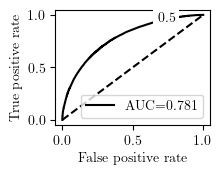

In [54]:
def ROC(y_test, y_proba, p_values, filename):
    print ('ROC()')
    print (filename)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
        plt.text(
            y[2], y[3], # these are the coordinates to position the label
            y[1], # this is the text
            backgroundcolor='white', # horizontal alignment can be left, right or center
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='best')
    plt.savefig('./Images/' + filename + '_ROC.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_ROC.pgf', bbox_inches="tight")
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
Test_ROC()



## Build Idealized Results Plots
- The Plot_Prediciton and ROC_Curves functions take two lists (or np arrays) and a filename for saving the plots:
    - ROC(y_test, y_proba, filename):
    - Plot_Prediction(y_test, y_proba, filename):
    - y_test is the {0,1} binary and 
    - y_proba is the (0,1) continuous
- The Evaluate_Model(y_test, y_proba, y_pred, filename) takes three lists (or np arrays)
    - y_test is the {0,1} binary ground truth,
    - y_proba is the (0,1) continuous prediction, and
    - y_pred is the discrete {0,1} binary version of y_proba
- We want a 

In [49]:
def Move_Threshold(y_proba, y_test):
    print ('Move_Threshold()')
    n = 10
    T = [x/n for x in range (n+1)]
    
    print (type(y_proba))
    print (type(y_test))
    y_test = np.array(y_test)
    print (type(y_test))
    N = y_proba[y_test==0]
    P = y_proba[y_test==1]
    print (len(N), len(P))

    A = [['t', 'TN', 'FP', 'FN', 'TP', 'TPR', 'FPR']]
    for t in T:
        TN = len(N[N<t])
        FP = len(N[N>t])
        FN = len(P[P<t])
        TP = len(P[P>t])
        TPR = TP/len(P)
        FPR = FP/len(N)
        A.append([t, TN, FP, FN, TP, TPR, FPR])
    display(pd.DataFrame(A))
    
    print ()


def Idealized_Results():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 150771)
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.8, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 26621)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    Y_PROBA = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    N_median = np.median(a)
    P_median = np.median(b)
    
    Move_Threshold(y_proba, y_test)
    
    filename = 'Ideal'
    print (filename)
    title = 'Original Example'
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [N_median, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    filename = 'Ideal_Left'
    title = 'Never Ambulance'
    print (filename)
    y_proba = 0.5 * y_proba
    y_pred = K.round(y_proba)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [N_median, 0.5, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()

    filename = 'Ideal_Left_Shifted'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Shift_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    filename = 'Ideal_Left_Linear_Transform'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Linear_Transform_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    filename = 'Ideal_Right'
    title = 'Always Ambulance'
    print (filename)
    y_proba = 0.5 * Y_PROBA + 0.5
    y_pred = K.round(y_proba)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [N_median, 0.5, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()

    filename = 'Ideal_Right_Shifted'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Shift_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    filename = 'Ideal_Right_Linear_Transform'
    title = ''
    print (filename)
    y_test, y_proba, y_pred, filename = Linear_Transform_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    y_proba = Y_PROBA
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Ideal_Tight'
    title = 'Tight'
    print (filename)
    y_proba = 0.2 * Y_PROBA + 0.4
    y_pred = K.round(y_proba)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [N_median, 0.5, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
   
    y_proba = Y_PROBA
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Ideal_Shift_to_FP_equals_r_TP'
    title = 'Transformed'
    print (filename)
    y_test, y_proba, y_pred, p_target, filename_tmp = Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, 2.0, filename)
    print ('type(y_test) = ', type(y_test))
    N = y_proba[np.array(y_test)==0]
    P = y_proba[np.array(y_test)==1]
    display(N)
    N_median = np.median(N)
    P_median = np.median(P)
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [N_median, P_median], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    print ()
    
    

    
#Idealized_Results()

In [50]:
def Awful_Results():
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    
    
    
    shape, scale = 1.0, 0.5 # mean=4, std=2*sqrt(2)
    a = np.random.random(600)   
    
    b = np.random.random(100)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Awful'
    title = 'Awful'
    Plot_Prediction(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)    
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)    
    
#Awful_Results()

## Run Models

In [51]:
def Run_Models(Features = 'Hard', Tomek = 0, Version = 1):
    r_target = 2.0
    alpha = r_target/(1+r_target)

    
    if Features == 'Hard':
        read_filename_features = '_Thin'
        write_filename_features = '_Hard'
    if Features == 'Medium':
        read_filename_features = '_Really_Thin'
        write_filename_features = '_Medium'
    if Features == 'Easy':
        read_filename_features = '_Thin_to_Minimal'
        write_filename_features = '_Easy'
    if Tomek==0:
        read_filename_tomek = '_before_Tomek'
        write_filename_tomek = '_Tomek_0'
    if Tomek==1:
        read_filename_tomek = '_after_Tomek'
        write_filename_tomek = '_Tomek_1'
    if Tomek==2:
        read_filename_tomek = '_after_Tomek_Twice'
        write_filename_tomek = '_Tomek_2'
    if Version==1:
        filename_version = '_v1'
        random_seed = 0
    if Version==2:
        filename_version = '_v2'
        random_seed = 42

    X_train = pd.read_csv('../../Big_Files/X_train' + read_filename_features + read_filename_tomek + filename_version + '.csv')
    y_train = pd.read_csv('../../Big_Files/y_train' + read_filename_features + read_filename_tomek + filename_version + '.csv').squeeze()
    X_test = pd.read_csv('../../Big_Files/X_test' + read_filename_features + read_filename_tomek + filename_version + '.csv')
    y_test = pd.read_csv('../../Big_Files/y_test' + read_filename_features + read_filename_tomek + filename_version + '.csv').squeeze()

    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha_balanced = p/(p+1)
    print ('p = ', p)
    print ('alpha_balanced = ', alpha_balanced)
    
    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'KBFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_balanced_gamma_0_0' + filename_version
    title = 'Focal $\gamma=0.0$'
    print (filename)
    print ('alpha_balanced = ', alpha_balanced)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_balanced, gamma, epochs, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'KBFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_target_gamma_0_0' + filename_version
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha, gamma, epochs, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'KBFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_0_5_gamma_0_0' + filename_version
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, 0.5, gamma, epochs, filename, title)


    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'KBFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_target_gamma_0_5' + filename_version
    title = 'Focal $\gamma=0.5$'
    print (filename)
    gamma = 0.5
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha, gamma, epochs, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'KBFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_target_gamma_1_0' + filename_version
    title = 'Focal $\gamma=1.0$'
    print (filename)
    gamma = 1.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha, gamma, epochs, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'KBFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_target_gamma_2_0' + filename_version
    title = 'Focal $\gamma=2.0$'
    print (filename)
    gamma = 2.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha, gamma, epochs, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'KBFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_target_gamma_5_0' + filename_version
    title = 'Focal $\gamma=5.0$'
    print (filename)
    gamma = 5.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha, gamma, epochs, filename, title)


    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'LRC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_0_5' + filename_version
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, 0.5, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    

    print ()
    print ('------------------------------------------')
    filename_model = 'LRC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_target' + filename_version
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, alpha, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'LRC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_balanced' + filename_version
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, alpha_balanced, filename, title)
    
    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'BRFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_0_5' + filename_version
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, 0.5, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'BRFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_target' + filename_version
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, alpha, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'BRFC'
    filename = filename_model + write_filename_features + write_filename_tomek + '_alpha_balanced' + filename_version
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, alpha_balanced, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'AdaBoost'
    filename = filename_model + write_filename_features + write_filename_tomek + '' + filename_version
    title = 'AdaBoost'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename, title)
    
    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'Bagging'
    filename = filename_model + write_filename_features + write_filename_tomek + '' + filename_version
    title = 'BalBag'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'RUSBoost'
    filename = filename_model + write_filename_features + write_filename_tomek + '' + filename_version
    title = 'RUSBoost'
    estimator = DecisionTreeClassifier(
        max_depth=1,
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, r_target, filename, title)

    np.random.seed(random_seed) # NumPy
    random.seed(random_seed) # Python
    tf.random.set_seed(random_seed) # Tensorflow
    
    print ()
    print ('------------------------------------------')
    filename_model = 'EEC'
    filename = filename_model + write_filename_features + write_filename_tomek + '' + filename_version
    title = 'EasyEns'
    Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)
    
    
    

p =  5.547477219306437
alpha_balanced =  0.8472694189677642

------------------------------------------
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v1
alpha_balanced =  0.8472694189677642
Keras_Binary_Focal_Crossentropy
alpha =  0.8472694189677642


2023-04-10 08:34:12.444336: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


y_proba unique
[0.00508146 0.00835997 0.00846817 ... 0.98458093 0.98464453 0.9860255 ]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.09051551073789597 0.9653112173080445
center =  0.8778316466510296

Plot FP/TP


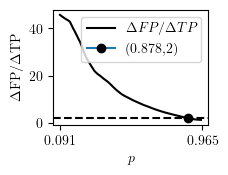

y_proba unique =  [-0.0584985  -0.05640048 -0.05633128 ...  0.568312    0.5683527
  0.56923646]
y_proba unique =  [0.         0.00000083 0.00000906 ... 0.568312   0.5683527  0.56923646]
M, m, left, right =  0.5739847651124004 -0.2813361430168152 0.7813361430168152 0.07398476511240037
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


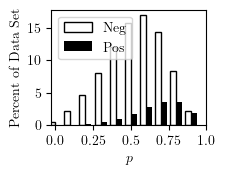


ROC()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v1
p_values =  []


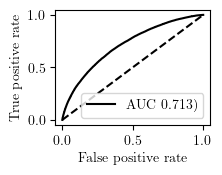


Evaluate_Model()
np.unique(y_proba) =  [0.00508146 0.00835997 0.00846817 ... 0.98458093 0.98464453 0.9860255 ]
np.unique(y_pred) =  [0 1]
[[ 48767 102004]
 [  2839  23782]]

[[0.27491093 0.57502029]
 [0.0160041  0.13406467]]

0.189 & Precision \cr 
0.893 & Recall \cr 
0.312 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


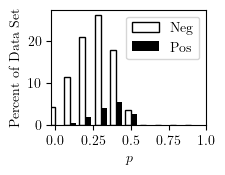


ROC()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v1_Linear_Transform
p_values =  []


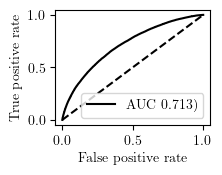


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000083 0.00000906 ... 0.568312   0.5683527  0.56923646]
np.unique(y_pred) =  [0 1]
[[144426   6345]
 [ 21886   4735]]

[[0.81416298 0.03576824]
 [0.12337648 0.0266923 ]]

0.427 & Precision \cr 
0.178 & Recall \cr 
0.251 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.00319567 0.00374343 0.00378689 ... 0.96877545 0.97244245 0.9755035 ]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03854544833302498 0.9168987154960633
center =  0.7060939313769341

Plot FP/TP


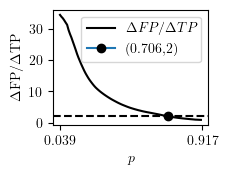

y_proba unique =  [-0.02828658 -0.02787495 -0.02784228 ...  0.69742703  0.70018315
  0.7024838 ]
y_proba unique =  [0.         0.0000008  0.00002375 ... 0.69742703 0.70018315 0.7024838 ]
M, m, left, right =  0.6756009492278103 -0.16526223838329315 0.6652622383832931 0.17560094922781033
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


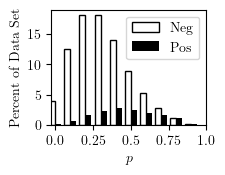


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v1
p_values =  []


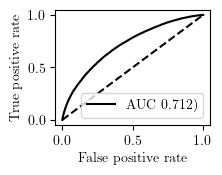


Evaluate_Model()
np.unique(y_proba) =  [0.00319567 0.00374343 0.00378689 ... 0.96877545 0.97244245 0.9755035 ]
np.unique(y_pred) =  [0 1]
[[118377  32394]
 [ 13250  13371]]

[[0.66731871 0.18261252]
 [0.07469333 0.07537544]]

0.292 & Precision \cr 
0.502 & Recall \cr 
0.369 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


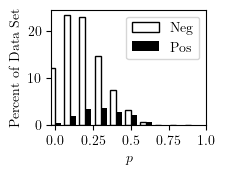


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v1_Linear_Transform
p_values =  []


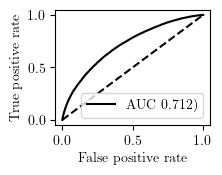


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0000008  0.00002375 ... 0.69742703 0.70018315 0.7024838 ]
np.unique(y_pred) =  [0 1]
[[143875   6896]
 [ 21494   5127]]

[[0.81105687 0.03887436]
 [0.12116668 0.02890209]]

0.426 & Precision \cr 
0.193 & Recall \cr 
0.265 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.5
y_proba unique
[0.0033876  0.00359158 0.00466745 ... 0.920585   0.94520104 0.9554803 ]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.021421310491859913 0.8331014037132267
center =  0.5490133710857483

Plot FP/TP


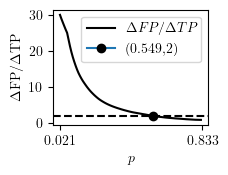

y_proba unique =  [-0.01855707 -0.01836324 -0.01734072 ...  0.85313785  0.8765327
  0.88630193]
y_proba unique =  [0.         0.00000075 0.00000098 ... 0.85313785 0.8765327  0.88630193]
M, m, left, right =  0.731319788098336 -0.02609997749328613 0.5260999774932862 0.23131978809833598
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


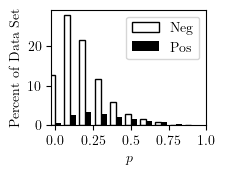


ROC()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v1
p_values =  []


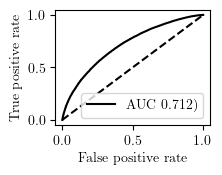


Evaluate_Model()
np.unique(y_proba) =  [0.0033876  0.00359158 0.00466745 ... 0.920585   0.94520104 0.9554803 ]
np.unique(y_pred) =  [0 1]
[[141306   9465]
 [ 20343   6278]]

[[0.79657482 0.05335641]
 [0.11467823 0.03539055]]

0.399 & Precision \cr 
0.236 & Recall \cr 
0.296 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


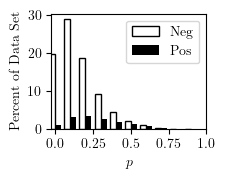


ROC()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v1_Linear_Transform
p_values =  []


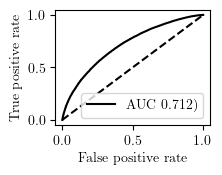


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000075 0.00000098 ... 0.85313785 0.8765327  0.88630193]
np.unique(y_pred) =  [0 1]
[[144304   6467]
 [ 21740   4881]]

[[0.81347524 0.03645598]
 [0.12255344 0.02751533]]

0.430 & Precision \cr 
0.183 & Recall \cr 
0.257 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.0167176  0.02021846 0.02327934 ... 0.91037655 0.9148635  0.92209744]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.08219457305967807 0.8485395550727844
center =  0.6569533095695078

Plot FP/TP


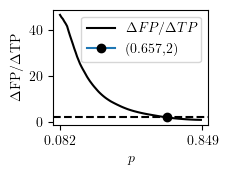

y_proba unique =  [-0.06080222 -0.05773574 -0.05505461 ...  0.7219812   0.7259115
  0.7322479 ]
y_proba unique =  [0.         0.0000031  0.00002372 ... 0.7219812  0.7259115  0.7322479 ]
M, m, left, right =  0.6531763470172883 -0.07082133322954177 0.5708213332295418 0.15317634701728833
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


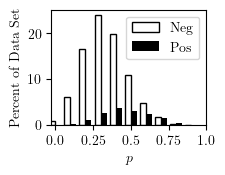


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v1
p_values =  []


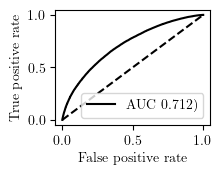


Evaluate_Model()
np.unique(y_proba) =  [0.0167176  0.02021846 0.02327934 ... 0.91037655 0.9148635  0.92209744]
np.unique(y_pred) =  [0 1]
[[119121  31650]
 [ 13482  13139]]

[[0.67151281 0.17841842]
 [0.07600117 0.0740676 ]]

0.293 & Precision \cr 
0.494 & Recall \cr 
0.368 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


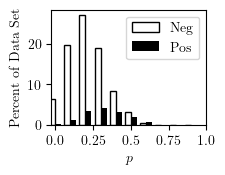


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v1_Linear_Transform
p_values =  []


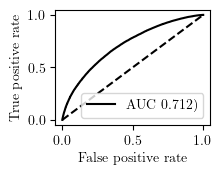


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0000031  0.00002372 ... 0.7219812  0.7259115  0.7322479 ]
np.unique(y_pred) =  [0 1]
[[144123   6648]
 [ 21716   4905]]

[[0.8124549  0.03747632]
 [0.12241815 0.02765063]]

0.425 & Precision \cr 
0.184 & Recall \cr 
0.257 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.0168481  0.02806243 0.03025961 ... 0.850252   0.8564752  0.86296093]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.12031976506114006 0.787658214569092
center =  0.6274969866871836

Plot FP/TP


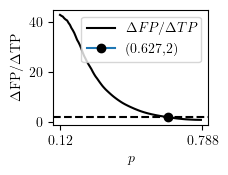

y_proba unique =  [-0.10764384 -0.0964846  -0.0942983  ...  0.7216588   0.7278514
  0.73430526]
y_proba unique =  [0.         0.00003055 0.000049   ... 0.7216588  0.7278514  0.73430526]
M, m, left, right =  0.6237690138816843 -0.00247269868850708 0.5024726986885071 0.12376901388168426
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


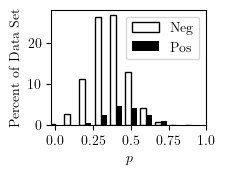


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v1
p_values =  []


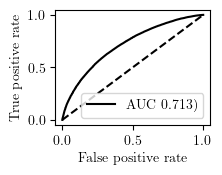


Evaluate_Model()
np.unique(y_proba) =  [0.0168481  0.02806243 0.03025961 ... 0.850252   0.8564752  0.86296093]
np.unique(y_pred) =  [0 1]
[[118753  32018]
 [ 13283  13338]]

[[0.66943831 0.18049292]
 [0.07487936 0.07518941]]

0.294 & Precision \cr 
0.501 & Recall \cr 
0.371 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


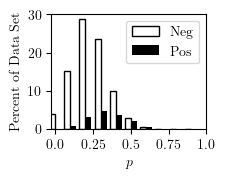


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v1_Linear_Transform
p_values =  []


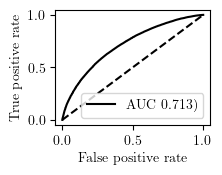


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00003055 0.000049   ... 0.7216588  0.7278514  0.73430526]
np.unique(y_pred) =  [0 1]
[[144641   6130]
 [ 21987   4634]]

[[0.81537499 0.03455624]
 [0.12394584 0.02612294]]

0.431 & Precision \cr 
0.174 & Recall \cr 
0.248 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.05344433 0.06706973 0.07579836 ... 0.7610921  0.76310784 0.80793417]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.2213393621146679 0.7035582542419444
center =  0.5830035312101253

Plot FP/TP


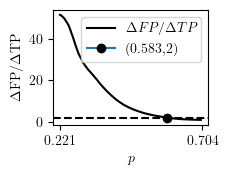

y_proba unique =  [-0.24173164 -0.22264713 -0.21042132 ...  0.7494413   0.7522646
  0.8150511 ]
y_proba unique =  [0.         0.00000495 0.00008547 ... 0.7494413  0.7522646  0.8150511 ]
M, m, left, right =  0.5911442089080812 0.14302508980035783 0.35697491019964217 0.09114420890808117
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


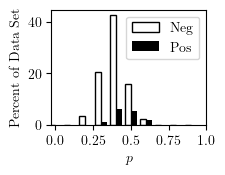


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v1
p_values =  []


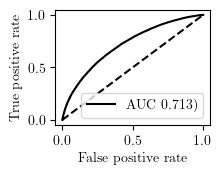


Evaluate_Model()
np.unique(y_proba) =  [0.05344433 0.06706973 0.07579836 ... 0.7610921  0.76310784 0.80793417]
np.unique(y_pred) =  [0 1]
[[118420  32351]
 [ 13220  13401]]

[[0.66756111 0.18237012]
 [0.07452422 0.07554456]]

0.293 & Precision \cr 
0.503 & Recall \cr 
0.370 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


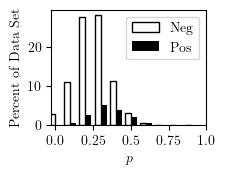


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v1_Linear_Transform
p_values =  []


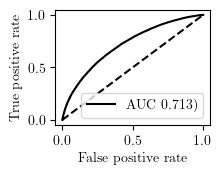


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000495 0.00008547 ... 0.7494413  0.7522646  0.8150511 ]
np.unique(y_pred) =  [0 1]
[[144443   6328]
 [ 21815   4806]]

[[0.81425882 0.03567241]
 [0.12297623 0.02709254]]

0.432 & Precision \cr 
0.181 & Recall \cr 
0.255 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.09686116 0.11022449 0.12294547 ... 0.64285636 0.6580974  0.66467655]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.3298529237508774 0.5989472925662995
center =  0.5424374751150609

Plot FP/TP


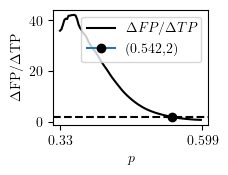

y_proba unique =  [-0.5736512  -0.5414512  -0.51079905 ...  0.74196714  0.7786916
  0.7945446 ]
y_proba unique =  [0.         0.00000158 0.00009638 ... 0.74196714 0.7786916  0.7945446 ]
M, m, left, right =  0.5419830742478371 0.2924948292970657 0.20750517070293428 0.04198307424783709
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


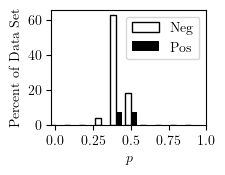


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v1
p_values =  []


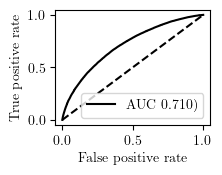


Evaluate_Model()
np.unique(y_proba) =  [0.09686116 0.11022449 0.12294547 ... 0.64285636 0.6580974  0.66467655]
np.unique(y_pred) =  [0 1]
[[118626  32145]
 [ 13433  13188]]

[[0.66872238 0.18120885]
 [0.07572495 0.07434383]]

0.291 & Precision \cr 
0.495 & Recall \cr 
0.367 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


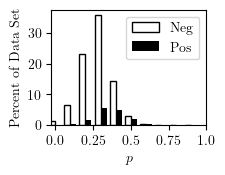


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v1_Linear_Transform
p_values =  []


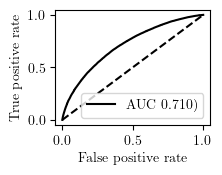


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000158 0.00009638 ... 0.74196714 0.7786916  0.7945446 ]
np.unique(y_pred) =  [0 1]
[[145322   5449]
 [ 22322   4299]]

[[0.81921394 0.03071728]
 [0.12583431 0.02423446]]

0.441 & Precision \cr 
0.161 & Recall \cr 
0.236 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_1_alpha_0_5_v1
Balance_Proba
LRC_Medium_Tomek_1_alpha_0_5_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.026066929108966595 0.6525801957207077
center =  0.33932356241483713

Plot FP/TP


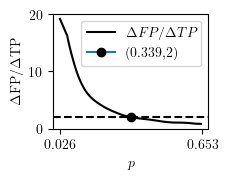

y_proba unique =  [-0.02496637 -0.0216331  -0.02114706 ...  1.18181959  1.18845095
  1.19430105]
y_proba unique =  [0.         0.0000003  0.00000471 ... 0.99956841 0.99962098 1.        ]
M, m, left, right =  0.7499688765417653 0.18733881358477011 0.3126611864152299 0.24996887654176525
Plot_Prediction()
LRC_Medium_Tomek_1_alpha_0_5_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


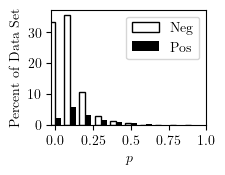


ROC()
LRC_Medium_Tomek_1_alpha_0_5_v1
p_values =  []


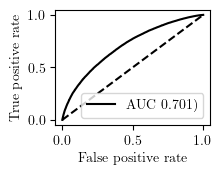


Evaluate_Model()
np.unique(y_proba) =  [0.01105035 0.01313472 0.01343864 ... 0.76568061 0.76982734 0.77348554]
np.unique(y_pred) =  [0 1]
[[149307   1464]
 [ 25166   1455]]

[[0.84167832 0.00825291]
 [0.1418666  0.00820217]]

0.498 & Precision \cr 
0.055 & Recall \cr 
0.099 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_1_alpha_0_5_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


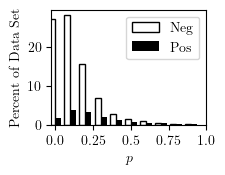


ROC()
LRC_Medium_Tomek_1_alpha_0_5_v1_Linear_Transform
p_values =  []


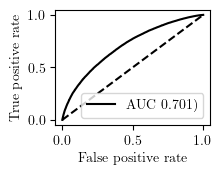


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0000003  0.00000471 ... 0.99956841 0.99962098 1.        ]
np.unique(y_pred) =  [0 1]
[[144061   6710]
 [ 21926   4695]]

[[0.81210539 0.03782583]
 [0.12360197 0.02646681]]

0.412 & Precision \cr 
0.176 & Recall \cr 
0.247 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_1_alpha_target_v1
Balance_Proba
LRC_Medium_Tomek_1_alpha_target_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.05047483644234427 0.7925421050287228
center =  0.5105565429658989

Plot FP/TP


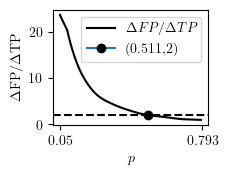

y_proba unique =  [-0.03293399 -0.02749452 -0.02746718 ...  0.89296033  0.89664158
  0.90205703]
y_proba unique =  [0.         0.00000016 0.00004173 ... 0.89296033 0.89664158 0.90205703]
M, m, left, right =  0.7334127346877151 0.04097553332844056 0.45902446667155944 0.23341273468771506
Plot_Prediction()
LRC_Medium_Tomek_1_alpha_target_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


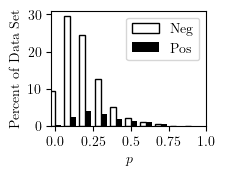


ROC()
LRC_Medium_Tomek_1_alpha_target_v1
p_values =  []


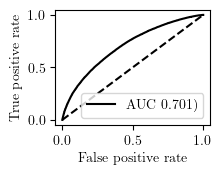


Evaluate_Model()
np.unique(y_proba) =  [0.02129706 0.02629076 0.02631586 ... 0.87131336 0.87469292 0.87966457]
np.unique(y_pred) =  [0 1]
[[143629   7142]
 [ 21709   4912]]

[[0.80967011 0.04026112]
 [0.12237869 0.02769009]]

0.407 & Precision \cr 
0.185 & Recall \cr 
0.254 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_1_alpha_target_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


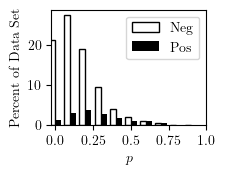


ROC()
LRC_Medium_Tomek_1_alpha_target_v1_Linear_Transform
p_values =  []


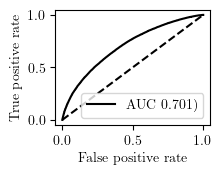


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000016 0.00004173 ... 0.89296033 0.89664158 0.90205703]
np.unique(y_pred) =  [0 1]
[[144163   6608]
 [ 21988   4633]]

[[0.81268039 0.03725083]
 [0.12395147 0.0261173 ]]

0.412 & Precision \cr 
0.174 & Recall \cr 
0.245 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_1_alpha_balanced_v1
Balance_Proba
LRC_Medium_Tomek_1_alpha_balanced_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.12701822828517975 0.9155687059088803
center =  0.7499731056079032

Plot FP/TP


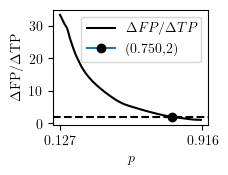

y_proba unique =  [-0.06006856 -0.04943688 -0.04656777 ...  0.66247502  0.66378957
  0.66714865]
y_proba unique =  [0.         0.00001128 0.00003198 ... 0.66247502 0.66378957 0.66714865]
M, m, left, right =  0.641603603551531 -0.12080665987718331 0.6208066598771833 0.141603603551531
Plot_Prediction()
LRC_Medium_Tomek_1_alpha_balanced_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


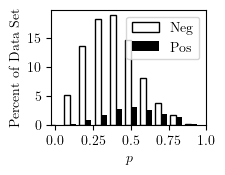


ROC()
LRC_Medium_Tomek_1_alpha_balanced_v1
p_values =  []


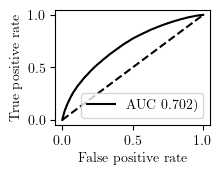


Evaluate_Model()
np.unique(y_proba) =  [0.05458452 0.06778496 0.07134728 ... 0.95170426 0.95333642 0.9575071 ]
np.unique(y_pred) =  [0 1]
[[99910 50861]
 [ 9964 16657]]

[[0.56321593 0.2867153 ]
 [0.05616939 0.09389939]]

0.247 & Precision \cr 
0.626 & Recall \cr 
0.354 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_1_alpha_balanced_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


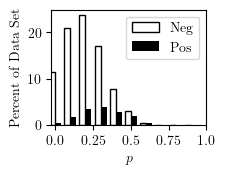


ROC()
LRC_Medium_Tomek_1_alpha_balanced_v1_Linear_Transform
p_values =  []


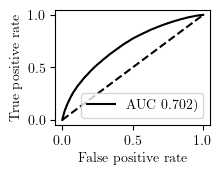


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00001128 0.00003198 ... 0.66247502 0.66378957 0.66714865]
np.unique(y_pred) =  [0 1]
[[144470   6301]
 [ 22150   4471]]

[[0.81441102 0.0355202 ]
 [0.12486471 0.02520407]]

0.415 & Precision \cr 
0.168 & Recall \cr 
0.239 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_1_alpha_0_5_v1


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_1_alpha_0_5_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03833333333333334 0.98
center =  0.78225

Plot FP/TP


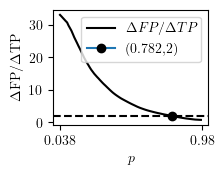

y_proba unique =  [-0.0269451  -0.02526103 -0.02502045 ...  0.64331425  0.64443696
  0.64668238]
y_proba unique =  [0.         0.00096232 0.00112271 ... 0.64331425 0.64443696 0.64668238]
M, m, left, right =  0.6597500000000001 -0.24224999999999997 0.74225 0.15975000000000006
Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_0_5_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


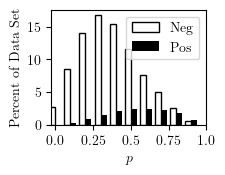


ROC()
BRFC_Medium_Tomek_1_alpha_0_5_v1
p_values =  []


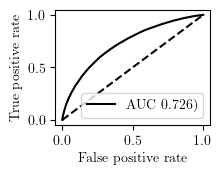


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0025     0.00285714 ... 0.995      0.99666667 1.        ]
np.unique(y_pred) =  [0 1]
[[101999  48772]
 [  9160  17461]]

[[0.57499211 0.27493912]
 [0.05163705 0.09843172]]

0.264 & Precision \cr 
0.656 & Recall \cr 
0.376 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_0_5_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


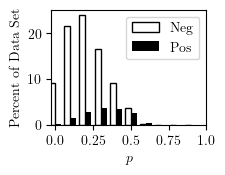


ROC()
BRFC_Medium_Tomek_1_alpha_0_5_v1_Linear_Transform
p_values =  []


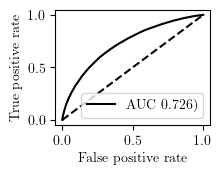


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00096232 0.00112271 ... 0.64331425 0.64443696 0.64668238]
np.unique(y_pred) =  [0 1]
[[143808   6963]
 [ 21053   5568]]

[[0.81067917 0.03925205]
 [0.11868066 0.03138811]]

0.444 & Precision \cr 
0.209 & Recall \cr 
0.284 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_1_alpha_target_v1


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_1_alpha_target_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.038 0.98
center =  0.78218

Plot FP/TP


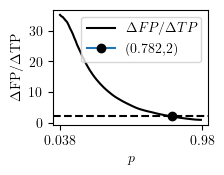

y_proba unique =  [-0.02694764 -0.024702   -0.02425288 ...  0.64449774  0.645396
  0.64674338]
y_proba unique =  [0.         0.00004812 0.00044913 ... 0.64449774 0.645396   0.64674338]
M, m, left, right =  0.6644866666666666 -0.24217999999999995 0.74218 0.16448666666666656
Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_target_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


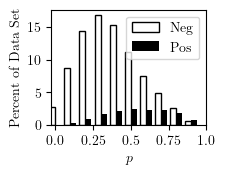


ROC()
BRFC_Medium_Tomek_1_alpha_target_v1
p_values =  []


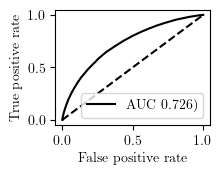


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00333333 0.004      ... 0.99666667 0.998      1.        ]
np.unique(y_pred) =  [0 1]
[[103110  47661]
 [  9311  17310]]

[[0.58125507 0.26867615]
 [0.05248827 0.0975805 ]]

0.266 & Precision \cr 
0.650 & Recall \cr 
0.378 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_target_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


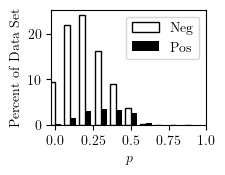


ROC()
BRFC_Medium_Tomek_1_alpha_target_v1_Linear_Transform
p_values =  []


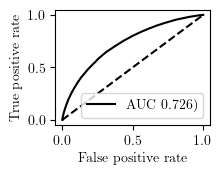


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00004812 0.00044913 ... 0.64449774 0.645396   0.64674338]
np.unique(y_pred) =  [0 1]
[[143492   7279]
 [ 21057   5564]]

[[0.80889781 0.04103342]
 [0.11870321 0.03136556]]

0.433 & Precision \cr 
0.209 & Recall \cr 
0.282 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_1_alpha_balanced_v1


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_1_alpha_balanced_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.04 0.98
center =  0.792

Plot FP/TP


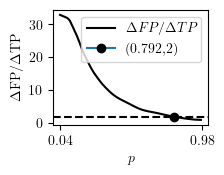

y_proba unique =  [-0.02659574 -0.0217087  -0.0209623  ...  0.63774814  0.637921
  0.63829787]
y_proba unique =  [0.         0.00192412 0.00210141 ... 0.63774814 0.637921   0.63829787]
M, m, left, right =  0.6579999999999999 -0.252 0.752 0.15799999999999992
Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_balanced_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


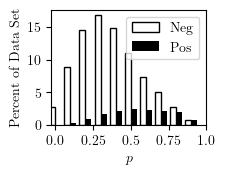


ROC()
BRFC_Medium_Tomek_1_alpha_balanced_v1
p_values =  []


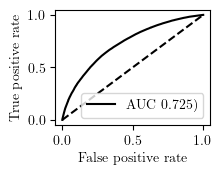


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00735011 0.00847269 ... 0.99917321 0.99943318 1.        ]
np.unique(y_pred) =  [0 1]
[[102668  48103]
 [  9283  17338]]

[[0.57876342 0.27116781]
 [0.05233043 0.09773834]]

0.265 & Precision \cr 
0.651 & Recall \cr 
0.377 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_balanced_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


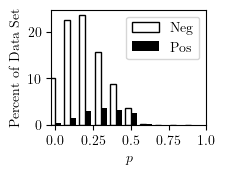


ROC()
BRFC_Medium_Tomek_1_alpha_balanced_v1_Linear_Transform
p_values =  []


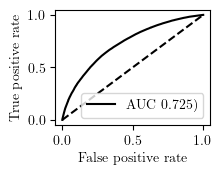


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00192412 0.00210141 ... 0.63774814 0.637921   0.63829787]
np.unique(y_pred) =  [0 1]
[[143632   7139]
 [ 21237   5384]]

[[0.80968702 0.0402442 ]
 [0.11971791 0.03035086]]

0.430 & Precision \cr 
0.202 & Recall \cr 
0.275 & F1 \cr 



------------------------------------------
AdaBoost()  AdaBoost_Medium_Tomek_1_v1
Balance_Proba
AdaBoost_Medium_Tomek_1_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.49094662492829544 0.501572546907727
center =  0.49849102953369184

Plot FP/TP


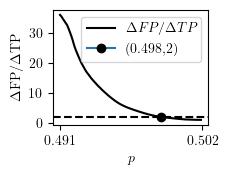

y_proba unique =  [-0.15458288 -0.11884828 -0.11172328 ...  0.79704929  0.80062327
  0.81303793]
y_proba unique =  [0.         0.00000311 0.00000455 ... 0.79704929 0.80062327 0.81303793]
M, m, left, right =  0.5024044025585875 0.49250303101838006 0.007496968981619945 0.0024044025585875373
Plot_Prediction()
AdaBoost_Medium_Tomek_1_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


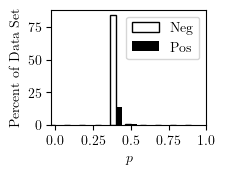


ROC()
AdaBoost_Medium_Tomek_1_v1
p_values =  []


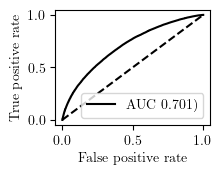


Evaluate_Model()
np.unique(y_proba) =  [0.48867625 0.48921206 0.48931889 ... 0.50294497 0.50299856 0.5031847 ]
np.unique(y_pred) =  [0 1]
[[149290   1481]
 [ 25150   1471]]

[[0.84158248 0.00834874]
 [0.1417764  0.00829237]]

0.498 & Precision \cr 
0.055 & Recall \cr 
0.099 & F1 \cr 

Plot_Prediction()
AdaBoost_Medium_Tomek_1_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


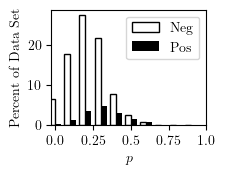


ROC()
AdaBoost_Medium_Tomek_1_v1_Linear_Transform
p_values =  []


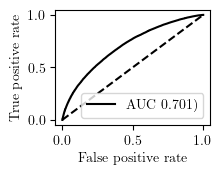


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000311 0.00000455 ... 0.79704929 0.80062327 0.81303793]
np.unique(y_pred) =  [0 1]
[[144877   5894]
 [ 22335   4286]]

[[0.81670538 0.03322585]
 [0.12590759 0.02416118]]

0.421 & Precision \cr 
0.161 & Recall \cr 
0.233 & F1 \cr 



------------------------------------------
Bagging()  Bagging_Medium_Tomek_1_v1
Balance_Proba
Bagging_Medium_Tomek_1_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.0 1.0
center =  0.81

Plot FP/TP


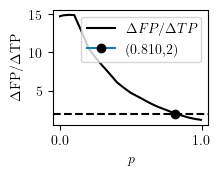

y_proba unique =  [0.         0.01028807 0.01234568 0.0154321  0.01763668 0.02057613
 0.02314815 0.02469136 0.02572016 0.02645503 0.02777778 0.0308642
 0.03527337 0.03600823 0.03703704 0.04115226 0.04409171 0.04526749
 0.0462963  0.04801097 0.04938272 0.05144033 0.05291005 0.05555556
 0.05761317 0.05864198 0.05952381 0.0617284  0.06584362 0.06613757
 0.06687243 0.06790123 0.06995885 0.07098765 0.07201646 0.07363316
 0.07407407 0.07495591 0.07716049 0.0781893  0.07936508 0.08230453
 0.08333333 0.08367627 0.08524397 0.08641975 0.08744856 0.08818342
 0.08916324 0.08950617 0.09053498 0.09215168 0.09259259 0.09259259
 0.09293553 0.09465021 0.09567901 0.09602195 0.09700176 0.09773663
 0.09876543 0.0994513  0.10030864 0.10185185 0.10288066 0.10390947
 0.10493827 0.10582011 0.10699588 0.10728983 0.10758377 0.10802469
 0.10949442 0.11111111 0.11316872 0.11419753 0.11463845 0.11522634
 0.11574074 0.11659808 0.11728395 0.11831276 0.11934156 0.12037037
 0.12088477 0.12139918 0.12345679 0.1255144  

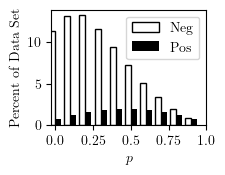


ROC()
Bagging_Medium_Tomek_1_v1
p_values =  []


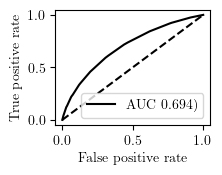


Evaluate_Model()
np.unique(y_proba) =  [0.         0.01666667 0.02       0.025      0.02857143 0.03333333
 0.0375     0.04       0.04166667 0.04285714 0.045      0.05
 0.05714286 0.05833333 0.06       0.06666667 0.07142857 0.07333333
 0.075      0.07777778 0.08       0.08333333 0.08333333 0.08571429
 0.09       0.09333333 0.095      0.09642857 0.1        0.10666667
 0.10714286 0.10833333 0.11       0.11333333 0.115      0.11666667
 0.11666667 0.11928571 0.12       0.12142857 0.125      0.12666667
 0.12857143 0.13333333 0.13333333 0.135      0.13555556 0.13809524
 0.14       0.14166667 0.14285714 0.14444444 0.145      0.14666667
 0.14928571 0.15       0.15       0.15055556 0.15333333 0.155
 0.15555556 0.15555556 0.15714286 0.15833333 0.15833333 0.16
 0.16111111 0.1625     0.165      0.16666667 0.16833333 0.17
 0.17142857 0.17333333 0.17333333 0.17380952 0.17428571 0.175
 0.17738095 0.18       0.18333333 0.18333333 0.185      0.18571429
 0.18666667 0.1875     0.18888889 0.19       0.191

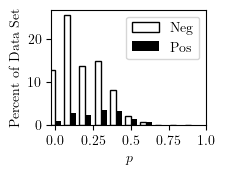


ROC()
Bagging_Medium_Tomek_1_v1_Linear_Transform
p_values =  []


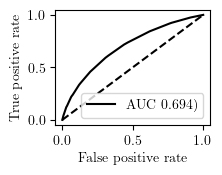


Evaluate_Model()
np.unique(y_proba) =  [0.         0.01028807 0.01234568 0.0154321  0.01763668 0.02057613
 0.02314815 0.02469136 0.02572016 0.02645503 0.02777778 0.0308642
 0.03527337 0.03600823 0.03703704 0.04115226 0.04409171 0.04526749
 0.0462963  0.04801097 0.04938272 0.05144033 0.05291005 0.05555556
 0.05761317 0.05864198 0.05952381 0.0617284  0.06584362 0.06613757
 0.06687243 0.06790123 0.06995885 0.07098765 0.07201646 0.07363316
 0.07407407 0.07495591 0.07716049 0.0781893  0.07936508 0.08230453
 0.08333333 0.08367627 0.08524397 0.08641975 0.08744856 0.08818342
 0.08916324 0.08950617 0.09053498 0.09215168 0.09259259 0.09259259
 0.09293553 0.09465021 0.09567901 0.09602195 0.09700176 0.09773663
 0.09876543 0.0994513  0.10030864 0.10185185 0.10288066 0.10390947
 0.10493827 0.10582011 0.10699588 0.10728983 0.10758377 0.10802469
 0.10949442 0.11111111 0.11316872 0.11419753 0.11463845 0.11522634
 0.11574074 0.11659808 0.11728395 0.11831276 0.11934156 0.12037037
 0.12088477 0.12139918 

Balance_Proba
RUSBoost_Medium_Tomek_1_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.49968407327747155 0.5007660649145093
center =  0.5004522873397683

Plot FP/TP


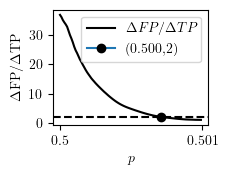

y_proba unique =  [-0.15943908 -0.11561592 -0.10800736 ...  0.79608157  0.79754918
  0.80157871]
y_proba unique =  [0.         0.00000097 0.00004207 ... 0.79608157 0.79754918 0.80157871]
M, m, left, right =  0.5002454171550242 0.4992374791939173 0.0007625208060826894 0.0002454171550242412
Plot_Prediction()
RUSBoost_Medium_Tomek_1_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


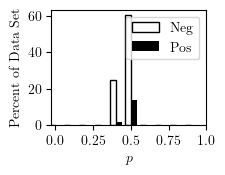


ROC()
RUSBoost_Medium_Tomek_1_v1
p_values =  []


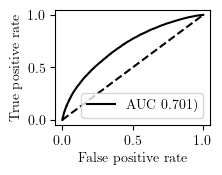


Evaluate_Model()
np.unique(y_proba) =  [0.49944662 0.49951345 0.49952505 ... 0.50090382 0.50090606 0.50091221]
np.unique(y_pred) =  [0 1]
[[ 43698 107073]
 [  2611  24010]]

[[0.2463358  0.60359543]
 [0.01471881 0.13534996]]

0.183 & Precision \cr 
0.902 & Recall \cr 
0.304 & F1 \cr 

Plot_Prediction()
RUSBoost_Medium_Tomek_1_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


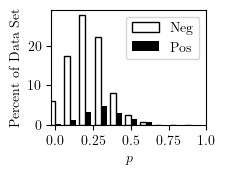


ROC()
RUSBoost_Medium_Tomek_1_v1_Linear_Transform
p_values =  []


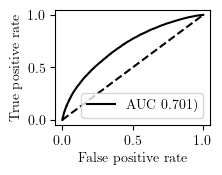


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000097 0.00004207 ... 0.79608157 0.79754918 0.80157871]
np.unique(y_pred) =  [0 1]
[[144766   6005]
 [ 22290   4331]]

[[0.81607964 0.03385158]
 [0.12565392 0.02441486]]

0.419 & Precision \cr 
0.163 & Recall \cr 
0.234 & F1 \cr 



------------------------------------------
Easy Ensemble Classifier  EEC_Medium_Tomek_1_v1
Balance_Proba
EEC_Medium_Tomek_1_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.45605562770092256 0.5546923207043267
center =  0.5280604135934076

Plot FP/TP


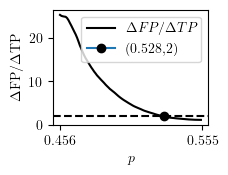

y_proba unique =  [0.         0.00474662 0.02231476 0.02237105 0.0270733  0.02712959
 0.04170696 0.04646265 0.05006275 0.05011904 0.05041934 0.0522426
 0.05482129 0.05487758 0.05517788 0.05607523 0.05700031 0.06083377
 0.0640621  0.06411848 0.06613855 0.06882777 0.06888416 0.07460628
 0.0746627  0.07937348 0.0794299  0.08857027 0.0918599  0.09191629
 0.09221723 0.09404362 0.09662558 0.09668197 0.0969829  0.09788241
 0.09880861 0.09883117 0.09982177 0.10241541 0.10247183 0.10264808
 0.10277346 0.10358971 0.10458886 0.10718261 0.10723903 0.10754066
 0.10796131 0.10844073 0.11320793 0.11453965 0.11633631 0.11639276
 0.1164397  0.1164962  0.11669537 0.11852311 0.11930731 0.12121223
 0.12126873 0.12236504 0.12667848 0.13042334 0.13143702 0.13694855
 0.1370051  0.14069746 0.14093475 0.14099131 0.14169165 0.14172291
 0.14177946 0.14428842 0.14434492 0.1446472  0.14546314 0.14646409
 0.14906095 0.14911745 0.14941973 0.15032166 0.15126826 0.15226336
 0.15509419 0.15603546 0.15642784 0.15703689 

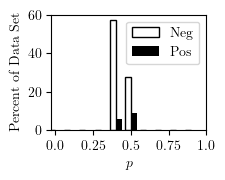


ROC()
EEC_Medium_Tomek_1_v1
p_values =  []


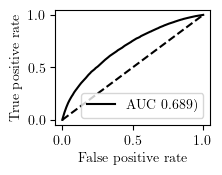


Evaluate_Model()
np.unique(y_proba) =  [0.45605563 0.45673919 0.45926917 0.45927727 0.45995444 0.45996255
 0.46206183 0.46274669 0.46326514 0.46327325 0.4633165  0.46357906
 0.46395042 0.46395852 0.46400177 0.464131   0.46426422 0.46481627
 0.46528118 0.4652893  0.46558021 0.46596749 0.46597561 0.46679965
 0.46680777 0.46748617 0.46749429 0.46881059 0.46928433 0.46929245
 0.46933579 0.46959881 0.46997064 0.46997876 0.47002209 0.47015163
 0.47028501 0.47028826 0.47043092 0.47080443 0.47081255 0.47083793
 0.47085599 0.47097354 0.47111742 0.47149095 0.47149907 0.47154251
 0.47160309 0.47167213 0.47235865 0.47255043 0.47280917 0.4728173
 0.47282406 0.4728322  0.47286088 0.47312409 0.47323702 0.47351135
 0.47351949 0.47367736 0.47429854 0.47483784 0.47498382 0.47577753
 0.47578567 0.47631741 0.47635158 0.47635973 0.47646058 0.47646508
 0.47647323 0.47683454 0.47684268 0.47688621 0.47700371 0.47714786
 0.47752183 0.47752997 0.4775735  0.47770339 0.4778397  0.47798301
 0.47839068 0.47852623 

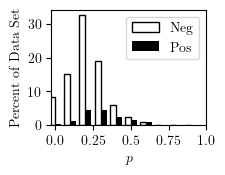


ROC()
EEC_Medium_Tomek_1_v1_Linear_Transform
p_values =  []


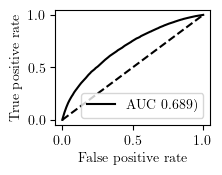


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00474662 0.02231476 0.02237105 0.0270733  0.02712959
 0.04170696 0.04646265 0.05006275 0.05011904 0.05041934 0.0522426
 0.05482129 0.05487758 0.05517788 0.05607523 0.05700031 0.06083377
 0.0640621  0.06411848 0.06613855 0.06882777 0.06888416 0.07460628
 0.0746627  0.07937348 0.0794299  0.08857027 0.0918599  0.09191629
 0.09221723 0.09404362 0.09662558 0.09668197 0.0969829  0.09788241
 0.09880861 0.09883117 0.09982177 0.10241541 0.10247183 0.10264808
 0.10277346 0.10358971 0.10458886 0.10718261 0.10723903 0.10754066
 0.10796131 0.10844073 0.11320793 0.11453965 0.11633631 0.11639276
 0.1164397  0.1164962  0.11669537 0.11852311 0.11930731 0.12121223
 0.12126873 0.12236504 0.12667848 0.13042334 0.13143702 0.13694855
 0.1370051  0.14069746 0.14093475 0.14099131 0.14169165 0.14172291
 0.14177946 0.14428842 0.14434492 0.1446472  0.14546314 0.14646409
 0.14906095 0.14911745 0.14941973 0.15032166 0.15126826 0.15226336
 0.15509419 0.15603546 

p =  5.5248897189039505
alpha_balanced =  0.8467407047351629

------------------------------------------
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v1
alpha_balanced =  0.8467407047351629
Keras_Binary_Focal_Crossentropy
alpha =  0.8467407047351629
y_proba unique
[0.00461212 0.00588014 0.00703518 ... 0.98189133 0.98202884 0.9857276 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.09570415504276752 0.9680874586105348
center =  0.8721252952180805

Plot FP/TP


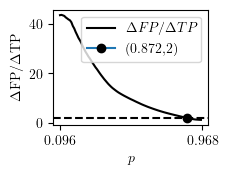

y_proba unique =  [-0.06319284 -0.0623697  -0.06161982 ...  0.5712606   0.5713498
  0.5737511 ]
y_proba unique =  [0.         0.00000444 0.0000129  ... 0.5712606  0.5713498  0.5737511 ]
M, m, left, right =  0.5820190152525903 -0.27017413079738617 0.7701741307973862 0.08201901525259025
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


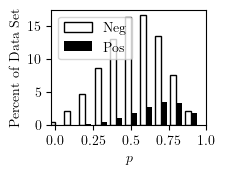


ROC()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v1
p_values =  []


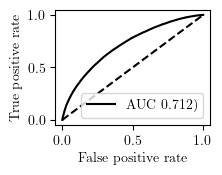


Evaluate_Model()
np.unique(y_proba) =  [0.00461212 0.00588014 0.00703518 ... 0.98189133 0.98202884 0.9857276 ]
np.unique(y_pred) =  [0 1]
[[51492 99279]
 [ 3113 23508]]

[[0.29027239 0.55965883]
 [0.01754871 0.13252007]]

0.191 & Precision \cr 
0.883 & Recall \cr 
0.315 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


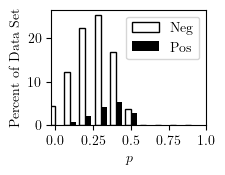


ROC()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v1_Linear_Transform
p_values =  []


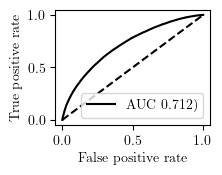


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000444 0.0000129  ... 0.5712606  0.5713498  0.5737511 ]
np.unique(y_pred) =  [0 1]
[[144216   6555]
 [ 21743   4878]]

[[0.81297916 0.03695206]
 [0.12257035 0.02749842]]

0.427 & Precision \cr 
0.183 & Recall \cr 
0.256 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.00302192 0.00347664 0.00395576 ... 0.9646426  0.9646644  0.97413164]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.043165603652596474 0.9242444932460787
center =  0.712785559743643

Plot FP/TP


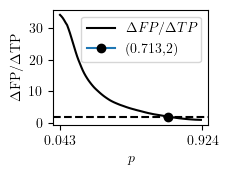

y_proba unique =  [-0.03185117 -0.03151041 -0.03115135 ...  0.6887255   0.6887418
  0.69583595]
y_proba unique =  [0.         0.00000036 0.00001702 ... 0.6887255  0.6887418  0.69583595]
M, m, left, right =  0.6738440820574781 -0.16725779175758362 0.6672577917575836 0.17384408205747814
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


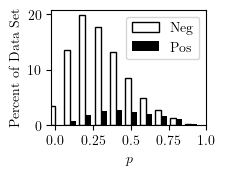


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v1
p_values =  []


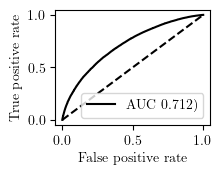


Evaluate_Model()
np.unique(y_proba) =  [0.00302192 0.00347664 0.00395576 ... 0.9646426  0.9646644  0.97413164]
np.unique(y_pred) =  [0 1]
[[120004  30767]
 [ 13652  12969]]

[[0.67649048 0.17344074]
 [0.0769595  0.07310927]]

0.297 & Precision \cr 
0.487 & Recall \cr 
0.369 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


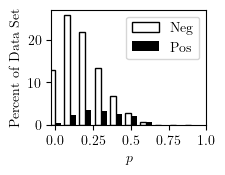


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v1_Linear_Transform
p_values =  []


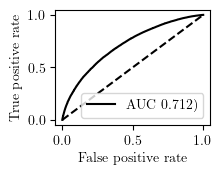


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000036 0.00001702 ... 0.6887255  0.6887418  0.69583595]
np.unique(y_pred) =  [0 1]
[[144408   6363]
 [ 21771   4850]]

[[0.81406151 0.03586971]
 [0.1227282  0.02734058]]

0.433 & Precision \cr 
0.182 & Recall \cr 
0.256 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.5
y_proba unique
[0.00331733 0.0038879  0.0040355  ... 0.9344082  0.9344472  0.9447421 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.02679028669372201 0.8514302909374238
center =  0.5298206892823801

Plot FP/TP


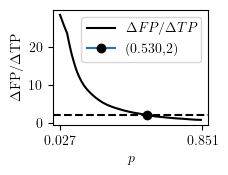

y_proba unique =  [-0.02475047 -0.02418184 -0.02403468 ...  0.90324056  0.9032794
  0.91354   ]
y_proba unique =  [0.         0.00000006 0.00000271 ... 0.90324056 0.9032794  0.91354   ]
M, m, left, right =  0.7587996646761915 -0.001670175790786743 0.5016701757907868 0.25879966467619153
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


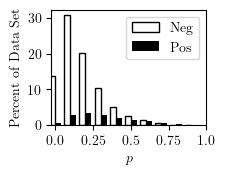


ROC()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v1
p_values =  []


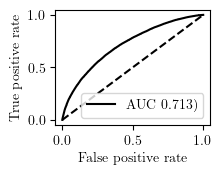


Evaluate_Model()
np.unique(y_proba) =  [0.00331733 0.0038879  0.0040355  ... 0.9344082  0.9344472  0.9447421 ]
np.unique(y_pred) =  [0 1]
[[142311   8460]
 [ 20708   5913]]

[[0.80224024 0.04769099]
 [0.11673582 0.03333296]]

0.411 & Precision \cr 
0.222 & Recall \cr 
0.288 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


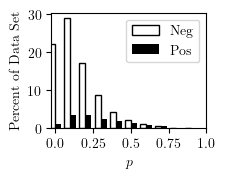


ROC()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v1_Linear_Transform
p_values =  []


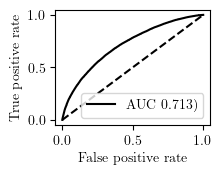


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000006 0.00000271 ... 0.90324056 0.9032794  0.91354   ]
np.unique(y_pred) =  [0 1]
[[144038   6733]
 [ 21481   5140]]

[[0.81197574 0.03795549]
 [0.1210934  0.02897538]]

0.433 & Precision \cr 
0.193 & Recall \cr 
0.267 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.01506533 0.01803418 0.02168014 ... 0.9202864  0.92119956 0.92819554]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.09220759235322476 0.8561150014400484
center =  0.6574990750774742

Plot FP/TP


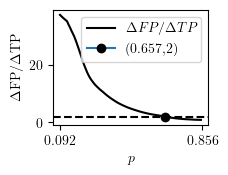

y_proba unique =  [-0.07238281 -0.06973767 -0.06648928 ...  0.734133    0.7349466
  0.7411797 ]
y_proba unique =  [0.         0.0000006  0.00002751 ... 0.734133   0.7349466  0.7411797 ]
M, m, left, right =  0.6554806497693075 -0.06119238138198853 0.5611923813819886 0.15548064976930753
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


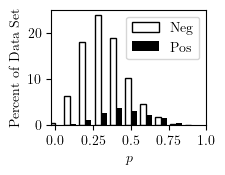


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v1
p_values =  []


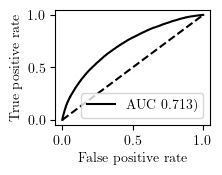


Evaluate_Model()
np.unique(y_proba) =  [0.01506533 0.01803418 0.02168014 ... 0.9202864  0.92119956 0.92819554]
np.unique(y_pred) =  [0 1]
[[120632  30139]
 [ 13726  12895]]

[[0.68003067 0.16990056]
 [0.07737666 0.07269212]]

0.300 & Precision \cr 
0.484 & Recall \cr 
0.370 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


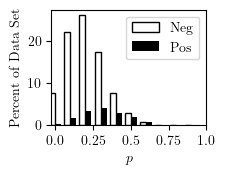


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v1_Linear_Transform
p_values =  []


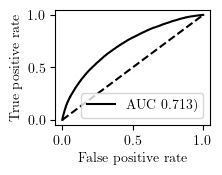


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0000006  0.00002751 ... 0.734133   0.7349466  0.7411797 ]
np.unique(y_pred) =  [0 1]
[[144295   6476]
 [ 21696   4925]]

[[0.81342451 0.03650672]
 [0.1223054  0.02776337]]

0.432 & Precision \cr 
0.185 & Recall \cr 
0.259 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.02579039 0.04195467 0.04244723 ... 0.8729926  0.8756235  0.88230616]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.14514867812395096 0.7983754992485047
center =  0.6220042575448752

Plot FP/TP


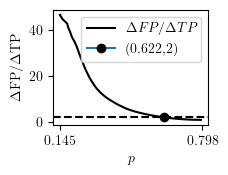

y_proba unique =  [-0.1305446  -0.11344957 -0.11292863 ...  0.7654405   0.7682229
  0.77529037]
y_proba unique =  [0.         0.00000322 0.00000468 ... 0.7654405  0.7682229  0.77529037]
M, m, left, right =  0.6387741044163721 0.027223040759563447 0.47277695924043656 0.13877410441637206
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


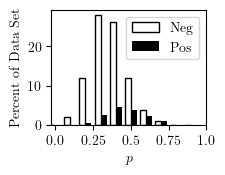


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v1
p_values =  []


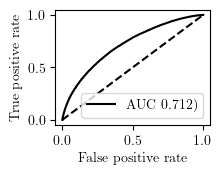


Evaluate_Model()
np.unique(y_proba) =  [0.02579039 0.04195467 0.04244723 ... 0.8729926  0.8756235  0.88230616]
np.unique(y_pred) =  [0 1]
[[120866  29905]
 [ 13869  12752]]

[[0.68134978 0.16858145]
 [0.07818278 0.07188599]]

0.299 & Precision \cr 
0.479 & Recall \cr 
0.368 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


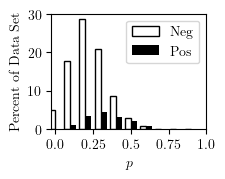


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v1_Linear_Transform
p_values =  []


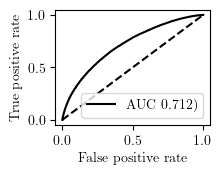


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000322 0.00000468 ... 0.7654405  0.7682229  0.77529037]
np.unique(y_pred) =  [0 1]
[[144281   6490]
 [ 21707   4914]]

[[0.81334558 0.03658564]
 [0.12236741 0.02770136]]

0.431 & Precision \cr 
0.185 & Recall \cr 
0.258 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.05028758 0.06001062 0.06623306 ... 0.7759891  0.77927804 0.8346275 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.21808197274804114 0.7094352602958682
center =  0.5816834055334332

Plot FP/TP


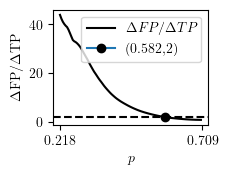

y_proba unique =  [-0.24119449 -0.22763276 -0.21895367 ...  0.771019    0.7756064
  0.8528082 ]
y_proba unique =  [0.         0.00000024 0.00008881 ... 0.771019   0.7756064  0.8528082 ]
M, m, left, right =  0.5991735458374023 0.14152743488550187 0.3584725651144981 0.09917354583740234
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


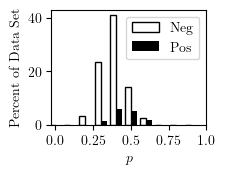


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v1
p_values =  []


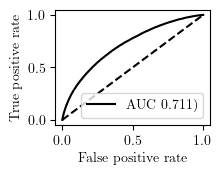


Evaluate_Model()
np.unique(y_proba) =  [0.05028758 0.06001062 0.06623306 ... 0.7759891  0.77927804 0.8346275 ]
np.unique(y_pred) =  [0 1]
[[120850  29921]
 [ 13832  12789]]

[[0.68125958 0.16867164]
 [0.0779742  0.07209457]]

0.299 & Precision \cr 
0.480 & Recall \cr 
0.369 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


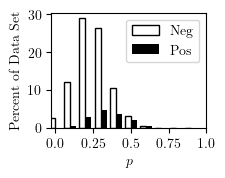


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v1_Linear_Transform
p_values =  []


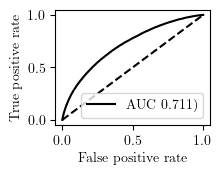


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000024 0.00008881 ... 0.771019   0.7756064  0.8528082 ]
np.unique(y_pred) =  [0 1]
[[144157   6614]
 [ 21641   4980]]

[[0.81264657 0.03728466]
 [0.12199535 0.02807342]]

0.430 & Precision \cr 
0.187 & Recall \cr 
0.261 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v1
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.17709692 0.19235222 0.20113926 ... 0.6504466  0.65631413 0.6589329 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.34560455083847047 0.6045626103878023
center =  0.5398230955004694

Plot FP/TP


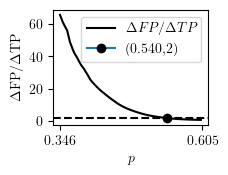

y_proba unique =  [-0.45016015 -0.41019887 -0.38718122 ...  0.7897779   0.8051479
  0.8120078 ]
y_proba unique =  [0.         0.00000316 0.00027594 ... 0.7897779  0.8051479  0.8120078 ]
M, m, left, right =  0.5482182192802432 0.3091236408054829 0.19087635919451712 0.04821821928024317
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


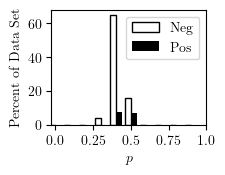


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v1
p_values =  []


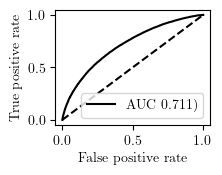


Evaluate_Model()
np.unique(y_proba) =  [0.17709692 0.19235222 0.20113926 ... 0.6504466  0.65631413 0.6589329 ]
np.unique(y_pred) =  [0 1]
[[122520  28251]
 [ 14149  12472]]

[[0.69067376 0.15925746]
 [0.07976121 0.07030757]]

0.306 & Precision \cr 
0.469 & Recall \cr 
0.370 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


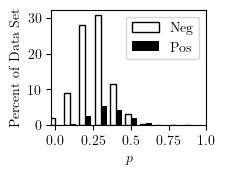


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v1_Linear_Transform
p_values =  []


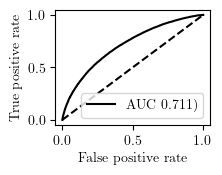


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000316 0.00027594 ... 0.7897779  0.8051479  0.8120078 ]
np.unique(y_pred) =  [0 1]
[[144685   6086]
 [ 21957   4664]]

[[0.81562303 0.0343082 ]
 [0.12377672 0.02629205]]

0.434 & Precision \cr 
0.175 & Recall \cr 
0.250 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_2_alpha_0_5_v1
Balance_Proba
LRC_Medium_Tomek_2_alpha_0_5_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.026029937700975597 0.6574171365387493
center =  0.3417235371198625

Plot FP/TP


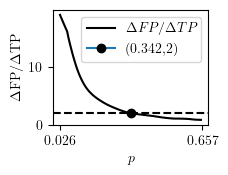

y_proba unique =  [-0.02478408 -0.02138767 -0.02098051 ...  1.17896965  1.18728267
  1.18956211]
y_proba unique =  [0.         0.00000001 0.00001034 ... 0.99978701 0.99987017 1.        ]
M, m, left, right =  0.7522930233135977 0.18487823777165965 0.3151217622283403 0.2522930233135977
Plot_Prediction()
LRC_Medium_Tomek_2_alpha_0_5_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


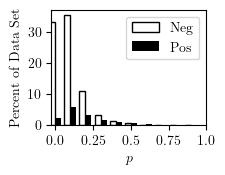


ROC()
LRC_Medium_Tomek_2_alpha_0_5_v1
p_values =  []


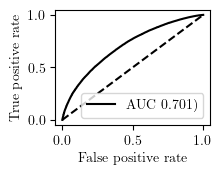


Evaluate_Model()
np.unique(y_proba) =  [0.01098177 0.01312234 0.01337894 ... 0.76963976 0.77487899 0.77631559]
np.unique(y_pred) =  [0 1]
[[149239   1532]
 [ 25099   1522]]

[[0.84129499 0.00863624]
 [0.14148891 0.00857987]]

0.498 & Precision \cr 
0.057 & Recall \cr 
0.103 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_2_alpha_0_5_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


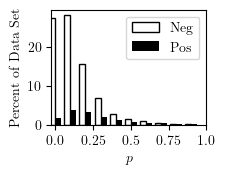


ROC()
LRC_Medium_Tomek_2_alpha_0_5_v1_Linear_Transform
p_values =  []


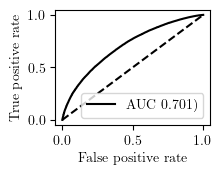


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000001 0.00001034 ... 0.99978701 0.99987017 1.        ]
np.unique(y_pred) =  [0 1]
[[144048   6723]
 [ 21921   4700]]

[[0.81203211 0.03789912]
 [0.12357378 0.02649499]]

0.411 & Precision \cr 
0.177 & Recall \cr 
0.247 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_2_alpha_target_v1
Balance_Proba
LRC_Medium_Tomek_2_alpha_target_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.050391689962721094 0.7961512400399204
center =  0.5127626110105846

Plot FP/TP


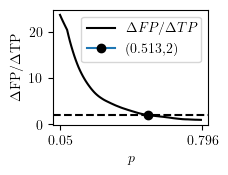

y_proba unique =  [-0.03269857 -0.02738101 -0.02716156 ...  0.89115906  0.89565171
  0.89935323]
y_proba unique =  [0.         0.00000067 0.00002289 ... 0.89115906 0.89565171 0.89935323]
M, m, left, right =  0.7345630054858501 0.03861040083614282 0.4613895991638572 0.23456300548585007
Plot_Prediction()
LRC_Medium_Tomek_2_alpha_target_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


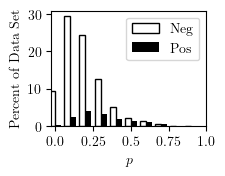


ROC()
LRC_Medium_Tomek_2_alpha_target_v1
p_values =  []


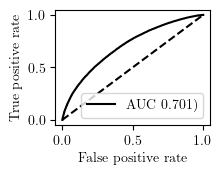


Evaluate_Model()
np.unique(y_proba) =  [0.02119945 0.02610638 0.02630889 ... 0.87371606 0.87786178 0.88127747]
np.unique(y_pred) =  [0 1]
[[143488   7283]
 [ 21621   5000]]

[[0.80887526 0.04105597]
 [0.12188261 0.02818616]]

0.407 & Precision \cr 
0.188 & Recall \cr 
0.257 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_2_alpha_target_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


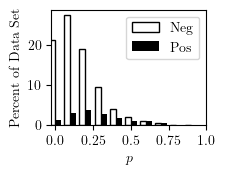


ROC()
LRC_Medium_Tomek_2_alpha_target_v1_Linear_Transform
p_values =  []


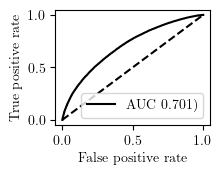


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000067 0.00002289 ... 0.89115906 0.89565171 0.89935323]
np.unique(y_pred) =  [0 1]
[[144112   6659]
 [ 21966   4655]]

[[0.81239289 0.03753833]
 [0.12382746 0.02624132]]

0.411 & Precision \cr 
0.175 & Recall \cr 
0.245 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_2_alpha_balanced_v1
Balance_Proba
LRC_Medium_Tomek_2_alpha_balanced_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.12629082357096919 0.9168504282903871
center =  0.7508329112993094

Plot FP/TP


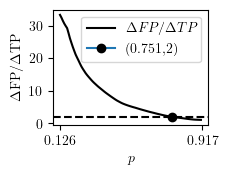

y_proba unique =  [-0.05964521 -0.04919789 -0.04606316 ...  0.66200429  0.66357789
  0.66624723]
y_proba unique =  [0.         0.00000087 0.00002255 ... 0.66200429 0.66357789 0.66624723]
M, m, left, right =  0.6420344024159136 -0.1223531349834398 0.6223531349834398 0.14203440241591359
Plot_Prediction()
LRC_Medium_Tomek_2_alpha_balanced_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


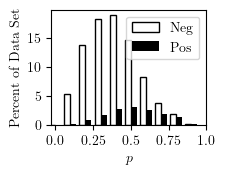


ROC()
LRC_Medium_Tomek_2_alpha_balanced_v1
p_values =  []


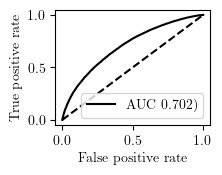


Evaluate_Model()
np.unique(y_proba) =  [0.05423901 0.06724285 0.07114467 ... 0.95248066 0.95443934 0.95776188]
np.unique(y_pred) =  [0 1]
[[99845 50926]
 [ 9949 16672]]

[[0.56284951 0.28708172]
 [0.05608483 0.09398395]]

0.247 & Precision \cr 
0.626 & Recall \cr 
0.354 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_2_alpha_balanced_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


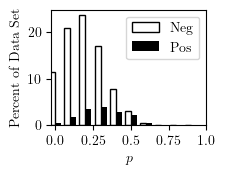


ROC()
LRC_Medium_Tomek_2_alpha_balanced_v1_Linear_Transform
p_values =  []


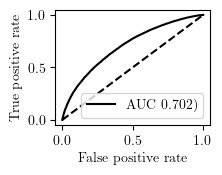


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000087 0.00002255 ... 0.66200429 0.66357789 0.66624723]
np.unique(y_pred) =  [0 1]
[[144438   6333]
 [ 22129   4492]]

[[0.81423063 0.0357006 ]
 [0.12474632 0.02532245]]

0.415 & Precision \cr 
0.169 & Recall \cr 
0.240 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_2_alpha_0_5_v1


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_2_alpha_0_5_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03570833333333335 0.98
center =  0.7722558333333334

Plot FP/TP


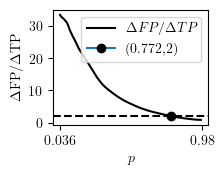

y_proba unique =  [-0.02731286 -0.02463035 -0.02458157 ...  0.65380155  0.65414296
  0.65550861]
y_proba unique =  [0.         0.00048773 0.00068282 ... 0.65380155 0.65414296 0.65550861]
M, m, left, right =  0.6738756547619049 -0.23225583333333333 0.7322558333333333 0.17387565476190492
Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_0_5_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


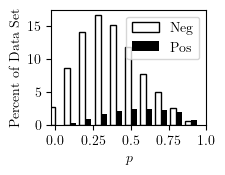


ROC()
BRFC_Medium_Tomek_2_alpha_0_5_v1
p_values =  []


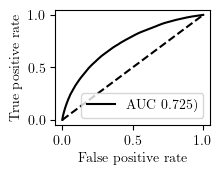


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00392857 0.004      ... 0.9975     0.998      1.        ]
np.unique(y_pred) =  [0 1]
[[101611  49160]
 [  9153  17468]]

[[0.57280486 0.27712636]
 [0.05159759 0.09847118]]

0.262 & Precision \cr 
0.656 & Recall \cr 
0.375 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_0_5_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


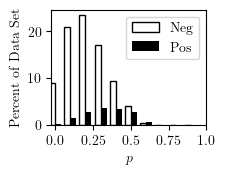


ROC()
BRFC_Medium_Tomek_2_alpha_0_5_v1_Linear_Transform
p_values =  []


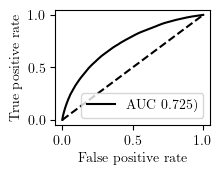


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00048773 0.00068282 ... 0.65380155 0.65414296 0.65550861]
np.unique(y_pred) =  [0 1]
[[142847   7924]
 [ 20558   6063]]

[[0.80526179 0.04466943]
 [0.11589023 0.03417854]]

0.433 & Precision \cr 
0.228 & Recall \cr 
0.299 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_2_alpha_target_v1


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_2_alpha_target_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03733333333333333 0.98
center =  0.7820400000000001

Plot FP/TP


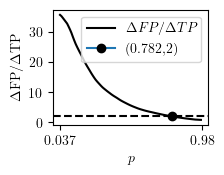

y_proba unique =  [-0.02695272 -0.02310234 -0.0224606  ...  0.64518085  0.64551776
  0.6468654 ]
y_proba unique =  [0.         0.00029947 0.00044921 ... 0.64518085 0.64551776 0.6468654 ]
M, m, left, right =  0.6679599999999999 -0.24204000000000003 0.74204 0.1679599999999999
Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_target_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


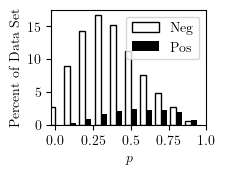


ROC()
BRFC_Medium_Tomek_2_alpha_target_v1
p_values =  []


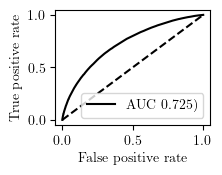


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00571429 0.00666667 ... 0.9975     0.998      1.        ]
np.unique(y_pred) =  [0 1]
[[102799  47972]
 [  9331  17290]]

[[0.57950189 0.27042933]
 [0.05260102 0.09746776]]

0.265 & Precision \cr 
0.649 & Recall \cr 
0.376 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_target_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


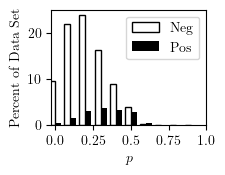


ROC()
BRFC_Medium_Tomek_2_alpha_target_v1_Linear_Transform
p_values =  []


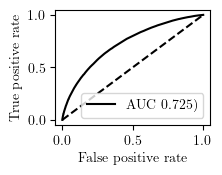


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00029947 0.00044921 ... 0.64518085 0.64551776 0.6468654 ]
np.unique(y_pred) =  [0 1]
[[143424   7347]
 [ 20976   5645]]

[[0.80851448 0.04141675]
 [0.1182466  0.03182218]]

0.434 & Precision \cr 
0.212 & Recall \cr 
0.285 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_2_alpha_balanced_v1


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_2_alpha_balanced_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.04 0.98
center =  0.7826000000000001

Plot FP/TP


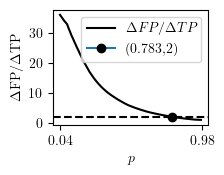

y_proba unique =  [-0.0269324  -0.02198885 -0.02163699 ...  0.64581882  0.64599448
  0.64637759]
y_proba unique =  [0.         0.00051028 0.00078454 ... 0.64581882 0.64599448 0.64637759]
M, m, left, right =  0.6673999999999999 -0.24260000000000004 0.7426 0.16739999999999988
Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_balanced_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


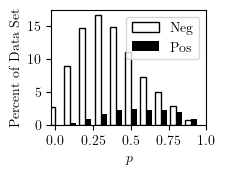


ROC()
BRFC_Medium_Tomek_2_alpha_balanced_v1
p_values =  []


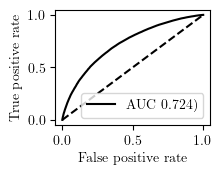


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00734215 0.00786474 ... 0.99917011 0.999431   1.        ]
np.unique(y_pred) =  [0 1]
[[102859  47912]
 [  9404  17217]]

[[0.57984013 0.2700911 ]
 [0.05301254 0.09705624]]

0.264 & Precision \cr 
0.647 & Recall \cr 
0.375 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_balanced_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


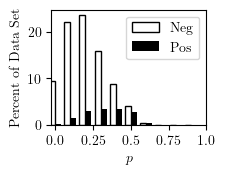


ROC()
BRFC_Medium_Tomek_2_alpha_balanced_v1_Linear_Transform
p_values =  []


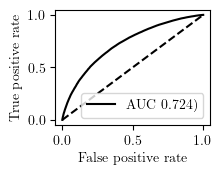


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00051028 0.00078454 ... 0.64581882 0.64599448 0.64637759]
np.unique(y_pred) =  [0 1]
[[142786   7985]
 [ 20866   5755]]

[[0.80491792 0.0450133 ]
 [0.1176265  0.03244227]]

0.419 & Precision \cr 
0.216 & Recall \cr 
0.285 & F1 \cr 



------------------------------------------
AdaBoost()  AdaBoost_Medium_Tomek_2_v1
Balance_Proba
AdaBoost_Medium_Tomek_2_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.4908831564329891 0.5016567161713982
center =  0.49853238384725956

Plot FP/TP


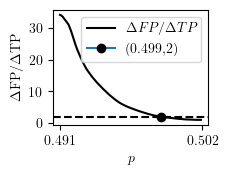

y_proba unique =  [-0.14484787 -0.11500746 -0.10643043 ...  0.79826786  0.80504359
  0.81538865]
y_proba unique =  [0.         0.         0.0000142  ... 0.79826786 0.80504359 0.81538865]
M, m, left, right =  0.5024427129688517 0.49240090599044656 0.007599094009553442 0.002442712968851679
Plot_Prediction()
AdaBoost_Medium_Tomek_2_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


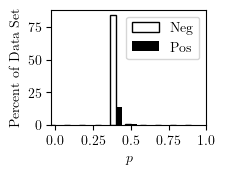


ROC()
AdaBoost_Medium_Tomek_2_v1
p_values =  []


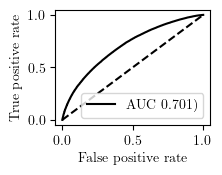


Evaluate_Model()
np.unique(y_proba) =  [0.48873186 0.48918538 0.48931574 ... 0.50306551 0.50316849 0.50332572]
np.unique(y_pred) =  [0 1]
[[149161   1610]
 [ 25059   1562]]

[[0.84085528 0.00907594]
 [0.14126342 0.00880536]]

0.492 & Precision \cr 
0.059 & Recall \cr 
0.105 & F1 \cr 

Plot_Prediction()
AdaBoost_Medium_Tomek_2_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


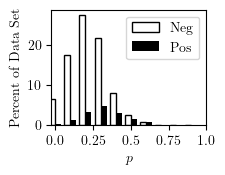


ROC()
AdaBoost_Medium_Tomek_2_v1_Linear_Transform
p_values =  []


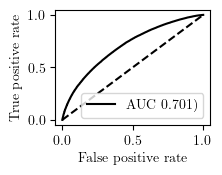


Evaluate_Model()
np.unique(y_proba) =  [0.         0.         0.0000142  ... 0.79826786 0.80504359 0.81538865]
np.unique(y_pred) =  [0 1]
[[144772   5999]
 [ 22296   4325]]

[[0.81611347 0.03381776]
 [0.12568774 0.02438103]]

0.419 & Precision \cr 
0.162 & Recall \cr 
0.234 & F1 \cr 



------------------------------------------
Bagging()  Bagging_Medium_Tomek_2_v1
Balance_Proba
Bagging_Medium_Tomek_2_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.0 1.0
center =  0.82

Plot FP/TP


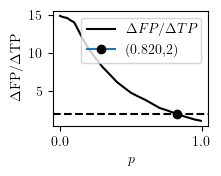

y_proba unique =  [0.         0.0101626  0.01219512 0.0152439  0.0174216  0.0203252
 0.02439024 0.0261324  0.02743902 0.0304878  0.03252033 0.03387534
 0.03484321 0.03556911 0.03658537 0.03658537 0.03963415 0.04065041
 0.04268293 0.0443459  0.04471545 0.04573171 0.04878049 0.05081301
 0.05182927 0.05299071 0.05335366 0.05444251 0.05487805 0.05589431
 0.05662021 0.05691057 0.06097561 0.06504065 0.06605691 0.06707317
 0.07012195 0.07084785 0.07113821 0.07317073 0.07520325 0.07621951
 0.07723577 0.07926829 0.07955865 0.08130081 0.08231707 0.08420441
 0.08536585 0.08638211 0.08710801 0.08739837 0.08885017 0.08943089
 0.09146341 0.09320557 0.09349593 0.09407666 0.0945122  0.09581882
 0.09654472 0.09727062 0.09756098 0.09908537 0.10162602 0.10235192
 0.10365854 0.10416667 0.10452962 0.10569106 0.10598142 0.10670732
 0.10743322 0.10772358 0.10787992 0.10840108 0.10888502 0.1097561
 0.11106272 0.11178862 0.11178862 0.11280488 0.11324042 0.11382114
 0.11432927 0.11505517 0.11585366 0.11614402 0

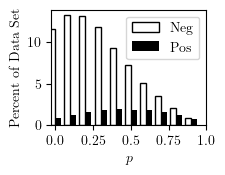


ROC()
Bagging_Medium_Tomek_2_v1
p_values =  []


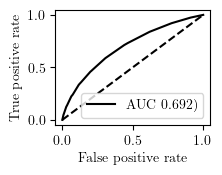


Evaluate_Model()
np.unique(y_proba) =  [0.         0.01666667 0.02       0.025      0.02857143 0.03333333
 0.04       0.04285714 0.045      0.05       0.05333333 0.05555556
 0.05714286 0.05833333 0.06       0.06       0.065      0.06666667
 0.07       0.07272727 0.07333333 0.075      0.08       0.08333333
 0.08333333 0.085      0.08690476 0.0875     0.08928571 0.09
 0.09166667 0.09285714 0.09333333 0.1        0.1        0.10666667
 0.10833333 0.11       0.115      0.11619048 0.11666667 0.11666667
 0.12       0.12       0.12333333 0.125      0.12666667 0.13
 0.13047619 0.13333333 0.135      0.13809524 0.14       0.14166667
 0.14285714 0.14333333 0.14571429 0.14666667 0.15       0.15285714
 0.15333333 0.15428571 0.155      0.15714286 0.15833333 0.15952381
 0.16       0.1625     0.16666667 0.16666667 0.16785714 0.17
 0.17083333 0.17142857 0.17333333 0.17380952 0.175      0.17619048
 0.17666667 0.17666667 0.17692308 0.17777778 0.17857143 0.18
 0.18214286 0.18333333 0.18333333 0.18333333 0

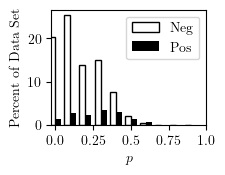


ROC()
Bagging_Medium_Tomek_2_v1_Linear_Transform
p_values =  []


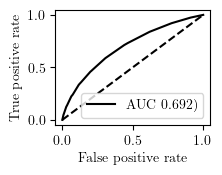


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0101626  0.01219512 0.0152439  0.0174216  0.0203252
 0.02439024 0.0261324  0.02743902 0.0304878  0.03252033 0.03387534
 0.03484321 0.03556911 0.03658537 0.03658537 0.03963415 0.04065041
 0.04268293 0.0443459  0.04471545 0.04573171 0.04878049 0.05081301
 0.05182927 0.05299071 0.05335366 0.05444251 0.05487805 0.05589431
 0.05662021 0.05691057 0.06097561 0.06504065 0.06605691 0.06707317
 0.07012195 0.07084785 0.07113821 0.07317073 0.07520325 0.07621951
 0.07723577 0.07926829 0.07955865 0.08130081 0.08231707 0.08420441
 0.08536585 0.08638211 0.08710801 0.08739837 0.08885017 0.08943089
 0.09146341 0.09320557 0.09349593 0.09407666 0.0945122  0.09581882
 0.09654472 0.09727062 0.09756098 0.09908537 0.10162602 0.10235192
 0.10365854 0.10416667 0.10452962 0.10569106 0.10598142 0.10670732
 0.10743322 0.10772358 0.10787992 0.10840108 0.10888502 0.1097561
 0.11106272 0.11178862 0.11178862 0.11280488 0.11324042 0.11382114
 0.11432927 0.11505517 0

Balance_Proba
RUSBoost_Medium_Tomek_2_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.4996802852812601 0.500767422814873
center =  0.5004521529301252

Plot FP/TP


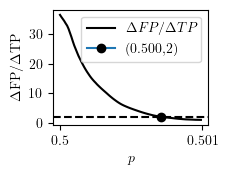

y_proba unique =  [-0.16297176 -0.12029631 -0.11666883 ...  0.79562486  0.7974253
  0.81198995]
y_proba unique =  [0.         0.0000002  0.00001145 ... 0.79562486 0.7974253  0.81198995]
M, m, left, right =  0.5002477523294703 0.499234440536424 0.0007655594635759821 0.00024775232947027437
Plot_Prediction()
RUSBoost_Medium_Tomek_2_v1
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


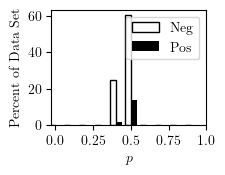


ROC()
RUSBoost_Medium_Tomek_2_v1
p_values =  []


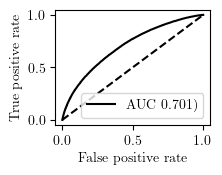


Evaluate_Model()
np.unique(y_proba) =  [0.49943706 0.49950241 0.49950796 ... 0.50090479 0.50090755 0.50092985]
np.unique(y_pred) =  [0 1]
[[ 43754 107017]
 [  2634  23987]]

[[0.24665148 0.60327974]
 [0.01484847 0.1352203 ]]

0.183 & Precision \cr 
0.901 & Recall \cr 
0.304 & F1 \cr 

Plot_Prediction()
RUSBoost_Medium_Tomek_2_v1_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


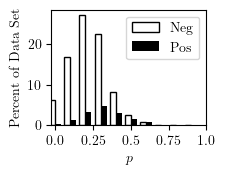


ROC()
RUSBoost_Medium_Tomek_2_v1_Linear_Transform
p_values =  []


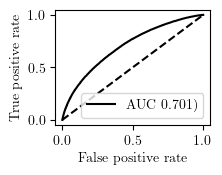


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0000002  0.00001145 ... 0.79562486 0.7974253  0.81198995]
np.unique(y_pred) =  [0 1]
[[144623   6148]
 [ 22210   4411]]

[[0.81527352 0.03465771]
 [0.12520294 0.02486583]]

0.418 & Precision \cr 
0.166 & Recall \cr 
0.237 & F1 \cr 



------------------------------------------
Easy Ensemble Classifier  EEC_Medium_Tomek_2_v1
Balance_Proba
EEC_Medium_Tomek_2_v1
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.4560497923168988 0.5545311917901888
center =  0.5279412139324006

Plot FP/TP


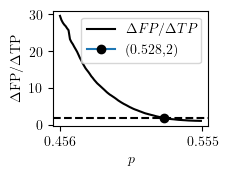

y_proba unique =  [0.         0.03911787 0.0391257  0.04148783 0.04989609 0.04990393
 0.05100046 0.05404002 0.0558876  0.06710484 0.08067499 0.08068284
 0.09020375 0.0902116  0.091473   0.09148085 0.09257978 0.09562398
 0.09747464 0.10100461 0.10101246 0.1021873  0.10342483 0.10515682
 0.10632969 0.10700792 0.10870921 0.11404115 0.11713732 0.11714518
 0.11824589 0.12129284 0.123145   0.13183873 0.13184659 0.13472869
 0.14265547 0.14266334 0.1438372  0.14507888 0.14681335 0.14798573
 0.14866687 0.15332472 0.15333259 0.15338381 0.15462611 0.15570862
 0.15753399 0.15754185 0.1588079  0.15881577 0.15991822 0.16296843
 0.16414809 0.16415596 0.16482278 0.16525799 0.16830855 0.16835817
 0.16836604 0.16953998 0.17016307 0.17078336 0.17251953 0.17437417
 0.17641681 0.18142002 0.18197457 0.18597035 0.19503121 0.19503909
 0.19508908 0.19633527 0.19924422 0.19925209 0.20458888 0.20459676
 0.20586543 0.2058733  0.20697684 0.21002976 0.21007902 0.2100869
 0.21188584 0.2125063  0.214244   0.21542451 

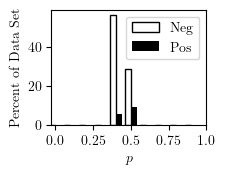


ROC()
EEC_Medium_Tomek_2_v1
p_values =  []


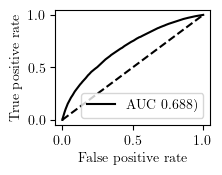


Evaluate_Model()
np.unique(y_proba) =  [0.45604979 0.46167427 0.4616754  0.46201503 0.46322399 0.46322512
 0.46338278 0.46381982 0.46408547 0.46569832 0.46764947 0.4676506
 0.46901954 0.46902067 0.46920204 0.46920317 0.46936118 0.46979888
 0.47006497 0.47057252 0.47057365 0.47074257 0.47092051 0.47116954
 0.47133818 0.4714357  0.47168031 0.47244695 0.47289213 0.47289326
 0.47305152 0.47348962 0.47375593 0.47500594 0.47500707 0.47542147
 0.4765612  0.47656233 0.47673111 0.47690965 0.47715903 0.4773276
 0.47742554 0.47809526 0.47809639 0.47810375 0.47828237 0.47843802
 0.47870048 0.47870161 0.47888364 0.47888478 0.47904329 0.47948186
 0.47965147 0.4796526  0.47974848 0.47981106 0.48024967 0.48025681
 0.48025794 0.48042673 0.48051632 0.48060551 0.48085514 0.48112181
 0.4814155  0.48213488 0.48221461 0.48278914 0.48409193 0.48409307
 0.48410026 0.48427944 0.48469769 0.48469882 0.48546616 0.4854673
 0.48564971 0.48565084 0.48580951 0.48624847 0.48625555 0.48625668
 0.48651534 0.48660455 0.

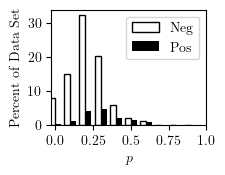


ROC()
EEC_Medium_Tomek_2_v1_Linear_Transform
p_values =  []


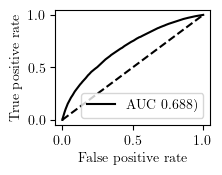


Evaluate_Model()
np.unique(y_proba) =  [0.         0.03911787 0.0391257  0.04148783 0.04989609 0.04990393
 0.05100046 0.05404002 0.0558876  0.06710484 0.08067499 0.08068284
 0.09020375 0.0902116  0.091473   0.09148085 0.09257978 0.09562398
 0.09747464 0.10100461 0.10101246 0.1021873  0.10342483 0.10515682
 0.10632969 0.10700792 0.10870921 0.11404115 0.11713732 0.11714518
 0.11824589 0.12129284 0.123145   0.13183873 0.13184659 0.13472869
 0.14265547 0.14266334 0.1438372  0.14507888 0.14681335 0.14798573
 0.14866687 0.15332472 0.15333259 0.15338381 0.15462611 0.15570862
 0.15753399 0.15754185 0.1588079  0.15881577 0.15991822 0.16296843
 0.16414809 0.16415596 0.16482278 0.16525799 0.16830855 0.16835817
 0.16836604 0.16953998 0.17016307 0.17078336 0.17251953 0.17437417
 0.17641681 0.18142002 0.18197457 0.18597035 0.19503121 0.19503909
 0.19508908 0.19633527 0.19924422 0.19925209 0.20458888 0.20459676
 0.20586543 0.2058733  0.20697684 0.21002976 0.21007902 0.2100869
 0.21188584 0.2125063  

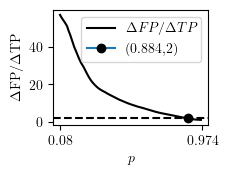

y_proba unique =  [-0.04928678 -0.04925543 -0.04746777 ...  0.56520295  0.5657836
  0.5676377 ]
y_proba unique =  [0.         0.00000036 0.00001189 ... 0.56520295 0.5657836  0.5676377 ]
M, m, left, right =  0.575295173227787 -0.29860041856765746 0.7986004185676574 0.075295173227787
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


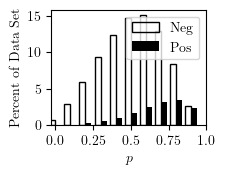


ROC()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v2
p_values =  []


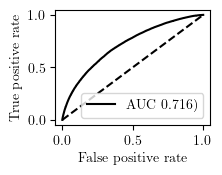


Evaluate_Model()
np.unique(y_proba) =  [0.00712181 0.00717188 0.0100271  ... 0.9885853  0.9895127  0.992474  ]
np.unique(y_pred) =  [0 1]
[[55287 95484]
 [ 3432 23189]]

[[0.31166569 0.53826554]
 [0.01934698 0.13072179]]

0.195 & Precision \cr 
0.871 & Recall \cr 
0.319 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


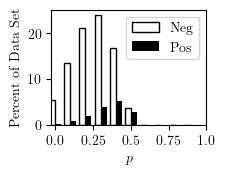


ROC()
KBFC_Medium_Tomek_1_alpha_balanced_gamma_0_0_v2_Linear_Transform
p_values =  []


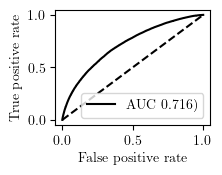


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000036 0.00001189 ... 0.56520295 0.5657836  0.5676377 ]
np.unique(y_pred) =  [0 1]
[[144283   6488]
 [ 21548   5073]]

[[0.81335686 0.03657437]
 [0.12147109 0.02859768]]

0.439 & Precision \cr 
0.191 & Recall \cr 
0.266 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.00529349 0.00635122 0.00797434 ... 0.9737752  0.97418135 0.9822835 ]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.0402930848300457 0.9288012802600863
center =  0.7155593133568766

Plot FP/TP


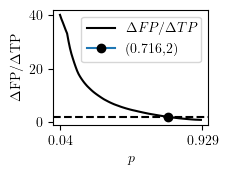

y_proba unique =  [-0.02724832 -0.02646315 -0.0252583  ...  0.6916802   0.6919817
  0.69799614]
y_proba unique =  [0.         0.00000054 0.00000563 ... 0.6916802  0.6919817  0.69799614]
M, m, left, right =  0.6779355975985528 -0.1735591134428978 0.6735591134428978 0.17793559759855282
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


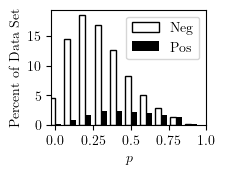


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v2
p_values =  []


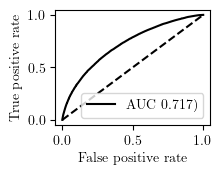


Evaluate_Model()
np.unique(y_proba) =  [0.00529349 0.00635122 0.00797434 ... 0.9737752  0.97418135 0.9822835 ]
np.unique(y_pred) =  [0 1]
[[118883  31888]
 [ 13109  13512]]

[[0.67017115 0.17976008]
 [0.07389848 0.07617029]]

0.298 & Precision \cr 
0.508 & Recall \cr 
0.375 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


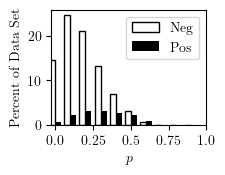


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_0_v2_Linear_Transform
p_values =  []


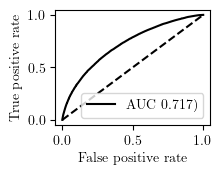


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000054 0.00000563 ... 0.6916802  0.6919817  0.69799614]
np.unique(y_pred) =  [0 1]
[[143815   6956]
 [ 21231   5390]]

[[0.81071863 0.03921259]
 [0.11968409 0.03038468]]

0.437 & Precision \cr 
0.202 & Recall \cr 
0.277 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.5
y_proba unique
[0.00363097 0.00485515 0.00522233 ... 0.94110745 0.9422781  0.9444067 ]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.021586299128830432 0.8589434146881106
center =  0.5491212819311769

Plot FP/TP


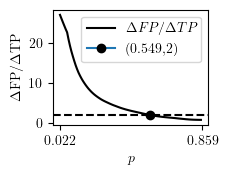

y_proba unique =  [-0.01809663 -0.01693398 -0.01658523 ...  0.8723013   0.87341315
  0.8754349 ]
y_proba unique =  [0.         0.0000011  0.00002789 ... 0.8723013  0.87341315 0.8754349 ]
M, m, left, right =  0.7504854369163517 -0.026436769664287565 0.5264367696642875 0.2504854369163517
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


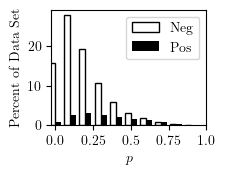


ROC()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v2
p_values =  []


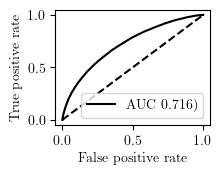


Evaluate_Model()
np.unique(y_proba) =  [0.00363097 0.00485515 0.00522233 ... 0.94110745 0.9422781  0.9444067 ]
np.unique(y_pred) =  [0 1]
[[140599  10172]
 [ 19658   6963]]

[[0.79258929 0.05734193]
 [0.11081672 0.03925205]]

0.406 & Precision \cr 
0.262 & Recall \cr 
0.318 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


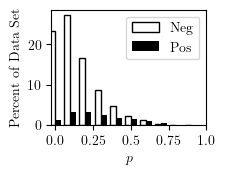


ROC()
KBFC_Medium_Tomek_1_alpha_0_5_gamma_0_0_v2_Linear_Transform
p_values =  []


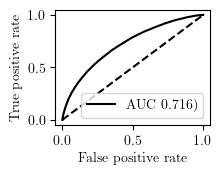


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0000011  0.00002789 ... 0.8723013  0.87341315 0.8754349 ]
np.unique(y_pred) =  [0 1]
[[143736   7035]
 [ 21124   5497]]

[[0.81027329 0.03965793]
 [0.11908091 0.03098787]]

0.439 & Precision \cr 
0.206 & Recall \cr 
0.281 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.0184816  0.02067618 0.0222486  ... 0.9399667  0.94328177 0.94724524]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.08430112153291702 0.8725976705551151
center =  0.6676405678093436

Plot FP/TP


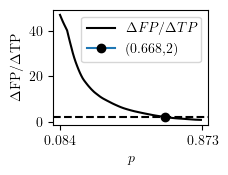

y_proba unique =  [-0.0593614  -0.05747044 -0.05611551 ...  0.7346555   0.737512
  0.7409272 ]
y_proba unique =  [0.         0.00000021 0.00002819 ... 0.7346555  0.737512   0.7409272 ]
M, m, left, right =  0.6649286100268376 -0.080267895758152 0.580267895758152 0.16492861002683756
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


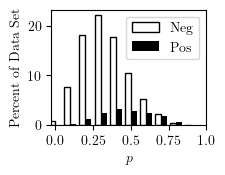


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v2
p_values =  []


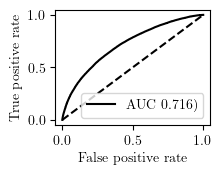


Evaluate_Model()
np.unique(y_proba) =  [0.0184816  0.02067618 0.0222486  ... 0.9399667  0.94328177 0.94724524]
np.unique(y_pred) =  [0 1]
[[118255  32516]
 [ 13049  13572]]

[[0.66663096 0.18330026]
 [0.07356025 0.07650852]]

0.294 & Precision \cr 
0.510 & Recall \cr 
0.373 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


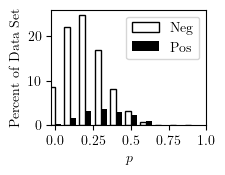


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_0_5_v2_Linear_Transform
p_values =  []


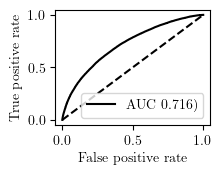


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000021 0.00002819 ... 0.7346555  0.737512   0.7409272 ]
np.unique(y_pred) =  [0 1]
[[143724   7047]
 [ 21169   5452]]

[[0.81020565 0.03972558]
 [0.11933458 0.03073419]]

0.436 & Precision \cr 
0.205 & Recall \cr 
0.279 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.03392733 0.03709837 0.03846707 ... 0.8935098  0.89403    0.89994645]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.1327528901398182 0.8165727376937868
center =  0.6319413788542153

Plot FP/TP


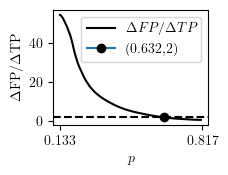

y_proba unique =  [-0.10411471 -0.10091138 -0.09952873 ...  0.7642368   0.7647623
  0.77073914]
y_proba unique =  [0.         0.00000039 0.00004017 ... 0.7642368  0.7647623  0.77073914]
M, m, left, right =  0.641047547161581 0.00504925161600113 0.4949507483839989 0.14104754716158097
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


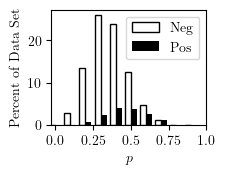


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v2
p_values =  []


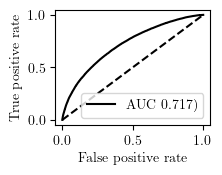


Evaluate_Model()
np.unique(y_proba) =  [0.03392733 0.03709837 0.03846707 ... 0.8935098  0.89403    0.89994645]
np.unique(y_pred) =  [0 1]
[[117736  33035]
 [ 12900  13721]]

[[0.66370524 0.18622599]
 [0.0727203  0.07734847]]

0.293 & Precision \cr 
0.515 & Recall \cr 
0.374 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


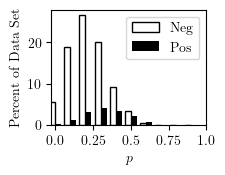


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_1_0_v2_Linear_Transform
p_values =  []


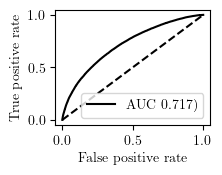


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000039 0.00004017 ... 0.7642368  0.7647623  0.77073914]
np.unique(y_pred) =  [0 1]
[[143755   7016]
 [ 21149   5472]]

[[0.8103804  0.03955083]
 [0.11922184 0.03084694]]

0.438 & Precision \cr 
0.206 & Recall \cr 
0.280 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.05709365 0.06946551 0.0752161  ... 0.8346754  0.8430227  0.85135204]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.2066018134355545 0.7331331551074982
center =  0.5962350062727928

Plot FP/TP


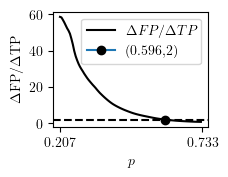

y_proba unique =  [-0.2005313  -0.18445605 -0.17698401 ...  0.8098167   0.82066274
  0.83148545]
y_proba unique =  [0.         0.00000209 0.00002742 ... 0.8098167  0.82066274 0.83148545]
M, m, left, right =  0.6026241359114649 0.11519116029143334 0.38480883970856666 0.10262413591146491
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


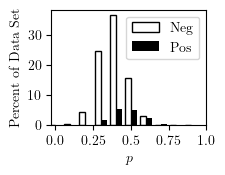


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v2
p_values =  []


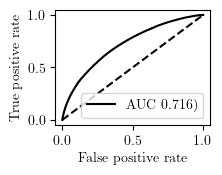


Evaluate_Model()
np.unique(y_proba) =  [0.05709365 0.06946551 0.0752161  ... 0.8346754  0.8430227  0.85135204]
np.unique(y_pred) =  [0 1]
[[116930  33841]
 [ 12751  13870]]

[[0.65916163 0.1907696 ]
 [0.07188036 0.07818842]]

0.291 & Precision \cr 
0.521 & Recall \cr 
0.373 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


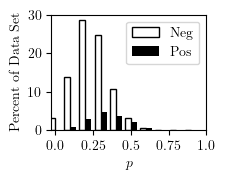


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_2_0_v2_Linear_Transform
p_values =  []


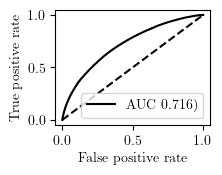


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000209 0.00002742 ... 0.8098167  0.82066274 0.83148545]
np.unique(y_pred) =  [0 1]
[[144364   6407]
 [ 21585   5036]]

[[0.81381348 0.03611775]
 [0.12167967 0.0283891 ]]

0.440 & Precision \cr 
0.189 & Recall \cr 
0.265 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.17030872 0.18761054 0.19817472 ... 0.6594139  0.7102365  0.7160762 ]
Balance_Proba
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.3345916450023651 0.616125673055649
center =  0.5457421660423281

Plot FP/TP


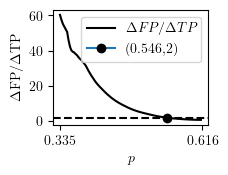

y_proba unique =  [-0.4025405  -0.36094695 -0.33555073 ...  0.7732663   0.89544374
  0.90948236]
y_proba unique =  [0.         0.00000206 0.0000262  ... 0.7732663  0.89544374 0.90948236]
M, m, left, right =  0.5509813556075096 0.29201295763254165 0.20798704236745835 0.050981355607509604
Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


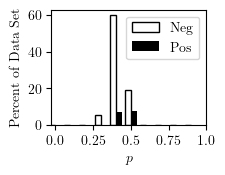


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v2
p_values =  []


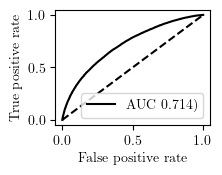


Evaluate_Model()
np.unique(y_proba) =  [0.17030872 0.18761054 0.19817472 ... 0.6594139  0.7102365  0.7160762 ]
np.unique(y_pred) =  [0 1]
[[116853  33918]
 [ 12759  13862]]

[[0.65872756 0.19120366]
 [0.07192545 0.07814332]]

0.290 & Precision \cr 
0.521 & Recall \cr 
0.373 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


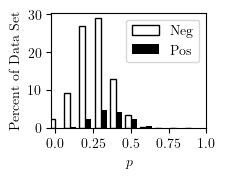


ROC()
KBFC_Medium_Tomek_1_alpha_target_gamma_5_0_v2_Linear_Transform
p_values =  []


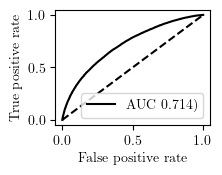


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000206 0.0000262  ... 0.7732663  0.89544374 0.90948236]
np.unique(y_pred) =  [0 1]
[[143824   6947]
 [ 21384   5237]]

[[0.81076937 0.03916186]
 [0.12054659 0.02952219]]

0.430 & Precision \cr 
0.197 & Recall \cr 
0.270 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_1_alpha_0_5_v2
Balance_Proba
LRC_Medium_Tomek_1_alpha_0_5_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.02646030637104332 0.6519465430658744
center =  0.3392034247184588

Plot FP/TP


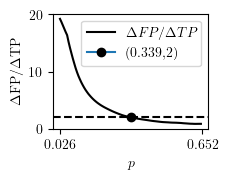

y_proba unique =  [-0.02882764 -0.02380364 -0.02171756 ...  1.18776838  1.19090145
  1.2109426 ]
y_proba unique =  [0.         0.00000019 0.00002769 ... 0.99949794 0.99968828 1.        ]
M, m, left, right =  0.7438275427437933 0.18786769182485005 0.3121323081751499 0.24382754274379326
Plot_Prediction()
LRC_Medium_Tomek_1_alpha_0_5_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


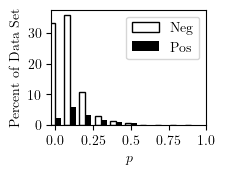


ROC()
LRC_Medium_Tomek_1_alpha_0_5_v2
p_values =  []


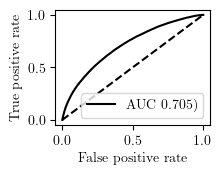


Evaluate_Model()
np.unique(y_proba) =  [0.00907504 0.01221135 0.01351361 ... 0.76855289 0.77050876 0.78301973]
np.unique(y_pred) =  [0 1]
[[149394   1377]
 [ 25177   1444]]

[[0.84216876 0.00776247]
 [0.14192861 0.00814016]]

0.512 & Precision \cr 
0.054 & Recall \cr 
0.098 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_1_alpha_0_5_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


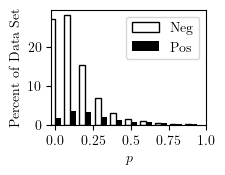


ROC()
LRC_Medium_Tomek_1_alpha_0_5_v2_Linear_Transform
p_values =  []


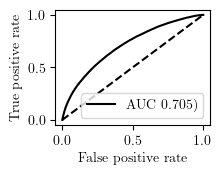


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000019 0.00002769 ... 0.99949794 0.99968828 1.        ]
np.unique(y_pred) =  [0 1]
[[144227   6544]
 [ 21753   4868]]

[[0.81304117 0.03689005]
 [0.12262672 0.02744205]]

0.427 & Precision \cr 
0.183 & Recall \cr 
0.256 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_1_alpha_target_v2
Balance_Proba
LRC_Medium_Tomek_1_alpha_target_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.05127590953197877 0.7911762284131322
center =  0.5100141072382939

Plot FP/TP


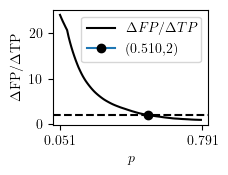

y_proba unique =  [-0.0376484  -0.03041711 -0.02807418 ...  0.89509639  0.89896309
  0.90252643]
y_proba unique =  [0.         0.00000003 0.00000761 ... 0.89509639 0.89896309 0.90252643]
M, m, left, right =  0.7291548896789646 0.04240378371178378 0.45759621628821623 0.22915488967896458
Plot_Prediction()
LRC_Medium_Tomek_1_alpha_target_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


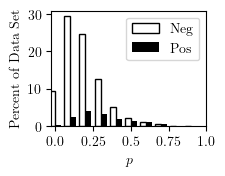


ROC()
LRC_Medium_Tomek_1_alpha_target_v2
p_values =  []


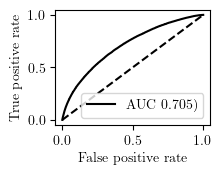


Evaluate_Model()
np.unique(y_proba) =  [0.01796236 0.02458038 0.02672462 ... 0.87160333 0.87514211 0.87840325]
np.unique(y_pred) =  [0 1]
[[143809   6962]
 [ 21566   5055]]

[[0.81068481 0.03924641]
 [0.12157256 0.02849621]]

0.421 & Precision \cr 
0.190 & Recall \cr 
0.262 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_1_alpha_target_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


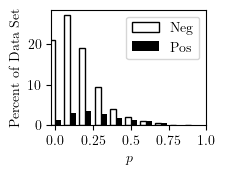


ROC()
LRC_Medium_Tomek_1_alpha_target_v2_Linear_Transform
p_values =  []


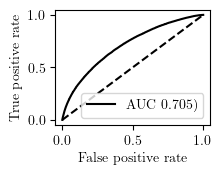


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000003 0.00000761 ... 0.89509639 0.89896309 0.90252643]
np.unique(y_pred) =  [0 1]
[[144284   6487]
 [ 21807   4814]]

[[0.8133625  0.03656873]
 [0.12293114 0.02713764]]

0.426 & Precision \cr 
0.181 & Recall \cr 
0.254 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_1_alpha_balanced_v2
Balance_Proba
LRC_Medium_Tomek_1_alpha_balanced_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.12878481956886667 0.9150338634018926
center =  0.7420590737586269

Plot FP/TP


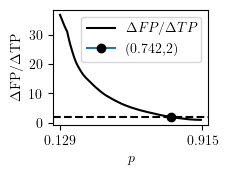

y_proba unique =  [-0.06767147 -0.05251792 -0.05051778 ...  0.67127374  0.67231219
  0.67326868]
y_proba unique =  [0.         0.0000026  0.00001593 ... 0.67127374 0.67231219 0.67326868]
M, m, left, right =  0.6467344748033894 -0.11092202816445325 0.6109220281644533 0.14673447480338941
Plot_Prediction()
LRC_Medium_Tomek_1_alpha_balanced_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


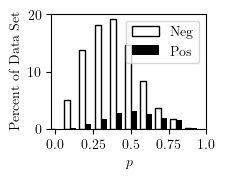


ROC()
LRC_Medium_Tomek_1_alpha_balanced_v2
p_values =  []


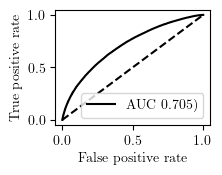


Evaluate_Model()
np.unique(y_proba) =  [0.04845306 0.06696834 0.0694122  ... 0.95132887 0.9525977  0.95376638]
np.unique(y_pred) =  [0 1]
[[99860 50911]
 [ 9733 16888]]

[[0.56293407 0.28699716]
 [0.05486719 0.09520159]]

0.249 & Precision \cr 
0.634 & Recall \cr 
0.358 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_1_alpha_balanced_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


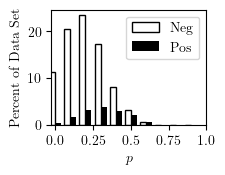


ROC()
LRC_Medium_Tomek_1_alpha_balanced_v2_Linear_Transform
p_values =  []


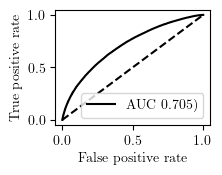


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0000026  0.00001593 ... 0.67127374 0.67231219 0.67326868]
np.unique(y_pred) =  [0 1]
[[144094   6677]
 [ 21745   4876]]

[[0.81229142 0.0376398 ]
 [0.12258163 0.02748715]]

0.422 & Precision \cr 
0.183 & Recall \cr 
0.255 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_1_alpha_0_5_v2


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_1_alpha_0_5_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.035 0.98
center =  0.76265

Plot FP/TP


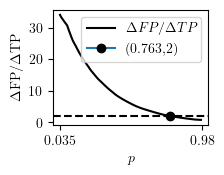

y_proba unique =  [-0.02767592 -0.02668749 -0.02629212 ...  0.65730298  0.65960931
  0.66422196]
y_proba unique =  [0.         0.00057658 0.0006919  ... 0.65730298 0.65960931 0.66422196]
M, m, left, right =  0.6773682142857194 -0.22265000000000001 0.72265 0.17736821428571936
Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_0_5_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


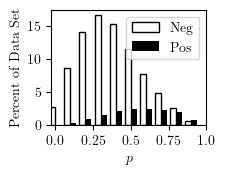


ROC()
BRFC_Medium_Tomek_1_alpha_0_5_v2
p_values =  []


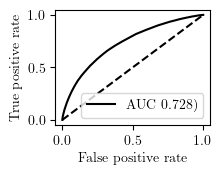


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00142857 0.002      ... 0.99       0.99333333 1.        ]
np.unique(y_pred) =  [0 1]
[[102154  48617]
 [  9010  17611]]

[[0.57586588 0.27406535]
 [0.05079147 0.09927731]]

0.266 & Precision \cr 
0.662 & Recall \cr 
0.379 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_0_5_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


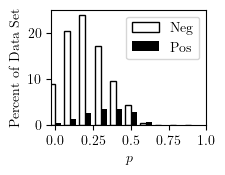


ROC()
BRFC_Medium_Tomek_1_alpha_0_5_v2_Linear_Transform
p_values =  []


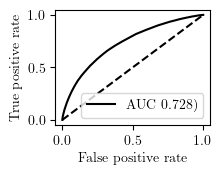


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00057658 0.0006919  ... 0.65730298 0.65960931 0.66422196]
np.unique(y_pred) =  [0 1]
[[142217   8554]
 [ 20157   6464]]

[[0.80171034 0.04822089]
 [0.1136297  0.03643907]]

0.430 & Precision \cr 
0.243 & Recall \cr 
0.310 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_1_alpha_target_v2


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_1_alpha_target_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03666666666666667 0.98
center =  0.7724666666666666

Plot FP/TP


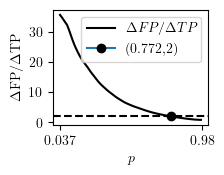

y_proba unique =  [-0.027305   -0.02275416 -0.02218531 ...  0.64849367  0.6519068
  0.65531992]
y_proba unique =  [0.         0.00032506 0.00045508 ... 0.64849367 0.6519068  0.65531992]
M, m, left, right =  0.6719791863691867 -0.2324666666666666 0.7324666666666666 0.17197918636918674
Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_target_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


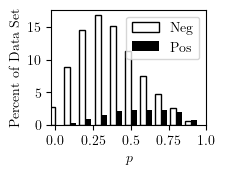


ROC()
BRFC_Medium_Tomek_1_alpha_target_v2
p_values =  []


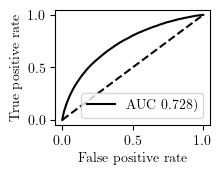


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00666667 0.0075     ... 0.99       0.995      1.        ]
np.unique(y_pred) =  [0 1]
[[103152  47619]
 [  9269  17352]]

[[0.58149184 0.26843939]
 [0.05225151 0.09781726]]

0.267 & Precision \cr 
0.652 & Recall \cr 
0.379 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_target_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


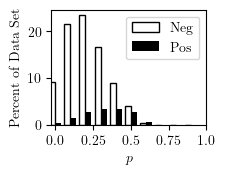


ROC()
BRFC_Medium_Tomek_1_alpha_target_v2_Linear_Transform
p_values =  []


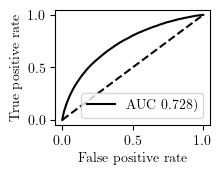


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00032506 0.00045508 ... 0.64849367 0.6519068  0.65531992]
np.unique(y_pred) =  [0 1]
[[142859   7912]
 [ 20551   6070]]

[[0.80532944 0.04460179]
 [0.11585077 0.034218  ]]

0.434 & Precision \cr 
0.228 & Recall \cr 
0.299 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_1_alpha_balanced_v2


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_1_alpha_balanced_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.037872016298302794 0.98
center =  0.7821531234226436

Plot FP/TP


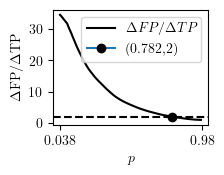

y_proba unique =  [-0.02694862 -0.02199639 -0.0212402  ...  0.64296219  0.64440259
  0.6467668 ]
y_proba unique =  [0.         0.00034513 0.00041125 ... 0.64296219 0.64440259 0.6467668 ]
M, m, left, right =  0.6678468765773563 -0.2421531234226436 0.7421531234226436 0.1678468765773563
Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_balanced_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


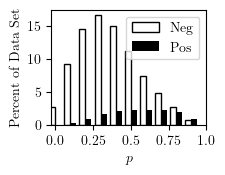


ROC()
BRFC_Medium_Tomek_1_alpha_balanced_v2
p_values =  []


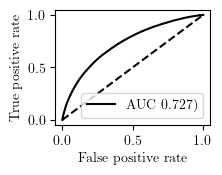


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00735062 0.00847303 ... 0.99435279 0.99649079 1.        ]
np.unique(y_pred) =  [0 1]
[[102825  47946]
 [  9296  17325]]

[[0.57964846 0.27028276]
 [0.05240372 0.09766506]]

0.265 & Precision \cr 
0.651 & Recall \cr 
0.377 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_1_alpha_balanced_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


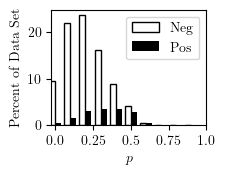


ROC()
BRFC_Medium_Tomek_1_alpha_balanced_v2_Linear_Transform
p_values =  []


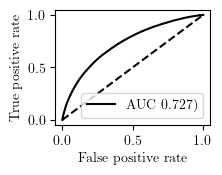


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00034513 0.00041125 ... 0.64296219 0.64440259 0.6467668 ]
np.unique(y_pred) =  [0 1]
[[142965   7806]
 [ 20783   5838]]

[[0.80592699 0.04400424]
 [0.11715861 0.03291017]]

0.428 & Precision \cr 
0.219 & Recall \cr 
0.290 & F1 \cr 



------------------------------------------
AdaBoost()  AdaBoost_Medium_Tomek_1_v2
Balance_Proba
AdaBoost_Medium_Tomek_1_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.4909592663054141 0.5015980646332967
center =  0.49840642513493194

Plot FP/TP


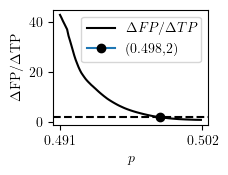

y_proba unique =  [-0.18484857 -0.13648853 -0.11130712 ...  0.81174394  0.821094
  0.823781  ]
y_proba unique =  [0.         0.00000097 0.00003851 ... 0.81174394 0.821094   0.823781  ]
M, m, left, right =  0.5024852150627379 0.49261544986590594 0.007384550134094059 0.002485215062737911
Plot_Prediction()
AdaBoost_Medium_Tomek_1_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


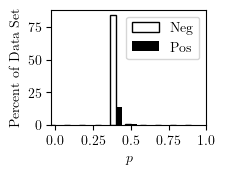


ROC()
AdaBoost_Medium_Tomek_1_v2
p_values =  []


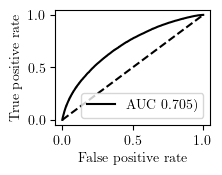


Evaluate_Model()
np.unique(y_proba) =  [0.48829183 0.48900606 0.48937797 ... 0.5030106  0.50314869 0.50318838]
np.unique(y_pred) =  [0 1]
[[149270   1501]
 [ 25107   1514]]

[[0.84146974 0.00846149]
 [0.141534   0.00853477]]

0.502 & Precision \cr 
0.057 & Recall \cr 
0.102 & F1 \cr 

Plot_Prediction()
AdaBoost_Medium_Tomek_1_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


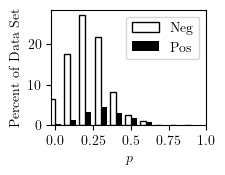


ROC()
AdaBoost_Medium_Tomek_1_v2_Linear_Transform
p_values =  []


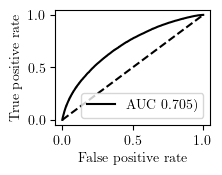


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000097 0.00003851 ... 0.81174394 0.821094   0.823781  ]
np.unique(y_pred) =  [0 1]
[[144439   6332]
 [ 21908   4713]]

[[0.81423627 0.03569496]
 [0.1235005  0.02656828]]

0.427 & Precision \cr 
0.177 & Recall \cr 
0.250 & F1 \cr 



------------------------------------------
Bagging()  Bagging_Medium_Tomek_1_v2
Balance_Proba
Bagging_Medium_Tomek_1_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.0 1.0
center =  0.8

Plot FP/TP


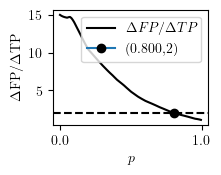

y_proba unique =  [0.         0.00892857 0.01041667 0.0125     0.015625   0.02083333
 0.0234375  0.025      0.02678571 0.03125    0.03333333 0.03645833
 0.0375     0.04166667 0.04375    0.04583333 0.046875   0.05
 0.05059524 0.05208333 0.053125   0.05357143 0.05416667 0.0546875
 0.05625    0.05729167 0.05769231 0.05833333 0.0625     0.06428571
 0.06458333 0.065625   0.06666667 0.06741071 0.06770833 0.06875
 0.07291667 0.075      0.07708333 0.078125   0.07916667 0.08125
 0.08333333 0.084375   0.08541667 0.0859375  0.08668155 0.0875
 0.08802083 0.08854167 0.08928571 0.09166667 0.09375    0.09375
 0.0952381  0.09642857 0.096875   0.09722222 0.09821429 0.09895833
 0.1        0.1015625  0.10416667 0.10416667 0.1046875  0.10625
 0.10714286 0.10763889 0.10833333 0.109375   0.11041667 0.1125
 0.11309524 0.11458333 0.11607143 0.11666667 0.1171875  0.11755952
 0.11805556 0.11875    0.11979167 0.12083333 0.121875   0.12291667
 0.12395833 0.125      0.12604167 0.12872024 0.13020833 0.13020833
 0.1

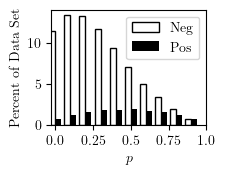


ROC()
Bagging_Medium_Tomek_1_v2
p_values =  []


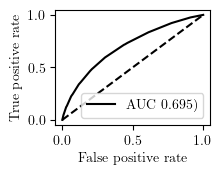


Evaluate_Model()
np.unique(y_proba) =  [0.         0.01428571 0.01666667 0.02       0.025      0.03333333
 0.0375     0.04       0.04285714 0.05       0.05333333 0.05833333
 0.06       0.06666667 0.07       0.07333333 0.075      0.08
 0.08095238 0.08333333 0.08333333 0.085      0.08571429 0.08666667
 0.0875     0.09       0.09166667 0.09230769 0.09333333 0.1
 0.10285714 0.10333333 0.105      0.10666667 0.10785714 0.10833333
 0.11       0.11666667 0.11666667 0.12       0.12       0.12333333
 0.125      0.12666667 0.13       0.13333333 0.135      0.13666667
 0.1375     0.13869048 0.14       0.14083333 0.14166667 0.14285714
 0.14666667 0.15       0.15       0.15238095 0.15428571 0.155
 0.15555556 0.15714286 0.15833333 0.16       0.1625     0.16666667
 0.16666667 0.1675     0.17       0.17142857 0.17222222 0.17333333
 0.175      0.17666667 0.18       0.18095238 0.18333333 0.18333333
 0.18333333 0.18571429 0.18666667 0.18666667 0.1875     0.18809524
 0.18888889 0.19       0.19166667 0.1933

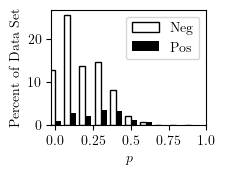


ROC()
Bagging_Medium_Tomek_1_v2_Linear_Transform
p_values =  []


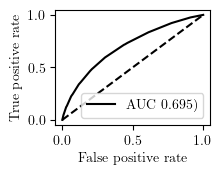


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00892857 0.01041667 0.0125     0.015625   0.02083333
 0.0234375  0.025      0.02678571 0.03125    0.03333333 0.03645833
 0.0375     0.04166667 0.04375    0.04583333 0.046875   0.05
 0.05059524 0.05208333 0.053125   0.05357143 0.05416667 0.0546875
 0.05625    0.05729167 0.05769231 0.05833333 0.0625     0.06428571
 0.06458333 0.065625   0.06666667 0.06741071 0.06770833 0.06875
 0.07291667 0.075      0.07708333 0.078125   0.07916667 0.08125
 0.08333333 0.084375   0.08541667 0.0859375  0.08668155 0.0875
 0.08802083 0.08854167 0.08928571 0.09166667 0.09375    0.09375
 0.0952381  0.09642857 0.096875   0.09722222 0.09821429 0.09895833
 0.1        0.1015625  0.10416667 0.10416667 0.1046875  0.10625
 0.10714286 0.10763889 0.10833333 0.109375   0.11041667 0.1125
 0.11309524 0.11458333 0.11607143 0.11666667 0.1171875  0.11755952
 0.11805556 0.11875    0.11979167 0.12083333 0.121875   0.12291667
 0.12395833 0.125      0.12604167 0.12872024 0.13

Balance_Proba
RUSBoost_Medium_Tomek_1_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.49969136246540313 0.5007595882908099
center =  0.5004498028014419

Plot FP/TP


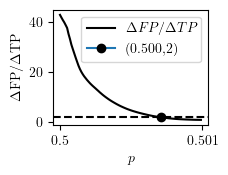

y_proba unique =  [-0.17837647 -0.1237282  -0.11898863 ...  0.8036661   0.80744353
  0.81035496]
y_proba unique =  [0.         0.00000041 0.00002507 ... 0.8036661  0.80744353 0.81035496]
M, m, left, right =  0.5002385101534488 0.4992485390925337 0.0007514609074663059 0.0002385101534487788
Plot_Prediction()
RUSBoost_Medium_Tomek_1_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


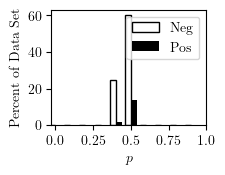


ROC()
RUSBoost_Medium_Tomek_1_v2
p_values =  []


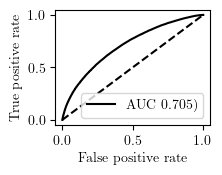


Evaluate_Model()
np.unique(y_proba) =  [0.49943026 0.49951239 0.49951951 ... 0.50090619 0.50091187 0.50091624]
np.unique(y_pred) =  [0 1]
[[ 43972 106799]
 [  2579  24042]]

[[0.2478804  0.60205083]
 [0.01453842 0.13553035]]

0.184 & Precision \cr 
0.903 & Recall \cr 
0.305 & F1 \cr 

Plot_Prediction()
RUSBoost_Medium_Tomek_1_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


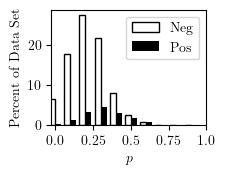


ROC()
RUSBoost_Medium_Tomek_1_v2_Linear_Transform
p_values =  []


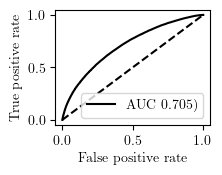


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000041 0.00002507 ... 0.8036661  0.80744353 0.81035496]
np.unique(y_pred) =  [0 1]
[[144769   6002]
 [ 22084   4537]]

[[0.81609655 0.03383467]
 [0.12449265 0.02557613]]

0.430 & Precision \cr 
0.170 & Recall \cr 
0.244 & F1 \cr 



------------------------------------------
Easy Ensemble Classifier  EEC_Medium_Tomek_1_v2
Balance_Proba
EEC_Medium_Tomek_1_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.45680601042981445 0.554325834580872
center =  0.5260450855770653

Plot FP/TP


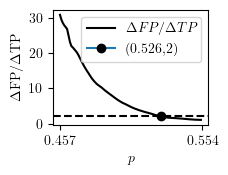

y_proba unique =  [0.         0.00518834 0.03464728 0.03519528 0.03984815 0.04039616
 0.04044424 0.04099224 0.0427518  0.04564511 0.04619312 0.04795007
 0.04998443 0.05518322 0.05840102 0.05932573 0.06360189 0.0645266
 0.06810708 0.07745988 0.07800891 0.08266854 0.08321756 0.0832669
 0.08381592 0.08470194 0.08525113 0.08847555 0.08902457 0.08991098
 0.09046017 0.09051028 0.09105947 0.09282387 0.09571931 0.0962685
 0.09803083 0.09848551 0.10125359 0.10217975 0.1028465  0.10369577
 0.10563294 0.10646224 0.1073884  0.1085017  0.10865944 0.10920898
 0.10942805 0.11083381 0.11097431 0.11145132 0.11371074 0.11463709
 0.1166522  0.1169595  0.11822449 0.12216972 0.12666075 0.12758775
 0.12759085 0.12814088 0.13280588 0.13335591 0.13340732 0.13395735
 0.13862235 0.13917238 0.14139331 0.14575911 0.14630943 0.14660926
 0.14854616 0.14864957 0.15142276 0.15157928 0.15175025 0.15212959
 0.15230071 0.15235025 0.15301608 0.15356652 0.15386578 0.15437053
 0.15580432 0.15663779 0.15696752 0.15751797 0.

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


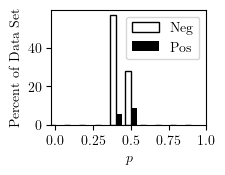


ROC()
EEC_Medium_Tomek_1_v2
p_values =  []


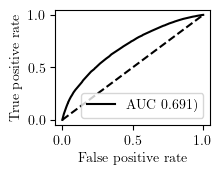


Evaluate_Model()
np.unique(y_proba) =  [0.45680601 0.45752448 0.4616039  0.46167979 0.46232411 0.4624
 0.46240665 0.46248254 0.4627262  0.46312686 0.46320275 0.46344605
 0.46372776 0.46444768 0.46489328 0.46502133 0.46561348 0.46574154
 0.46623735 0.46753251 0.46760854 0.4682538  0.46832982 0.46833666
 0.46841268 0.46853538 0.46861143 0.46905794 0.46913397 0.46925672
 0.46933277 0.46933971 0.46941576 0.46966009 0.47006104 0.47013709
 0.47038114 0.4704441  0.47082742 0.47095567 0.471048   0.47116561
 0.47143386 0.4715487  0.47167696 0.47183113 0.47185297 0.47192907
 0.4719594  0.47215407 0.47217353 0.47223958 0.47255246 0.47268074
 0.47295979 0.47300235 0.47317752 0.47372385 0.47434576 0.47447413
 0.47447456 0.47455072 0.47519672 0.47527289 0.47528001 0.47535618
 0.47600218 0.47607834 0.47638589 0.47699046 0.47706667 0.47710819
 0.47737641 0.47739073 0.47777475 0.47779643 0.4778201  0.47787264
 0.47789633 0.47790319 0.47799539 0.47807162 0.47811306 0.47818296
 0.4783815  0.47849692 0.4

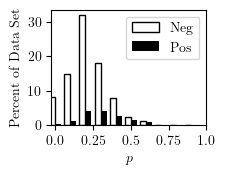


ROC()
EEC_Medium_Tomek_1_v2_Linear_Transform
p_values =  []


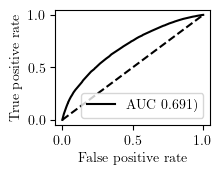


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00518834 0.03464728 0.03519528 0.03984815 0.04039616
 0.04044424 0.04099224 0.0427518  0.04564511 0.04619312 0.04795007
 0.04998443 0.05518322 0.05840102 0.05932573 0.06360189 0.0645266
 0.06810708 0.07745988 0.07800891 0.08266854 0.08321756 0.0832669
 0.08381592 0.08470194 0.08525113 0.08847555 0.08902457 0.08991098
 0.09046017 0.09051028 0.09105947 0.09282387 0.09571931 0.0962685
 0.09803083 0.09848551 0.10125359 0.10217975 0.1028465  0.10369577
 0.10563294 0.10646224 0.1073884  0.1085017  0.10865944 0.10920898
 0.10942805 0.11083381 0.11097431 0.11145132 0.11371074 0.11463709
 0.1166522  0.1169595  0.11822449 0.12216972 0.12666075 0.12758775
 0.12759085 0.12814088 0.13280588 0.13335591 0.13340732 0.13395735
 0.13862235 0.13917238 0.14139331 0.14575911 0.14630943 0.14660926
 0.14854616 0.14864957 0.15142276 0.15157928 0.15175025 0.15212959
 0.15230071 0.15235025 0.15301608 0.15356652 0.15386578 0.15437053
 0.15580432 0.15663779 0.

p =  5.5261776733103645
alpha_balanced =  0.8467709507680694

------------------------------------------
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v2
alpha_balanced =  0.8467709507680694
Keras_Binary_Focal_Crossentropy
alpha =  0.8467709507680694
y_proba unique
[0.00804968 0.00809964 0.00851799 ... 0.9882168  0.98842865 0.99023265]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.07435227371752262 0.9692247390747071
center =  0.8707887678854168

Plot FP/TP


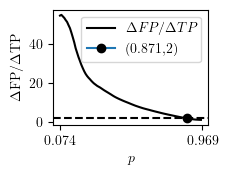

y_proba unique =  [-0.04498482 -0.04495323 -0.044689   ...  0.5741783   0.5743121
  0.5754517 ]
y_proba unique =  [0.         0.00000229 0.00004196 ... 0.5741783  0.5743121  0.5754517 ]
M, m, left, right =  0.5824024677276611 -0.2915257775783539 0.791525777578354 0.08240246772766113
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


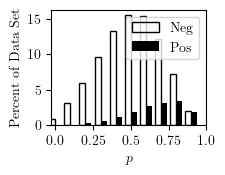


ROC()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v2
p_values =  []


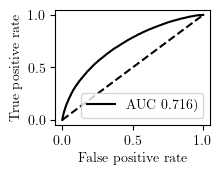


Evaluate_Model()
np.unique(y_proba) =  [0.00804968 0.00809964 0.00851799 ... 0.9882168  0.98842865 0.99023265]
np.unique(y_pred) =  [0 1]
[[58129 92642]
 [ 3732 22889]]

[[0.32768671 0.52224452]
 [0.02103815 0.12903062]]

0.198 & Precision \cr 
0.860 & Recall \cr 
0.322 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


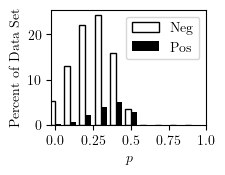


ROC()
KBFC_Medium_Tomek_2_alpha_balanced_gamma_0_0_v2_Linear_Transform
p_values =  []


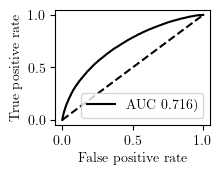


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000229 0.00004196 ... 0.5741783  0.5743121  0.5754517 ]
np.unique(y_pred) =  [0 1]
[[144267   6504]
 [ 21590   5031]]

[[0.81326666 0.03666456]
 [0.12170786 0.02836092]]

0.436 & Precision \cr 
0.189 & Recall \cr 
0.264 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.00491481 0.00654155 0.00797118 ... 0.95949566 0.9633515  0.9644132 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03967656865715981 0.9100587785243991
center =  0.6837594039589169

Plot FP/TP


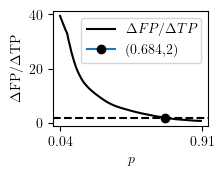

y_proba unique =  [-0.02854925 -0.02728266 -0.0261696  ...  0.7146886   0.71769077
  0.7185174 ]
y_proba unique =  [0.         0.00000125 0.00002003 ... 0.7146886  0.71769077 0.7185174 ]
M, m, left, right =  0.6873392394185072 -0.1421772000193596 0.6421772000193596 0.18733923941850716
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


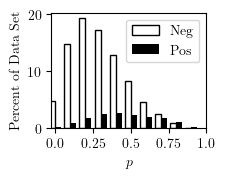


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v2
p_values =  []


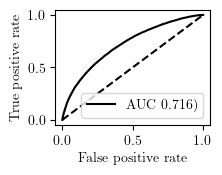


Evaluate_Model()
np.unique(y_proba) =  [0.00491481 0.00654155 0.00797118 ... 0.95949566 0.9633515  0.9644132 ]
np.unique(y_pred) =  [0 1]
[[121769  29002]
 [ 13865  12756]]

[[0.6864402  0.16349103]
 [0.07816023 0.07190854]]

0.305 & Precision \cr 
0.479 & Recall \cr 
0.373 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


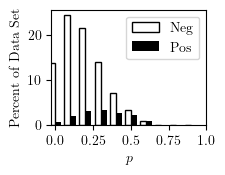


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_0_v2_Linear_Transform
p_values =  []


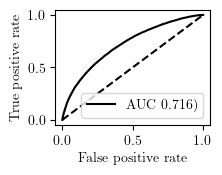


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000125 0.00002003 ... 0.7146886  0.71769077 0.7185174 ]
np.unique(y_pred) =  [0 1]
[[143437   7334]
 [ 21098   5523]]

[[0.80858776 0.04134347]
 [0.11893434 0.03113444]]

0.430 & Precision \cr 
0.207 & Recall \cr 
0.280 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.5
y_proba unique
[0.00229137 0.00322601 0.00338371 ... 0.94391745 0.95098823 0.9572499 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.019363708049058913 0.8458784341812136
center =  0.5235376909896733

Plot FP/TP


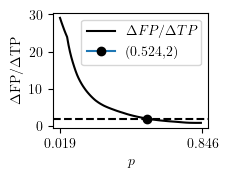

y_proba unique =  [-0.01795912 -0.01703036 -0.01687366 ...  0.91772866  0.92475486
  0.930977  ]
y_proba unique =  [0.         0.00000072 0.00000411 ... 0.91772866 0.92475486 0.930977  ]
M, m, left, right =  0.755722930431367 -0.0031732329726219173 0.503173232972622 0.25572293043136696
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


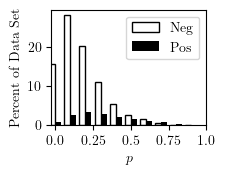


ROC()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v2
p_values =  []


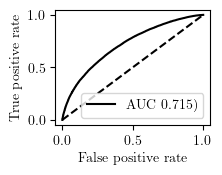


Evaluate_Model()
np.unique(y_proba) =  [0.00229137 0.00322601 0.00338371 ... 0.94391745 0.95098823 0.9572499 ]
np.unique(y_pred) =  [0 1]
[[142148   8623]
 [ 20419   6202]]

[[0.80132137 0.04860986]
 [0.11510666 0.03496212]]

0.418 & Precision \cr 
0.233 & Recall \cr 
0.299 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


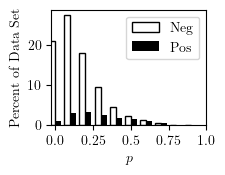


ROC()
KBFC_Medium_Tomek_2_alpha_0_5_gamma_0_0_v2_Linear_Transform
p_values =  []


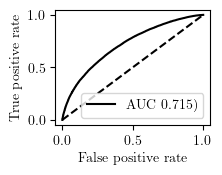


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000072 0.00000411 ... 0.91772866 0.92475486 0.930977  ]
np.unique(y_pred) =  [0 1]
[[143528   7243]
 [ 21065   5556]]

[[0.80910075 0.04083048]
 [0.11874831 0.03132047]]

0.434 & Precision \cr 
0.209 & Recall \cr 
0.282 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.01620563 0.0190002  0.01956212 ... 0.9052981  0.90563446 0.9066288 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.0736756108701229 0.8379134953022004
center =  0.6392116453498602

Plot FP/TP


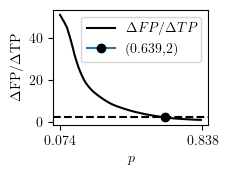

y_proba unique =  [-0.05411893 -0.0516333  -0.05113351 ...  0.7366647   0.73696387
  0.7378482 ]
y_proba unique =  [0.         0.00000077 0.00002235 ... 0.7366647  0.73696387 0.7378482 ]
M, m, left, right =  0.6591196882724764 -0.06215916901826858 0.5621591690182686 0.15911968827247636
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


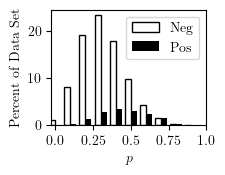


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v2
p_values =  []


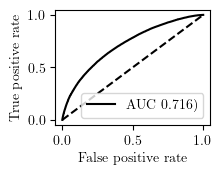


Evaluate_Model()
np.unique(y_proba) =  [0.01620563 0.0190002  0.01956212 ... 0.9052981  0.90563446 0.9066288 ]
np.unique(y_pred) =  [0 1]
[[122842  27929]
 [ 14089  12532]]

[[0.69248895 0.15744227]
 [0.07942297 0.0706458 ]]

0.310 & Precision \cr 
0.471 & Recall \cr 
0.374 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


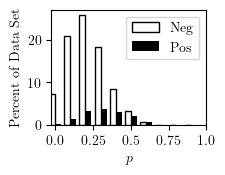


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_0_5_v2_Linear_Transform
p_values =  []


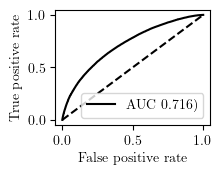


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000077 0.00002235 ... 0.7366647  0.73696387 0.7378482 ]
np.unique(y_pred) =  [0 1]
[[143855   6916]
 [ 21229   5392]]

[[0.81094412 0.0389871 ]
 [0.11967282 0.03039596]]

0.438 & Precision \cr 
0.203 & Recall \cr 
0.277 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.03315058 0.03849287 0.03862192 ... 0.8621577  0.87149674 0.8791601 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.1367952510714531 0.788009494543077
center =  0.6121816488057386

Plot FP/TP


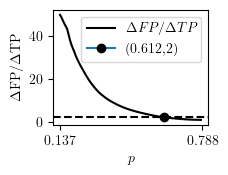

y_proba unique =  [-0.11283803 -0.10718381 -0.10704726 ...  0.76457095  0.7744553
  0.7825661 ]
y_proba unique =  [0.         0.00003123 0.00005919 ... 0.76457095 0.7744553  0.7825661 ]
M, m, left, right =  0.6361741647124293 0.027582287788391113 0.4724177122116089 0.13617416471242927
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


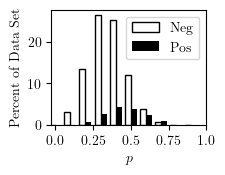


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v2
p_values =  []


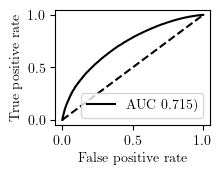


Evaluate_Model()
np.unique(y_proba) =  [0.03315058 0.03849287 0.03862192 ... 0.8621577  0.87149674 0.8791601 ]
np.unique(y_pred) =  [0 1]
[[120929  29842]
 [ 13724  12897]]

[[0.68170492 0.1682263 ]
 [0.07736538 0.07270339]]

0.302 & Precision \cr 
0.484 & Recall \cr 
0.372 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


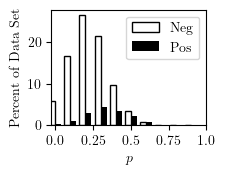


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_1_0_v2_Linear_Transform
p_values =  []


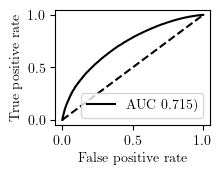


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00003123 0.00005919 ... 0.76457095 0.7744553  0.7825661 ]
np.unique(y_pred) =  [0 1]
[[143612   7159]
 [ 21285   5336]]

[[0.80957428 0.04035695]
 [0.1199885  0.03008027]]

0.427 & Precision \cr 
0.200 & Recall \cr 
0.273 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.0893832  0.09683952 0.09946    ... 0.76823103 0.77033967 0.7728844 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.2115088813006878 0.7051879048347474
center =  0.5768313587158919

Plot FP/TP


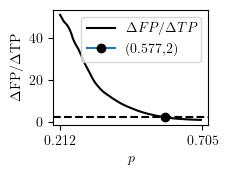

y_proba unique =  [-0.17570364 -0.1653676  -0.16173506 ...  0.76531947  0.7682424
  0.77177   ]
y_proba unique =  [0.         0.00000128 0.00002584 ... 0.76531947 0.7682424  0.77177   ]
M, m, left, right =  0.5936335751414303 0.13930328592658042 0.3606967140734196 0.09363357514143034
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


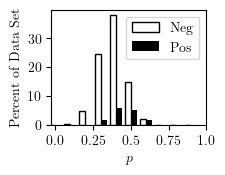


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v2
p_values =  []


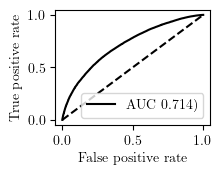


Evaluate_Model()
np.unique(y_proba) =  [0.0893832  0.09683952 0.09946    ... 0.76823103 0.77033967 0.7728844 ]
np.unique(y_pred) =  [0 1]
[[120484  30287]
 [ 13545  13076]]

[[0.67919636 0.17073487]
 [0.07635632 0.07371246]]

0.302 & Precision \cr 
0.491 & Recall \cr 
0.374 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


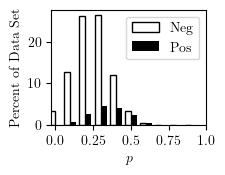


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_2_0_v2_Linear_Transform
p_values =  []


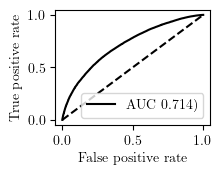


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000128 0.00002584 ... 0.76531947 0.7682424  0.77177   ]
np.unique(y_pred) =  [0 1]
[[143982   6789]
 [ 21390   5231]]

[[0.81166005 0.03827117]
 [0.12058041 0.02948836]]

0.435 & Precision \cr 
0.196 & Recall \cr 
0.271 & F1 \cr 



------------------------------------------
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v2
Keras_Binary_Focal_Crossentropy
alpha =  0.6666666666666666
y_proba unique
[0.10624139 0.12549374 0.12627724 ... 0.65235144 0.65563107 0.6636691 ]
Balance_Proba
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.32642542868852614 0.6002250075340271
center =  0.5372511043995618

Plot FP/TP


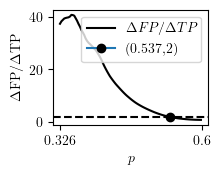

y_proba unique =  [-0.54363346 -0.4970165  -0.49511933 ...  0.77870035  0.7866415
  0.8061046 ]
y_proba unique =  [0.         0.00000581 0.00001094 ... 0.77870035 0.7866415  0.8061046 ]
M, m, left, right =  0.5457014840841296 0.2935052242875099 0.2064947757124901 0.04570148408412955
Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


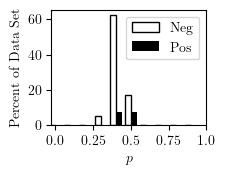


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v2
p_values =  []


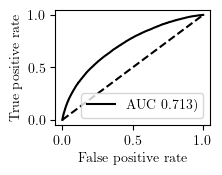


Evaluate_Model()
np.unique(y_proba) =  [0.10624139 0.12549374 0.12627724 ... 0.65235144 0.65563107 0.6636691 ]
np.unique(y_pred) =  [0 1]
[[119988  30783]
 [ 13456  13165]]

[[0.67640029 0.17353094]
 [0.0758546  0.07421417]]

0.300 & Precision \cr 
0.495 & Recall \cr 
0.373 & F1 \cr 

Plot_Prediction()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


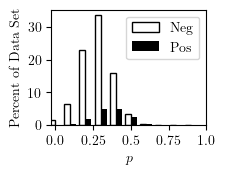


ROC()
KBFC_Medium_Tomek_2_alpha_target_gamma_5_0_v2_Linear_Transform
p_values =  []


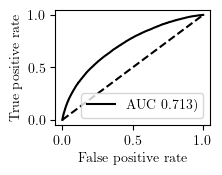


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000581 0.00001094 ... 0.77870035 0.7866415  0.8061046 ]
np.unique(y_pred) =  [0 1]
[[143925   6846]
 [ 21411   5210]]

[[0.81133873 0.0385925 ]
 [0.12069879 0.02936998]]

0.432 & Precision \cr 
0.196 & Recall \cr 
0.269 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_2_alpha_0_5_v2
Balance_Proba
LRC_Medium_Tomek_2_alpha_0_5_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.026431850808837115 0.6566562449288545
center =  0.34154404786884585

Plot FP/TP


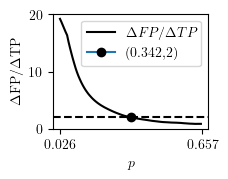

y_proba unique =  [-0.02854724 -0.0235485  -0.02154902 ...  1.18735096  1.19023707
  1.2100553 ]
y_proba unique =  [0.         0.00002737 0.00003181 ... 0.99920604 0.99996594 1.        ]
M, m, left, right =  0.7463440234960861 0.18548953386038258 0.3145104661396174 0.24634402349608608
Plot_Prediction()
LRC_Medium_Tomek_2_alpha_0_5_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


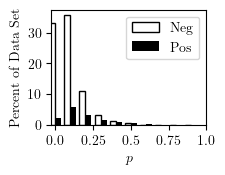


ROC()
LRC_Medium_Tomek_2_alpha_0_5_v2
p_values =  []


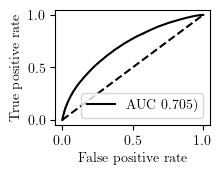


Evaluate_Model()
np.unique(y_proba) =  [0.00907677 0.01222108 0.0134788  ... 0.77390219 0.77571761 0.78818369]
np.unique(y_pred) =  [0 1]
[[149304   1467]
 [ 25111   1510]]

[[0.84166141 0.00826982]
 [0.14155655 0.00851222]]

0.507 & Precision \cr 
0.057 & Recall \cr 
0.102 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_2_alpha_0_5_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


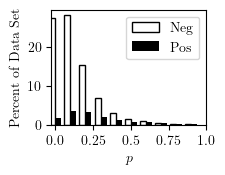


ROC()
LRC_Medium_Tomek_2_alpha_0_5_v2_Linear_Transform
p_values =  []


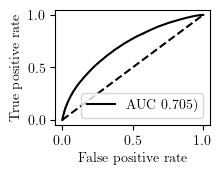


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00002737 0.00003181 ... 0.99920604 0.99996594 1.        ]
np.unique(y_pred) =  [0 1]
[[144199   6572]
 [ 21740   4881]]

[[0.81288333 0.03704789]
 [0.12255344 0.02751533]]

0.426 & Precision \cr 
0.183 & Recall \cr 
0.256 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_2_alpha_target_v2
Balance_Proba
LRC_Medium_Tomek_2_alpha_target_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.05119430895539881 0.7946192340179726
center =  0.5121177624941946

Plot FP/TP


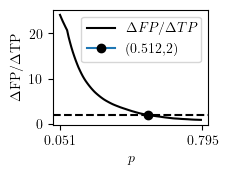

y_proba unique =  [-0.03736361 -0.03013327 -0.02799866 ...  0.89464123  0.89822944
  0.90171133]
y_proba unique =  [0.         0.00000002 0.00001146 ... 0.89464123 0.89822944 0.90171133]
M, m, left, right =  0.7307659702824753 0.0402167148195914 0.4597832851804086 0.23076597028247525
Plot_Prediction()
LRC_Medium_Tomek_2_alpha_target_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


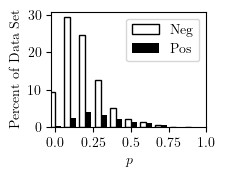


ROC()
LRC_Medium_Tomek_2_alpha_target_v2
p_values =  []


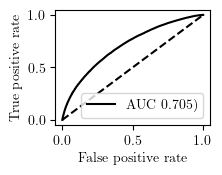


Evaluate_Model()
np.unique(y_proba) =  [0.01797615 0.02462493 0.02658785 ... 0.87501664 0.87831624 0.88151807]
np.unique(y_pred) =  [0 1]
[[143634   7137]
 [ 21473   5148]]

[[0.8096983  0.04023293]
 [0.1210483  0.02902047]]

0.419 & Precision \cr 
0.193 & Recall \cr 
0.265 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_2_alpha_target_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


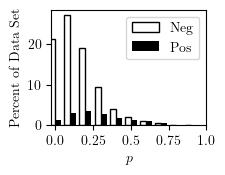


ROC()
LRC_Medium_Tomek_2_alpha_target_v2_Linear_Transform
p_values =  []


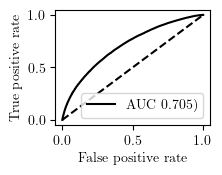


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000002 0.00001146 ... 0.89464123 0.89822944 0.90171133]
np.unique(y_pred) =  [0 1]
[[144243   6528]
 [ 21782   4839]]

[[0.81313137 0.03679986]
 [0.1227902  0.02727857]]

0.426 & Precision \cr 
0.182 & Recall \cr 
0.255 & F1 \cr 



------------------------------------------
Logistic Regression Classifier  LRC_Medium_Tomek_2_alpha_balanced_v2
Balance_Proba
LRC_Medium_Tomek_2_alpha_balanced_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.12819612846741307 0.9162150466370255
center =  0.7428508846397108

Plot FP/TP


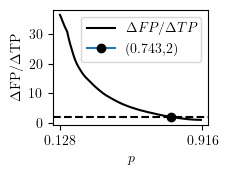

y_proba unique =  [-0.06724826 -0.05211509 -0.05052326 ...  0.67117986  0.67214776
  0.67309358]
y_proba unique =  [0.         0.00000103 0.0000231  ... 0.67117986 0.67214776 0.67309358]
M, m, left, right =  0.6473332890447506 -0.11220555457084382 0.6122055545708438 0.14733328904475063
Plot_Prediction()
LRC_Medium_Tomek_2_alpha_balanced_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


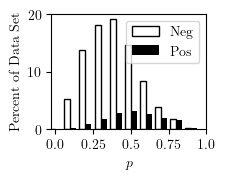


ROC()
LRC_Medium_Tomek_2_alpha_balanced_v2
p_values =  []


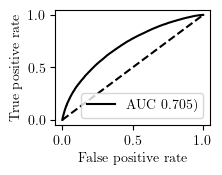


Evaluate_Model()
np.unique(y_proba) =  [0.04830582 0.06683504 0.06878408 ... 0.9524454  0.95363051 0.95478859]
np.unique(y_pred) =  [0 1]
[[99808 50963]
 [ 9726 16895]]

[[0.56264093 0.28729029]
 [0.05482773 0.09524105]]

0.249 & Precision \cr 
0.635 & Recall \cr 
0.358 & F1 \cr 

Plot_Prediction()
LRC_Medium_Tomek_2_alpha_balanced_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


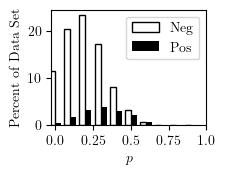


ROC()
LRC_Medium_Tomek_2_alpha_balanced_v2_Linear_Transform
p_values =  []


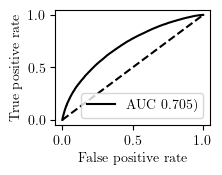


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000103 0.0000231  ... 0.67117986 0.67214776 0.67309358]
np.unique(y_pred) =  [0 1]
[[144049   6722]
 [ 21718   4903]]

[[0.81203775 0.03789348]
 [0.12242942 0.02763935]]

0.422 & Precision \cr 
0.184 & Recall \cr 
0.256 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_2_alpha_0_5_v2


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_2_alpha_0_5_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.035 0.98
center =  0.7721

Plot FP/TP


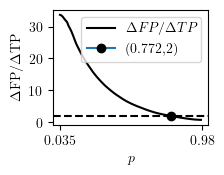

y_proba unique =  [-0.02731867 -0.02561126 -0.02439167 ...  0.65109502  0.65337158
  0.65564814]
y_proba unique =  [0.         0.00056914 0.00063418 ... 0.65109502 0.65337158 0.65564814]
M, m, left, right =  0.6699679761904821 -0.23209999999999997 0.7321 0.1699679761904821
Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_0_5_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


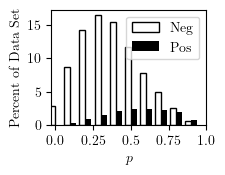


ROC()
BRFC_Medium_Tomek_2_alpha_0_5_v2
p_values =  []


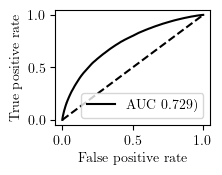


Evaluate_Model()
np.unique(y_proba) =  [0.         0.0025     0.00428571 ... 0.99333333 0.99666667 1.        ]
np.unique(y_pred) =  [0 1]
[[101984  48787]
 [  9039  17582]]

[[0.57490755 0.27502368]
 [0.05095495 0.09911383]]

0.265 & Precision \cr 
0.660 & Recall \cr 
0.378 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_0_5_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


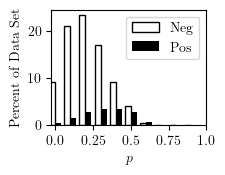


ROC()
BRFC_Medium_Tomek_2_alpha_0_5_v2_Linear_Transform
p_values =  []


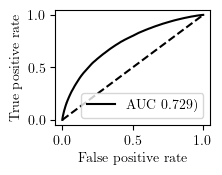


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00056914 0.00063418 ... 0.65109502 0.65337158 0.65564814]
np.unique(y_pred) =  [0 1]
[[142951   7820]
 [ 20491   6130]]

[[0.80584807 0.04408316]
 [0.11551254 0.03455624]]

0.439 & Precision \cr 
0.230 & Recall \cr 
0.302 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_2_alpha_target_v2


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_2_alpha_target_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03133333333333333 0.98
center =  0.7712933333333334

Plot FP/TP


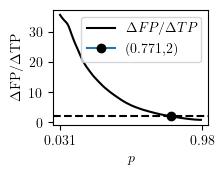

y_proba unique =  [-0.02613891 -0.02159123 -0.02102277 ...  0.65222287  0.65373876
  0.6560126 ]
y_proba unique =  [0.         0.00001023 0.00017265 ... 0.65222287 0.65373876 0.6560126 ]
M, m, left, right =  0.6750521428571462 -0.23297500000000004 0.732975 0.1750521428571462
Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_target_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


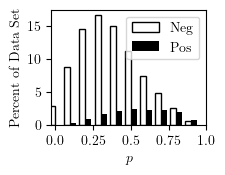


ROC()
BRFC_Medium_Tomek_2_alpha_target_v2
p_values =  []


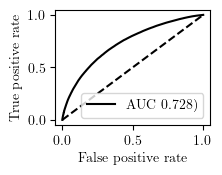


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00666667 0.0075     ... 0.99444444 0.99666667 1.        ]
np.unique(y_pred) =  [0 1]
[[103109  47662]
 [  9228  17393]]

[[0.58124944 0.26868179]
 [0.05202038 0.09804839]]

0.267 & Precision \cr 
0.653 & Recall \cr 
0.379 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_target_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


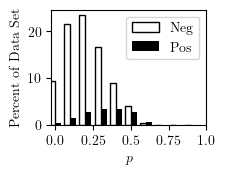


ROC()
BRFC_Medium_Tomek_2_alpha_target_v2_Linear_Transform
p_values =  []


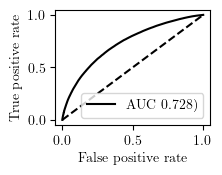


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00001023 0.00017265 ... 0.65222287 0.65373876 0.6560126 ]
np.unique(y_pred) =  [0 1]
[[142716   8055]
 [ 20481   6140]]

[[0.80452332 0.04540791]
 [0.11545616 0.03461261]]

0.433 & Precision \cr 
0.231 & Recall \cr 
0.301 & F1 \cr 



------------------------------------------
Balanced Random Forest Classifier  BRFC_Medium_Tomek_2_alpha_balanced_v2


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureW

Balance_Proba
BRFC_Medium_Tomek_2_alpha_balanced_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.03846770950768069 0.98
center =  0.7728628960916899

Plot FP/TP


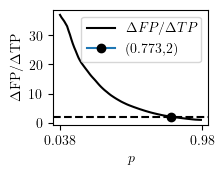

y_proba unique =  [-0.02729023 -0.02151309 -0.02103375 ...  0.6545775   0.65467033
  0.65496562]
y_proba unique =  [0.         0.00155723 0.00156355 ... 0.6545775  0.65467033 0.65496562]
M, m, left, right =  0.6771371039083101 -0.23286289609168986 0.7328628960916899 0.17713710390831006
Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_balanced_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


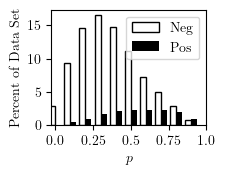


ROC()
BRFC_Medium_Tomek_2_alpha_balanced_v2
p_values =  []


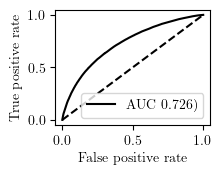


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00846771 0.00917029 ... 0.99943112 0.99956719 1.        ]
np.unique(y_pred) =  [0 1]
[[103019  47752]
 [  9373  17248]]

[[0.58074209 0.26918914]
 [0.05283778 0.09723099]]

0.265 & Precision \cr 
0.648 & Recall \cr 
0.377 & F1 \cr 

Plot_Prediction()
BRFC_Medium_Tomek_2_alpha_balanced_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


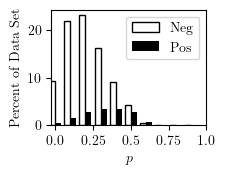


ROC()
BRFC_Medium_Tomek_2_alpha_balanced_v2_Linear_Transform
p_values =  []


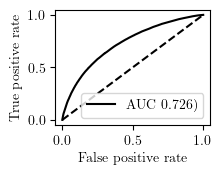


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00155723 0.00156355 ... 0.6545775  0.65467033 0.65496562]
np.unique(y_pred) =  [0 1]
[[142215   8556]
 [ 20413   6208]]

[[0.80169906 0.04823216]
 [0.11507283 0.03499594]]

0.420 & Precision \cr 
0.233 & Recall \cr 
0.300 & F1 \cr 



------------------------------------------
AdaBoost()  AdaBoost_Medium_Tomek_2_v2
Balance_Proba
AdaBoost_Medium_Tomek_2_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.49098533475291484 0.5016072661203104
center =  0.4984206867100917

Plot FP/TP


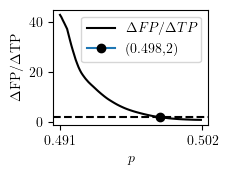

y_proba unique =  [-0.17313427 -0.12412786 -0.11289098 ...  0.81648938  0.82151775
  0.82809012]
y_proba unique =  [0.         0.00000415 0.00005834 ... 0.81648938 0.82151775 0.82809012]
M, m, left, right =  0.5024719829211891 0.49263137573736626 0.007368624262633738 0.0024719829211891087
Plot_Prediction()
AdaBoost_Medium_Tomek_2_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


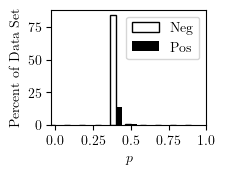


ROC()
AdaBoost_Medium_Tomek_2_v2
p_values =  []


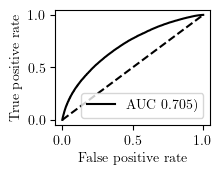


Evaluate_Model()
np.unique(y_proba) =  [0.48850054 0.48922276 0.48938836 ... 0.50308487 0.50315897 0.50325583]
np.unique(y_pred) =  [0 1]
[[149276   1495]
 [ 25096   1525]]

[[0.84150356 0.00842766]
 [0.14147199 0.00859678]]

0.505 & Precision \cr 
0.057 & Recall \cr 
0.103 & F1 \cr 

Plot_Prediction()
AdaBoost_Medium_Tomek_2_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


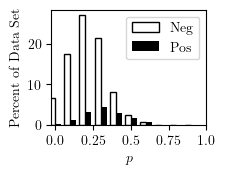


ROC()
AdaBoost_Medium_Tomek_2_v2_Linear_Transform
p_values =  []


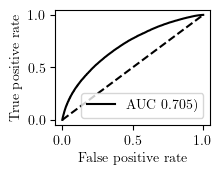


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000415 0.00005834 ... 0.81648938 0.82151775 0.82809012]
np.unique(y_pred) =  [0 1]
[[144432   6339]
 [ 21933   4688]]

[[0.81419681 0.03573442]
 [0.12364143 0.02642735]]

0.425 & Precision \cr 
0.176 & Recall \cr 
0.249 & F1 \cr 



------------------------------------------
Bagging()  Bagging_Medium_Tomek_2_v2
Balance_Proba
Bagging_Medium_Tomek_2_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.0 1.0
center =  0.8

Plot FP/TP


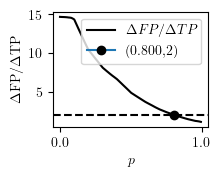

y_proba unique =  [0.         0.01041667 0.0125     0.015625   0.01785714 0.02083333
 0.02142857 0.025      0.03125    0.03571429 0.03645833 0.0375
 0.04166667 0.04464286 0.046875   0.05       0.05208333 0.05357143
 0.05416667 0.0546875  0.05625    0.05729167 0.05833333 0.059375
 0.0625     0.06458333 0.06770833 0.06875    0.07142857 0.071875
 0.07291667 0.075      0.07589286 0.07708333 0.078125   0.07916667
 0.08035714 0.08125    0.08333333 0.084375   0.0859375  0.08630952
 0.0875     0.08764881 0.08854167 0.08928571 0.08958333 0.09077381
 0.09151786 0.09166667 0.09375    0.09375    0.0952381  0.09583333
 0.096875   0.09722222 0.09821429 0.09895833 0.1        0.1015625
 0.103125   0.10416667 0.10625    0.10714286 0.10729167 0.10833333
 0.109375   0.11111111 0.11145833 0.11160714 0.1125     0.11309524
 0.11421131 0.11458333 0.115625   0.11607143 0.11666667 0.1171875
 0.11875    0.11927083 0.11979167 0.12053571 0.12083333 0.121875
 0.12239583 0.12291667 0.1235119  0.125      0.1265625  

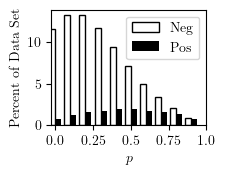


ROC()
Bagging_Medium_Tomek_2_v2
p_values =  []


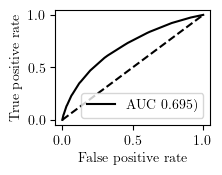


Evaluate_Model()
np.unique(y_proba) =  [0.         0.01666667 0.02       0.025      0.02857143 0.03333333
 0.03428571 0.04       0.05       0.05714286 0.05833333 0.06
 0.06       0.06666667 0.07142857 0.075      0.08       0.08333333
 0.08333333 0.08571429 0.08666667 0.0875     0.09       0.09166667
 0.09166667 0.09333333 0.095      0.1        0.10333333 0.10833333
 0.11       0.11428571 0.115      0.11666667 0.11666667 0.12
 0.12       0.12142857 0.12333333 0.125      0.12666667 0.12857143
 0.13       0.13333333 0.13333333 0.135      0.1375     0.13809524
 0.14       0.1402381  0.14166667 0.14285714 0.14333333 0.1452381
 0.14642857 0.14666667 0.15       0.15       0.15238095 0.15333333
 0.155      0.15555556 0.15714286 0.15833333 0.16       0.1625
 0.165      0.16666667 0.17       0.17142857 0.17166667 0.17333333
 0.17333333 0.175      0.17777778 0.17833333 0.17857143 0.18
 0.18095238 0.1827381  0.18333333 0.18333333 0.185      0.18571429
 0.18666667 0.1875     0.19       0.19083333 

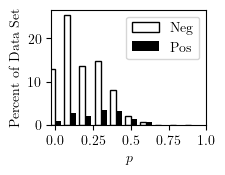


ROC()
Bagging_Medium_Tomek_2_v2_Linear_Transform
p_values =  []


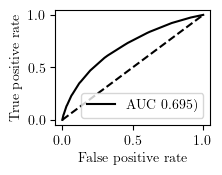


Evaluate_Model()
np.unique(y_proba) =  [0.         0.01041667 0.0125     0.015625   0.01785714 0.02083333
 0.02142857 0.025      0.03125    0.03571429 0.03645833 0.0375
 0.04166667 0.04464286 0.046875   0.05       0.05208333 0.05357143
 0.05416667 0.0546875  0.05625    0.05729167 0.05833333 0.059375
 0.0625     0.06458333 0.06770833 0.06875    0.07142857 0.071875
 0.07291667 0.075      0.07589286 0.07708333 0.078125   0.07916667
 0.08035714 0.08125    0.08333333 0.084375   0.0859375  0.08630952
 0.0875     0.08764881 0.08854167 0.08928571 0.08958333 0.09077381
 0.09151786 0.09166667 0.09375    0.09375    0.0952381  0.09583333
 0.096875   0.09722222 0.09821429 0.09895833 0.1        0.1015625
 0.103125   0.10416667 0.10625    0.10714286 0.10729167 0.10833333
 0.109375   0.11111111 0.11145833 0.11160714 0.1125     0.11309524
 0.11421131 0.11458333 0.115625   0.11607143 0.11666667 0.1171875
 0.11875    0.11927083 0.11979167 0.12053571 0.12083333 0.121875
 0.12239583 0.12291667 0.1235119  

Balance_Proba
RUSBoost_Medium_Tomek_2_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.49969037066712174 0.5007734241748487
center =  0.5004485081225306

Plot FP/TP


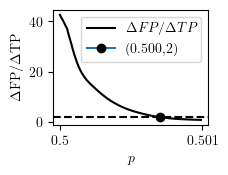

y_proba unique =  [-0.17099555 -0.12491193 -0.11404986 ...  0.82022734  0.82046976
  0.83271556]
y_proba unique =  [0.         0.00000046 0.00001767 ... 0.82022734 0.82046976 0.83271556]
M, m, left, right =  0.5002535695624022 0.49924812364525156 0.0007518763547484375 0.0002535695624021894
Plot_Prediction()
RUSBoost_Medium_Tomek_2_v2
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


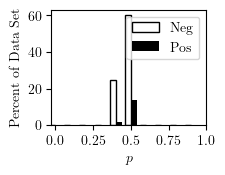


ROC()
RUSBoost_Medium_Tomek_2_v2
p_values =  []


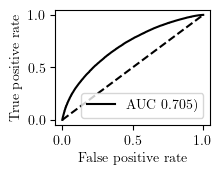


Evaluate_Model()
np.unique(y_proba) =  [0.4994395  0.4995088  0.49952513 ... 0.50093005 0.50093042 0.50094883]
np.unique(y_pred) =  [0 1]
[[ 44113 106658]
 [  2622  23999]]

[[0.24867525 0.60125598]
 [0.01478082 0.13528795]]

0.184 & Precision \cr 
0.902 & Recall \cr 
0.305 & F1 \cr 

Plot_Prediction()
RUSBoost_Medium_Tomek_2_v2_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


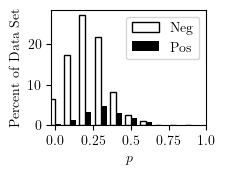


ROC()
RUSBoost_Medium_Tomek_2_v2_Linear_Transform
p_values =  []


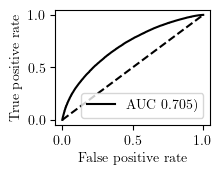


Evaluate_Model()
np.unique(y_proba) =  [0.         0.00000046 0.00001767 ... 0.82022734 0.82046976 0.83271556]
np.unique(y_pred) =  [0 1]
[[144423   6348]
 [ 21885   4736]]

[[0.81414607 0.03578515]
 [0.12337084 0.02669793]]

0.427 & Precision \cr 
0.178 & Recall \cr 
0.251 & F1 \cr 



------------------------------------------
Easy Ensemble Classifier  EEC_Medium_Tomek_2_v2
Balance_Proba
EEC_Medium_Tomek_2_v2
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>

Quantiles  0.4563207008274935 0.5545380277227223
center =  0.5270371761920583

Plot FP/TP


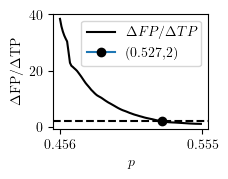

y_proba unique =  [0.         0.02908868 0.0293893  0.04260892 0.04992004 0.05081247
 0.05111309 0.05468868 0.05701738 0.06896673 0.07174932 0.07205055
 0.07906975 0.07937104 0.09261899 0.09351152 0.09381276 0.09739532
 0.09813522 0.09972776 0.10083751 0.1011388  0.10437547 0.1047217
 0.1070547  0.11169549 0.11553438 0.11592744 0.11902519 0.11991816
 0.12021971 0.12181056 0.12211236 0.12380559 0.12613998 0.13733729
 0.14090233 0.14120434 0.14360938 0.14391118 0.14513825 0.14544026
 0.14715217 0.14749972 0.14823867 0.14854071 0.14983567 0.15448971
 0.15832324 0.15871908 0.16182044 0.16271339 0.1630154  0.16566292
 0.16605824 0.16660627 0.16695186 0.16725387 0.16894331 0.17005363
 0.17035568 0.17084452 0.17318178 0.17359886 0.17394679 0.1762842
 0.18014989 0.18517296 0.18565053 0.18749276 0.18795898 0.18826134
 0.19106233 0.19136472 0.19530294 0.19560533 0.19732087 0.20850242
 0.20890026 0.20979365 0.21009601 0.212898   0.21320039 0.21369045
 0.21442676 0.21472928 0.21490497 0.21520749 0

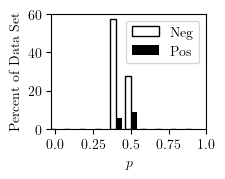


ROC()
EEC_Medium_Tomek_2_v2
p_values =  []


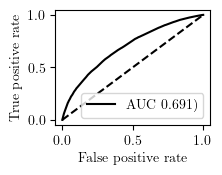


Evaluate_Model()
np.unique(y_proba) =  [0.4563207  0.4604348  0.46047732 0.46234701 0.46338104 0.46350726
 0.46354978 0.46405548 0.46438484 0.46607487 0.46646842 0.46651102
 0.46750377 0.46754638 0.46942008 0.46954631 0.46958892 0.47009561
 0.47020025 0.47042549 0.47058245 0.47062506 0.47108283 0.4711318
 0.47146176 0.47211812 0.47266107 0.47271666 0.47315478 0.47328108
 0.47332373 0.47354873 0.47359141 0.47383089 0.47416105 0.47574472
 0.47624893 0.47629165 0.4766318  0.47667448 0.47684803 0.47689075
 0.47713287 0.47718202 0.47728653 0.47732925 0.4775124  0.47817064
 0.47871282 0.47876881 0.47920744 0.47933374 0.47937645 0.4797509
 0.47980681 0.47988432 0.4799332  0.47997591 0.48021485 0.48037189
 0.48041461 0.48048375 0.48081431 0.4808733  0.48092251 0.4812531
 0.48179983 0.48251026 0.4825778  0.48283835 0.48290429 0.48294706
 0.48334321 0.48338598 0.48394297 0.48398574 0.48422837 0.48580981
 0.48586608 0.48599244 0.4860352  0.48643149 0.48647426 0.48654357
 0.48664771 0.4866905  0.

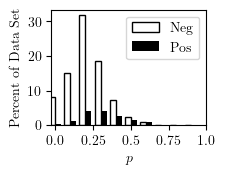


ROC()
EEC_Medium_Tomek_2_v2_Linear_Transform
p_values =  []


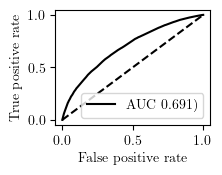


Evaluate_Model()
np.unique(y_proba) =  [0.         0.02908868 0.0293893  0.04260892 0.04992004 0.05081247
 0.05111309 0.05468868 0.05701738 0.06896673 0.07174932 0.07205055
 0.07906975 0.07937104 0.09261899 0.09351152 0.09381276 0.09739532
 0.09813522 0.09972776 0.10083751 0.1011388  0.10437547 0.1047217
 0.1070547  0.11169549 0.11553438 0.11592744 0.11902519 0.11991816
 0.12021971 0.12181056 0.12211236 0.12380559 0.12613998 0.13733729
 0.14090233 0.14120434 0.14360938 0.14391118 0.14513825 0.14544026
 0.14715217 0.14749972 0.14823867 0.14854071 0.14983567 0.15448971
 0.15832324 0.15871908 0.16182044 0.16271339 0.1630154  0.16566292
 0.16605824 0.16660627 0.16695186 0.16725387 0.16894331 0.17005363
 0.17035568 0.17084452 0.17318178 0.17359886 0.17394679 0.1762842
 0.18014989 0.18517296 0.18565053 0.18749276 0.18795898 0.18826134
 0.19106233 0.19136472 0.19530294 0.19560533 0.19732087 0.20850242
 0.20890026 0.20979365 0.21009601 0.212898   0.21320039 0.21369045
 0.21442676 0.21472928 0

In [52]:
%%time
#Run_Models(Features = 'Hard', Tomek = 0, Version = 1)
#Run_Models(Features = 'Hard', Tomek = 1, Version = 1)
#Run_Models(Features = 'Hard', Tomek = 2, Version = 1)
#Run_Models(Features = 'Medium', Tomek = 0, Version = 1)
Run_Models(Features = 'Medium', Tomek = 1, Version = 1)
Run_Models(Features = 'Medium', Tomek = 2, Version = 1)
#Run_Models(Features = 'Easy', Tomek = 0, Version = 1)

#Run_Models(Features = 'Hard', Tomek = 0, Version = 2)
#Run_Models(Features = 'Hard', Tomek = 1, Version = 2)
#Run_Models(Features = 'Hard', Tomek = 2, Version = 2)
#Run_Models(Features = 'Medium', Tomek = 0, Version = 2)
Run_Models(Features = 'Medium', Tomek = 1, Version = 2)
Run_Models(Features = 'Medium', Tomek = 2, Version = 2)
#Run_Models(Features = 'Easy', Tomek = 0, Version = 2)


# Main()

In [53]:
%%time
def Main():
    target = 'HOSPITAL'
    r_target = 2.0
    alpha_target = r_target/(r_target+1)
    

    # These functions run Tomek Links twice on all three versions of the dataset,
    # then save the results to file.  
#    Undersample_Data_Thin()
#    Undersample_Data_Really_Thin()
#    Undersample_Data_Thin_to_Minimal()

    data = Get_Data()
    data = data.astype('int64')
    
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)

    N = len(data)
    n = len(data[data[target]==1])
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
            
    data = Thin_Features(data)
#    data = Really_Thin_Features(data)
#    data = Thin_to_Minimal_Features(data)
    for feature in data:
        print (feature)
    print ()
    
    # Alternate dataset, for debugging
#    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
#    data = pd.read_csv(file_url)
#    target = 'target'

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.95)
#    data = X_train
#    data['HOSPITAL'] = y_train

    data = Get_Dummies(data, target)
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)
    
    print ('X_train.shape = ', X_train.shape)
    print ('X_test.shape = ', X_test.shape)
    print ('y_train.shape = ', y_train.shape)
    print ('y_test.shape = ', y_test.shape)
    print ()
    
    print ('type(X_train): ', type(X_train))
    print ('type(X_test): ', type(X_test))
    print ('type(y_train): ', type(y_train))
    print ('type(y_test): ', type(y_test))
    print ()
    
    
    
    print ('X_train.shape = ', X_train.shape)
    print ('X_test.shape = ', X_test.shape)
    print ('y_train.shape = ', y_train.shape)
    print ('y_test.shape = ', y_test.shape)
    print ()
    
    print ('type(X_train): ', type(X_train))
    print ('type(X_test): ', type(X_test))
    print ('type(y_train): ', type(y_train))
    print ('type(y_test): ', type(y_test))
    print ()
    
    
    ##### Without Tomek
    print ('Without Tomek')
    print ()
    
    version = '_v1'
    X_train = pd.read_csv('../../Big_Files/X_train_Thin_before_Tomek_v1.csv')
    y_train = pd.read_csv('../../Big_Files/y_train_Thin_before_Tomek_v1.csv').squeeze()
    X_test = pd.read_csv('../../Big_Files/X_test_Thin_before_Tomek_v1.csv')
    y_test = pd.read_csv('../../Big_Files/y_test_Thin_before_Tomek_v1.csv').squeeze()
    
    
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)
    weights = class_weight.compute_class_weight('balanced',
                                            classes = np.unique(y_train),
                                            y = y_train).astype('float32')

    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
#    weights = [1.0,1.0]
#    weights = [0.55,5.5]

    print ()

    """
    print ()
    print ('------------------------------------------')
    filename = 'OBFC_Hard_Tomek_0_alpha_target_gamma_0_0'
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma_0 = 0.0
    gamma_1 = 0.0
    epochs=20
    Our_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, gamma_0, gamma_1, epochs, filename, title)
    """

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_0_alpha_target_gamma_0_0'
    filename = filename + version
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_0_alpha_target_gamma_0_5'
    title = 'Focal $\gamma=0.5$'
    print (filename)
    gamma = 0.5
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_0_alpha_target_gamma_1_0'
    title = 'Focal $\gamma=1.0$'
    print (filename)
    gamma = 1.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_0_alpha_target_gamma_2_0'
    title = 'Focal $\gamma=2.0$'
    print (filename)
    gamma = 2.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_0_alpha_target_gamma_5_0'
    title = 'Focal $\gamma=5.0$'
    print (filename)
    gamma = 5.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'LRC_Hard_Tomek_0_r_target'
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'BRFC_Hard_Tomek_0_r_target'
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'AdaBoost_Hard_Tomek_0'
    title = 'AdaBoost'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename, title)
    print ()
    print ('------------------------------------------')
    filename = 'Bagging_Hard_Tomek_0'
    title = 'BalBag'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'RUSB_Hard_Tomek_0'
    title = 'RUSBoost'
    estimator = DecisionTreeClassifier(
        max_depth=1,
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'EEC_Hard_Tomek_0'
    title = 'EasyEns'
    Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)
    
    #####
    #
    # With Tomek Once
    #
    #####
    
    print ()
    print ("Tomek once")
    
    X_train = pd.read_csv('../../Big_Files/X_train_Thin_after_Tomek_v2.csv')
    y_train = pd.read_csv('../../Big_Files/y_train_Thin_after_Tomek_v2.csv').squeeze()
    X_test = pd.read_csv('../../Big_Files/X_test_Thin_after_Tomek_v2.csv')
    y_test = pd.read_csv('../../Big_Files/y_test_Thin_after_Tomek_v2.csv').squeeze()
    
    print ()

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_1_alpha_target_gamma_0_0'
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_1_alpha_target_gamma_0_5'
    title = 'Focal $\gamma = 0.5$'
    print (filename)
    gamma = 0.5
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_1_alpha_target_gamma_1_0'
    title = 'Focal $\gamma = 1.0$'
    print (filename)
    gamma = 1.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_1_alpha_target_gamma_2_0'
    title = 'Focal $\gamma = 2.0$'
    print (filename)
    gamma = 2.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_1_alpha_target_gamma_5_0'
    title = 'Focal $\gamma = 5.0$'
    print (filename)
    gamma = 5.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)
    
    print ()
    print ('------------------------------------------')
    filename = 'LRC_Hard_Tomek_1_r_target'
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'BRFC_Hard_Tomek_1_r_target'
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'AdaBoost_Hard_Tomek_1'
    title = 'AdaBoost'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename, title)
    print ()
    print ('------------------------------------------')
    filename = 'Bagging_Hard_Tomek_1'
    title = 'BalBag'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'RUSB_Hard_Tomek_1'
    title = 'RUSBoost'
    estimator = DecisionTreeClassifier(
        max_depth=1,
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'EEC_Hard_Tomek_1'
    title = 'EasyEns'
    Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)


    #####
    #
    # With Tomek Twice
    #
    #####
    
    X_train = pd.read_csv('../../Big_Files/X_train_Thin_after_Tomek_Twice_v1.csv')
    y_train = pd.read_csv('../../Big_Files/y_train_Thin_after_Tomek_Twice_v1.csv').squeeze()
    X_test = pd.read_csv('../../Big_Files/X_test_Thin_after_Tomek_Twice_v1.csv')
    y_test = pd.read_csv('../../Big_Files/y_test_Thin_after_Tomek_Twice_v1.csv').squeeze()
    
    print ()
    print ()
    print ("Tomek twice")

#    np.random.seed(42) # NumPy
#    random.seed(42) # Python
#    tf.random.set_seed(42) # Tensorflow    

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_2_alpha_target_gamma_0_0'
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_2_alpha_target_gamma_0_5'
    title = 'Focal $\gamma = 0.5$'
    print (filename)
    gamma = 0.5
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_2_alpha_target_gamma_1_0'
    title = 'Focal $\gamma = 1.0$'
    print (filename)
    gamma = 1.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_2_alpha_target_gamma_2_0'
    title = 'Focal $\gamma = 2.0$'
    print (filename)
    gamma = 2.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Hard_Tomek_2_alpha_target_gamma_5_0'
    title = 'Focal $\gamma = 5.0$'
    print (filename)
    gamma = 5.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)
    
    print ()
    print ('------------------------------------------')
    filename = 'LRC_Hard_Tomek_2_r_target'
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'BRFC_Hard_Tomek_2_r_target'
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'AdaBoost_Hard_Tomek_2'
    title = 'AdaBoost'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename, title)
    print ()
    print ('------------------------------------------')
    filename = 'Bagging_Hard_Tomek_2'
    title = 'BalBag'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'RUSB_Hard_Tomek_2'
    title = 'RUSBoost'
    estimator = DecisionTreeClassifier(
        max_depth=1,
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'EEC_Hard_Tomek_2'
    title = 'EasyEns'
    Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)


    #####
    #
    # Really Thin Features
    #
    #####
    
    data = Get_Data()
    data = data.astype('int64')
    
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)

    N = len(data)
    n = len(data[data[target]==1])
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
            
#    data = Thin_Features(data)
    data = Really_Thin_Features(data)
#    data = Thin_to_Minimal_Features(data)
    print ('Really_Thin_Features')
    for feature in data:
        print (feature)
    print ()

    data = Get_Dummies(data, target)
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)
    
a    X_train = pd.read_csv('../../Big_Files/X_train_Thin_before_Tomek_v1.csv')
    y_train = pd.read_csv('../../Big_Files/y_train_Thin_before_Tomek_v1.csv').squeeze()
    X_test = pd.read_csv('../../Big_Files/X_test_Thin_before_Tomek_v1.csv')
    y_test = pd.read_csv('../../Big_Files/y_test_Thin_before_Tomek_v1.csv').squeeze()

    
    print ()

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Medium_Tomek_0_alpha_target_gamma_0_0'
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    """
    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Medium_Tomek_0_alpha_target_gamma_0_5'
    title = 'Focal $\gamma = 0.5$'
    print (filename)
    gamma = 0.5
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Medium_Tomek_0_alpha_target_gamma_1_0'
    title = 'Focal $\gamma = 1.0$'
    print (filename)
    gamma = 1.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Medium_Tomek_0_alpha_target_gamma_2_0'
    title = 'Focal $\gamma = 2.0$'
    print (filename)
    gamma = 2.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)
    """

    print ()
    print ('------------------------------------------')
    filename = 'LRC_Medium_Tomek_0_r_target'
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'BRFC_Medium_Tomek_0_r_target'
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'AdaBoost_Medium_Tomek_0'
    title = 'AdaBoost'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename, title)
    print ()
    print ('------------------------------------------')
    filename = 'Bagging_Medium_Tomek_0'
    title = 'BalBag'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'RUSB_Medium_Tomek_0'
    title = 'RUSBoost'
    estimator = DecisionTreeClassifier(
        max_depth=1,
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'EEC_Medium_Tomek_0'
    title = 'EasyEns'
    Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)


    #####
    #
    # Thin_to_Minimal
    #
    #####
    
    data = Get_Data()
    data = data.astype('int64')
    
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)

    N = len(data)
    n = len(data[data[target]==1])
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
            
#    data = Thin_Features(data)
#    data = Really_Thin_Features(data)
    data = Thin_to_Minimal_Features(data)
    print ('Thin to Minimal')
    for feature in data:
        print (feature)
    print ()

    data = Get_Dummies(data, target)
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)
    
    print ()

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Easy_Tomek_0_alpha_target_gamma_0_0'
    title = 'Focal $\gamma=0.0$'
    print (filename)
    gamma = 0.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    """
    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Easy_Tomek_0_alpha_target_gamma_0_5'
    title = 'Focal $\gamma = 0.5$'
    print (filename)
    gamma = 0.5
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Easy_Tomek_0_alpha_target_gamma_1_0'
    title = 'Focal $\gamma = 1.0$'
    print (filename)
    gamma = 1.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'KBFC_Easy_Tomek_0_alpha_target_gamma_2_0'
    title = 'Focal $\gamma = 2.0$'
    print (filename)
    gamma = 2.0
    epochs=20
    Keras_Binary_Focal_Crossentropy(X_train, X_test, y_train, y_test, r_target, alpha_target, gamma, epochs, filename, title)
    """

    print ()
    print ('------------------------------------------')
    filename = 'LRC_Easy_Tomek_0_r_target'
    title = 'LogReg'
    Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'BRFC_Easy_Tomek_0_r_target'
    title = 'BRForest'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'AdaBoost_Easy_Tomek_0'
    title = 'AdaBoost'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename, title)
    print ()
    print ('------------------------------------------')
    filename = 'Bagging_Easy_Tomek_0'
    title = 'BalBag'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'RUSB_Easy_Tomek_0'
    title = 'RUSBoost'
    estimator = DecisionTreeClassifier(
        max_depth=1,
        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )
    RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, r_target, filename, title)

    print ()
    print ('------------------------------------------')
    filename = 'EEC_Easy_Tomek_0'
    title = 'EasyEns'
    Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, r_target, filename, title)




    
    
    return 0
        
#Main()




SyntaxError: invalid syntax (<unknown>, line 486)